#  **Создание предсказательной модели по прогнозированию спроса на товары собственного производства**

## **Заказчик**: ООО “ЛЕНТА”
**Бизнес цель**
- Разработать прогностический инструмент для планирования приготовления продуктов собственного производства (кухня, пекарня и пр.).

**Дополнительная бизнес цель** \
При получении точных прогнозов ожидается:
- снижение объема упущенных продаж,
- уменьшение числа списаний по сроку годности,
- повышение доступности товаров на полке,
- увеличение продаж.

## Постановка задачи:
- создать алгоритм прогноза спроса на 14 дней для товаров собственного производства
- гранулярность Магазин-SKU-День

**Финальный результат**
Отчет/таблица, в которой построен прогноз спроса по товарам, в каком количестве необходимо их приготовить в каждом магазине.

**Источник данных:** Хакатон Лента.

**Целевой признак:** sales_units – общее число проданных товаров (шт.)

**Метрика качества:** WAPE, посчитанный на уровне товара, магазина, дня.

**Метод для подсчета WAPE:**
```python
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))
```

## Описание проекта

**Данные:**

- `sales_df_train.csv` – данные по продажам за скользящий год для обучения.
- `pr_df.csv` – данные по товарной иерархии.
- `pr_st.csv` – данные по магазинам.
- `sales_submission.csv` – пример файла с результатом работы модели прогноза спроса.

**Описание данных:**

- `sales_df_train.csv` – данные по продажам за скользящий год для обучения.
    - Столбцы:
        - `st_id` перевод в `store` – захэшированное id магазина;
        - `pr_sku_id` перевод в `sku` – захэшированное id товара;
        - `date` – дата;
        - `pr_sales_type_id` перевод в `sales_type` – флаг наличия промо;
        - `pr_sales_in_units` перевод в `sales_units` – общее число проданных товаров (шт.);
        - `pr_promo_sales_in_units` перевод в `sales_units_promo` – число проданных товаров с признаком промо;
        - `pr_sales_in_rub` перевод в `sale_rub` – продажи в РУБ всего (промо и без);
        - `pr_promo_sales_in_rub` перевод в `sale_rub_promo` – продажи с признаком промо в РУБ;

- `pr_df.csv` – данные по товарной иерархии. От большего к меньшему `pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id`.
    - Столбцы:
        - `pr_group_id` перевод в `group` – захэшированная группа товара;
        - `pr_cat_id` перевод в `category` – захэшированная категория товара;
        - `pr_subcat_id` перевод в `subcategory` – захэшированная подкатегория товара;
        - `pr_sku_id` перевод в `sku` – захэшированное id товара;
        - `pr_uom_id` перевод в `uom` - (маркер, обозначающий продаётся товар на вес или в ШТ).

- `pr_st.csv` – данные по магазинам.
    - Столбцы:
        - `st_id` перевод в `store` – захэшированное id магазина;
        - `st_city_id` перевод в `city` – захэшированное id города;
        - `st_division_code id` перевод в `division` – захэшированное id дивизиона;
        - `st_type_format_id` перевод в `type_format` – id формата магазина;
        - `st_type_loc_id` перевод в `loc` – id тип локации/окружения магазина;
        - `st_type_size_id` перевод в `size` – id типа размера магазина;
        - `st_is_active` перевод в `is_active` – флаг активного магазина на данный момент.

- `sales_submission.csv` – пример файла с результатом работы модели прогноза спроса. Необходимо подготовить файл в таком же формате, заполнив колонку `target` предсказаниями (по умолчанию колонка заполнена нулями).
    - Столбцы:
        - `st_id` – захэшированное id магазина;
        - `pr_sku_id` – захэшированное id товара;
        - `date` – дата (день);
        - `target` – спрос в шт.


## **Описание решения:**

  1. Загрузка данных:
   - первичное изучение данных
   - предварительная подготовка и очистка данных
   - формирование общего датасета для последующей работы
  2. Исследовательский анализ:
    - обработка аномалий, дубликатов и пропусков
    - формирования датасета для анализа
    - анализ временных рядов
    - анализ признаков
  3. Анализ данных и формирование признаков:   
    - удаление неинформативных признаков
    - генерация новых признаков
    - разделение датасета на выборки для обучения и тестирования моделей
    - подготовка данных: кодирование, масштабирование (стандартизация) признаков
  4. Исследование моделей:
    - Классические модели регрессии:
      - Линейная регрессия
      - CatBoostRegressor
    - Orbit
  5. Выбор лучшей модели:
  - тестирование
    - описание модели прогноза спроса
      (признаки, интерпретация (shapley values),кросс-валидация, алгоритмы)
    - описание алгоритма оптимизации:
      - методология расчетов
      - скорость оптимизации
  6. Выводы

# Импорты необходимых билиотек

In [1]:
# запуск в colab
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost >> None
    !pip install orbit-ml >> None
    !"{sys.executable}" -m pip install phik >> None

    print('Environment: Google Colab')

# импорт моделей
#import orbit #общий пакет
#from orbit.models import DLT #один из вариантов модели
#from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
#from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга
#from orbit.utils.params_tuning import grid_search_orbit #подбор гиперпараметров

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from phik import report, phik_matrix
from sklearn.cluster import KMeans

#from joblib import dump
import pickle
import math
import time
import re

# импортируем функции из statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm
from scipy import stats

# импорт моделей
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# предварительная обработка
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler)

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# кроссвалидация
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
    TimeSeriesSplit)

# метрики
from sklearn.metrics import (
    make_scorer, 
    mean_absolute_percentage_error, 
    mean_absolute_error,  
    mean_squared_error)

# настройки
import warnings
warnings.filterwarnings("ignore")
#from skimpy import clean_columns
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# константа верхний регистр
RANDOM_STATE = 42

## Загрузка данных.
   - предварительное изучение данных
   - очистка от избыточной информации
   - формирование общего датасета для дальнейшего исследование и предобработки

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
try:
    data_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sp_sales_task/sales_df_train.csv', sep=',', parse_dates=[2])
    data_pr = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sp_sales_task/pr_df.csv', sep=',')
    data_st = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sp_sales_task/st_df.csv', sep=',')
    data_sample = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sp_sales_task/sales_submission.csv', sep=',', parse_dates=[2])
    calendar = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sp_sales_task/holidays_covid_calendar.csv', sep=',', parse_dates=[3])

except:
    data_train = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\sales_df_train.csv', sep=',', parse_dates=[2]) # для обучения
    data_pr = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\pr_df.csv', sep=',') # товарные категории
    data_st = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\st_df.csv', sep=',') # магазины
    data_sample = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\sales_submission.csv', sep=',', parse_dates=[2]) # пример файла с результатами
    calendar = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\holidays_covid_calendar.csv', sep=',', parse_dates=[3]) # праздники и выходные РФ

In [5]:
# функция первичного знакомства с данными
def express_info(data, name):
    print(f'Информация о {name}:')
    data.info()
    display(data.head(5))
    print()

In [6]:
express_info(data_train, 'данных о продажах')
express_info(data_pr, 'данных по товарной иерархии')
express_info(data_st, 'данных по магазинам')
express_info(data_sample, 'итоговом датасете')

Информация о данных о продажах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB


st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde60d8bf777ab6bc3b4   
3  42a0e188f5033bc65bf8d78622277c4e  8e887cf8e64ab8e7173701a979476567   
4  16a5cdae362b8d27a1d8f8c7b78b4330  e6fc24ca846339d204b0b50e9f772484   

        date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0 2022-10-20                 1                5.0                      5.0   
1 2023-01-29                 0                4.0                      0.0   
2 2023-03-02                 0                1.0                      0.0   
3 2023-04-05                 1                0.0                      0.0   
4 2023-02-17                 0                1.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub  
0            825.0                  825.0  
1            196.0                    0.0  
2             78.0                    0.0  
3             69.0                   69.0  
4            161.0                    0.0


Информация о данных по товарной иерархии:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


pr_sku_id                       pr_group_id  \
0  fd064933250b0bfe4f926b867b0a5ec8  c74d97b01eae257e44aa9d5bade97baf   
1  71c9661741caf40a92a32d1cc8206c04  c74d97b01eae257e44aa9d5bade97baf   
2  00b72c2f01a1512cbb1d3f33319bac93  c74d97b01eae257e44aa9d5bade97baf   
3  9bc40cd2fe4f188f402bb41548c5e15c  c74d97b01eae257e44aa9d5bade97baf   
4  3a74a370c8eb032acb11ad9119242b8f  c74d97b01eae257e44aa9d5bade97baf   

                          pr_cat_id                      pr_subcat_id  \
0  1bc0249a6412ef49b07fe6f62e6dc8de  ca34f669ae367c87f0e75dcae0f61ee5   
1  c559da2ba967eb820766939a658022c8  e06f5ed77191826c212c30722f2cc5a2   
2  1bc0249a6412ef49b07fe6f62e6dc8de  d407a3ebb4ab9b0d68b224486f8b8dad   
3  1bc0249a6412ef49b07fe6f62e6dc8de  ca34f669ae367c87f0e75dcae0f61ee5   
4  c559da2ba967eb820766939a658022c8  e06f5ed77191826c212c30722f2cc5a2   

   pr_uom_id  
0         17  
1         17  
2         17  
3         17  
4         17


Информация о данных по магазинам:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 804.0+ bytes


st_id                        st_city_id  \
0  1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d   
1  bd470ca955d9497bbcb808e59952fffc  955d864a62659945cc9434898e275deb   
2  6364d3f0f495b6ab9dcf8d3b5c6e0b01  b8b4b727d6f5d1b61fff7be687f7970f   
3  1ecfb463472ec9115b10c292ef8bc986  908c9a564a86426585b29f5335b619bc   
4  16a5cdae362b8d27a1d8f8c7b78b4330  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                   st_division_code  st_type_format_id  st_type_loc_id  \
0  81b4dd343f5880df806d4c5d4a846c64                  4               3   
1  e26072c92d8fe0738df44d571d5f5e8b                  4               3   
2  da742b3cfca5388aaf9af28a726a3c30                  1               1   
3  429a86ff6336c144ddaf6144f52ab52c                  2               1   
4  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

   st_type_size_id  st_is_active  
0               19             0  
1               19             1  
2               12             1  
3               28             1  
4                8             1


Информация о итоговом датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43694 entries, 0 to 43693
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   st_id      43694 non-null  object        
 1   pr_sku_id  43694 non-null  object        
 2   date       43694 non-null  datetime64[ns]
 3   target     43694 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.3+ MB


st_id                         pr_sku_id  \
0  16a5cdae362b8d27a1d8f8c7b78b4330  0045ebdb1069ff4b3dd3efe628c39cd3   
1  16a5cdae362b8d27a1d8f8c7b78b4330  00661699f543753ec7e911a64b9fd2f6   
2  16a5cdae362b8d27a1d8f8c7b78b4330  0094042bfeae507dc7f62acc8e5ed03a   
3  16a5cdae362b8d27a1d8f8c7b78b4330  0169529ff660adcac9b7e354e0c4b882   
4  16a5cdae362b8d27a1d8f8c7b78b4330  01e4734745e97e52d3213449e1a05dd7   

        date  target  
0 2023-07-20       0  
1 2023-07-20       0  
2 2023-07-20       0  
3 2023-07-20       0  
4 2023-07-20       0

In [7]:
def research(data, name, figsize, silent):
    # Выбор только числовых столбцов
    numeric_data = data.select_dtypes(include=[np.number])

    print(f'Размер данных:      {numeric_data.shape}')
    print(f'Количество явных дубликатов: {numeric_data.duplicated().sum()}')
    print(f'Наличие пропусков:           {numeric_data.isna().sum().sum()}')
    print('Пропущенные данные (в процентном соотношении):')
    
    logging.getLogger('matplotlib.font_manager').disabled = True
    print(round(numeric_data.isna().mean()*100).sort_values(ascending=False).head(15))
    
    if not silent:
        print(f'\nПроверка структуры {name}:')
        numeric_data.hist(linewidth=2, histtype='step', figsize=figsize)
        plt.suptitle(f'Гистограмма распределения {name}', y=0.95, fontsize=12)
        plt.show()
    
    if silent:
        print(f'Корреляция {name}')
        display(numeric_data.corr().round(3)\
                .style\
                .background_gradient(cmap='Pastel2', low= 0, high = 1, axis = 0, subset = None))
    
    #тепловая карта корреляций
    plt.figure(figsize=(6, 6))
    matrix = np.triu(numeric_data.corr())
    heatmap = sns.heatmap(numeric_data.corr(), annot=True, fmt='.2g',
                      mask=matrix, square=True,
                      cmap='GnBu',  cbar=False,
                      xticklabels=True, yticklabels=True , vmin=0, vmax=1, center= 0)
    plt.suptitle(f'Тепловая карта матрицы корреляции {name}', y=0.90, fontsize=12)
    plt.show()
    
    display(numeric_data.describe())

    if not silent:
        display(data.head(5))


Размер данных:      (883015, 5)
Количество явных дубликатов: 780323
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
pr_sales_type_id           0.0
pr_sales_in_units          0.0
pr_promo_sales_in_units    0.0
pr_sales_in_rub            0.0
pr_promo_sales_in_rub      0.0
dtype: float64

Проверка структуры данные о продажах:


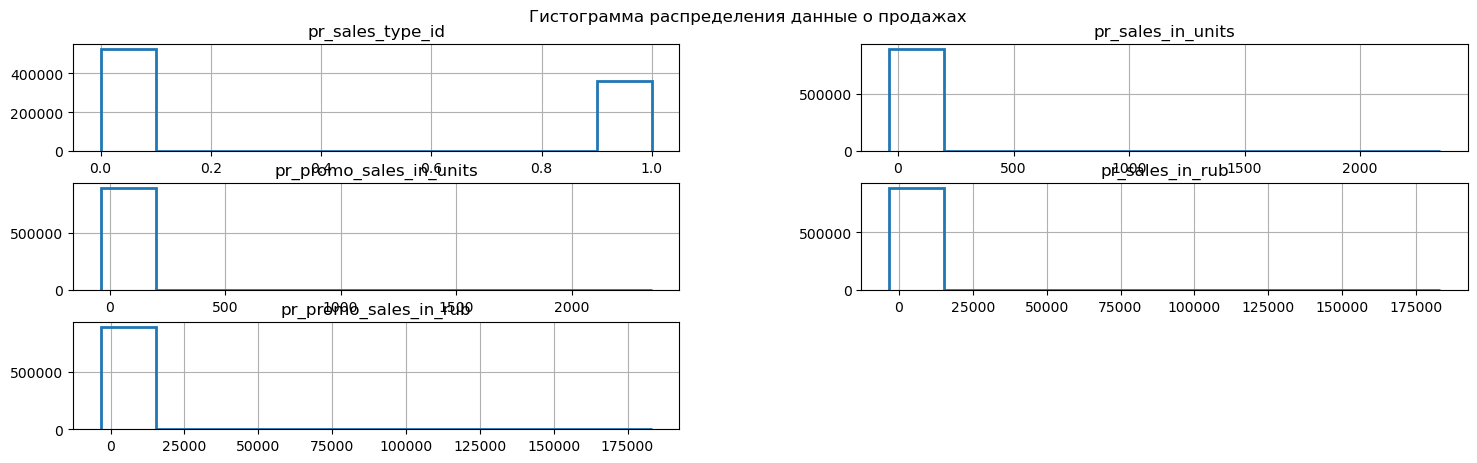

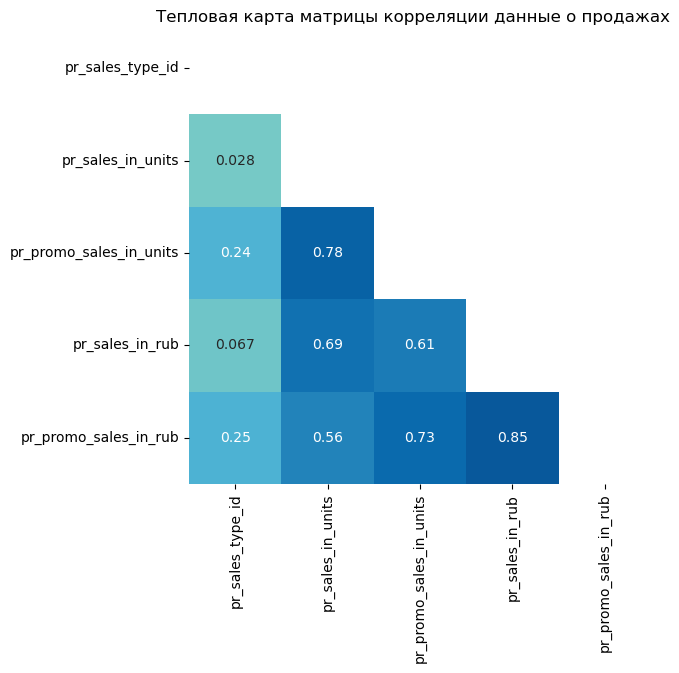

pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
count     883015.000000      883015.000000            883015.000000   
mean           0.406486           5.037956                 2.230010   
std            0.491178          13.402984                11.063288   
min            0.000000         -39.000000               -39.000000   
25%            0.000000           1.000000                 0.000000   
50%            0.000000           2.000000                 0.000000   
75%            1.000000           4.000000                 1.000000   
max            1.000000        2348.000000              2348.000000   

       pr_sales_in_rub  pr_promo_sales_in_rub  
count    883015.000000          883015.000000  
mean        596.705181             294.766561  
std        1577.366179            1402.764168  
min       -3373.000000           -3373.000000  
25%          98.000000               0.000000  
50%         224.000000               0.000000  
75%         540.000000             127.000000  
max      183265.000000          183265.000000

st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde60d8bf777ab6bc3b4   
3  42a0e188f5033bc65bf8d78622277c4e  8e887cf8e64ab8e7173701a979476567   
4  16a5cdae362b8d27a1d8f8c7b78b4330  e6fc24ca846339d204b0b50e9f772484   

        date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0 2022-10-20                 1                5.0                      5.0   
1 2023-01-29                 0                4.0                      0.0   
2 2023-03-02                 0                1.0                      0.0   
3 2023-04-05                 1                0.0                      0.0   
4 2023-02-17                 0                1.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub  
0            825.0                  825.0  
1            196.0                    0.0  
2             78.0                    0.0  
3             69.0                   69.0  
4            161.0                    0.0

Размер данных:      (12, 4)
Количество явных дубликатов: 4
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
st_type_format_id    0.0
st_type_loc_id       0.0
st_type_size_id      0.0
st_is_active         0.0
dtype: float64

Проверка структуры данных по магазинам:


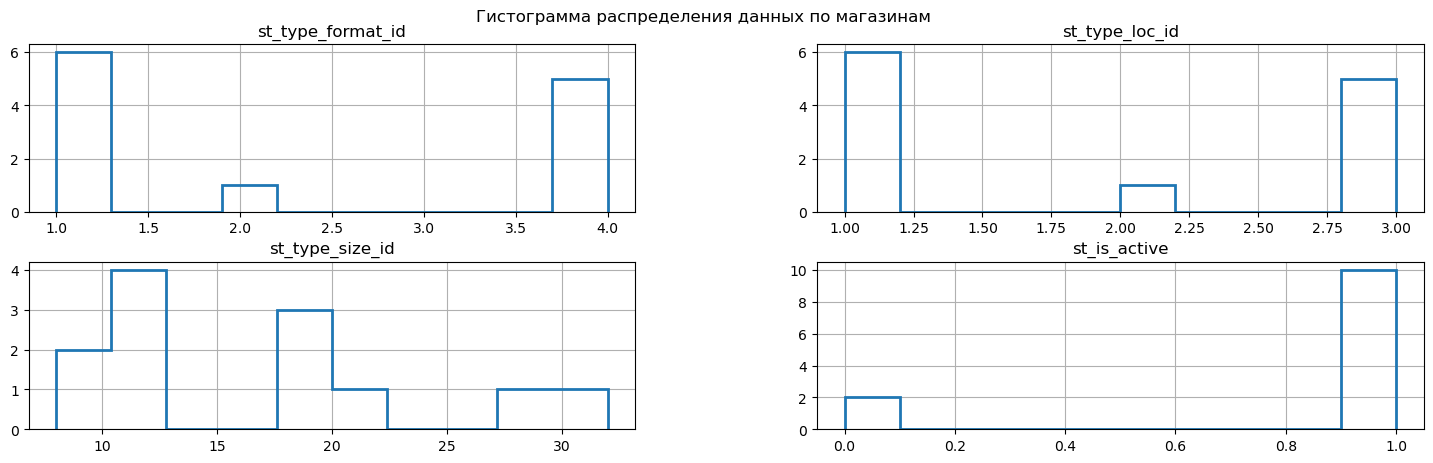

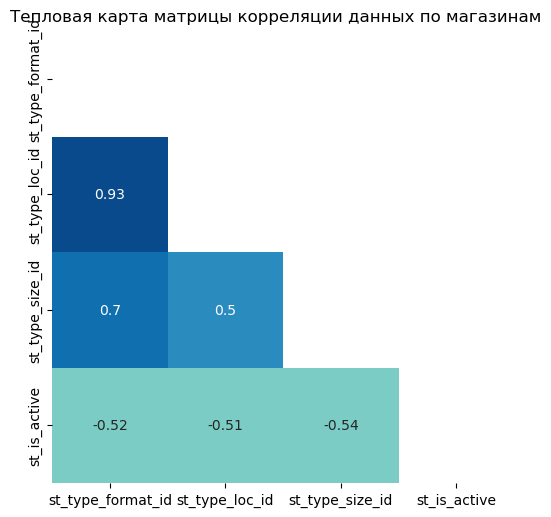

st_type_format_id  st_type_loc_id  st_type_size_id  st_is_active
count          12.000000       12.000000        12.000000     12.000000
mean            2.333333        1.916667        16.750000      0.833333
std             1.497473        0.996205         7.557356      0.389249
min             1.000000        1.000000         8.000000      0.000000
25%             1.000000        1.000000        12.000000      1.000000
50%             1.500000        1.500000        15.500000      1.000000
75%             4.000000        3.000000        19.250000      1.000000
max             4.000000        3.000000        32.000000      1.000000

st_id                        st_city_id  \
0  1aa057313c28fa4a40c5bc084b11d276  1587965fb4d4b5afe8428a4a024feb0d   
1  bd470ca955d9497bbcb808e59952fffc  955d864a62659945cc9434898e275deb   
2  6364d3f0f495b6ab9dcf8d3b5c6e0b01  b8b4b727d6f5d1b61fff7be687f7970f   
3  1ecfb463472ec9115b10c292ef8bc986  908c9a564a86426585b29f5335b619bc   
4  16a5cdae362b8d27a1d8f8c7b78b4330  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                   st_division_code  st_type_format_id  st_type_loc_id  \
0  81b4dd343f5880df806d4c5d4a846c64                  4               3   
1  e26072c92d8fe0738df44d571d5f5e8b                  4               3   
2  da742b3cfca5388aaf9af28a726a3c30                  1               1   
3  429a86ff6336c144ddaf6144f52ab52c                  2               1   
4  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

   st_type_size_id  st_is_active  
0               19             0  
1               19             1  
2               12             1  
3               28             1  
4                8             1

In [8]:
research(data_train, 'данные о продажах', figsize=(18, 5), silent=False)
research(data_st, 'данных по магазинам', figsize=(18, 5), silent=False)

Размер данных:      (2050, 1)
Количество явных дубликатов: 2048
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
pr_uom_id    0.0
dtype: float64
Корреляция данных по товарной иерархии


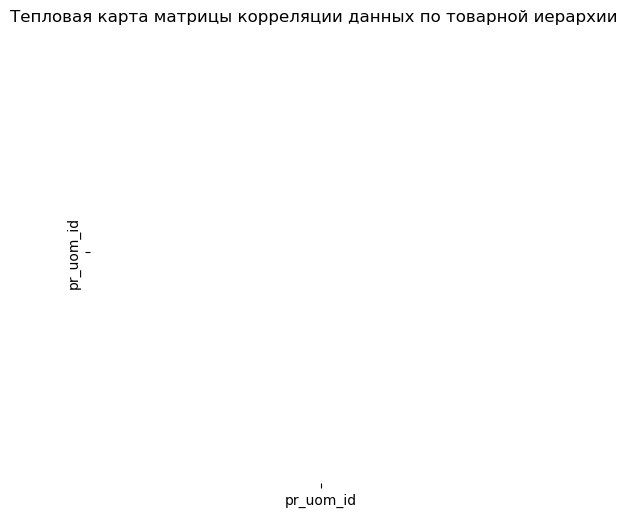

pr_uom_id
count  2050.000000
mean      7.017561
std       7.752371
min       1.000000
25%       1.000000
50%       1.000000
75%      17.000000
max      17.000000

Размер данных:      (43694, 1)
Количество явных дубликатов: 43693
Наличие пропусков:           0
Пропущенные данные (в процентном соотношении):
target    0.0
dtype: float64
Корреляция итоговом датасете


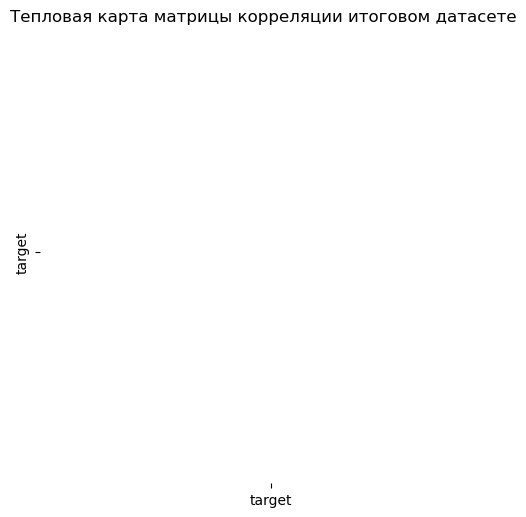

target
count  43694.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0

In [9]:
research(data_pr, 'данных по товарной иерархии', figsize=((18, 5)), silent=True)
research(data_sample, 'итоговом датасете', figsize=((18, 5)), silent=True)

In [10]:
express_info(calendar, 'календарь')

Информация о календарь:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3653 non-null   int64 
 1   day      3653 non-null   int64 
 2   weekday  3653 non-null   int64 
 3   date     3653 non-null   object
 4   calday   3653 non-null   int64 
 5   holiday  3653 non-null   int64 
 6   covid    3653 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 199.9+ KB


year  day  weekday        date    calday  holiday  covid
0  2015    1        4  01.01.2015  20150101        1      0
1  2015    2        5  02.01.2015  20150102        1      0
2  2015    3        6  03.01.2015  20150103        1      0
3  2015    4        7  04.01.2015  20150104        1      0
4  2015    5        1  05.01.2015  20150105        1      0

## Предварительное изучение данных.

In [11]:
#в календарь праздников добавим `month`
calendar['month']=pd.DatetimeIndex(calendar['date']).month
calendar['month'] = pd.to_numeric(calendar['month'], errors='coerce')
calendar = calendar[['date','year', 'month', 'weekday', 'day', 'holiday',  'calday','covid']]
#удалим неинформативные признаки 'calday', 'covid'
calendar = calendar.drop(['calday', 'covid' ], axis=1)
express_info(calendar, 'календарь')

Информация о календарь:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     3653 non-null   object
 1   year     3653 non-null   int64 
 2   month    3653 non-null   int32 
 3   weekday  3653 non-null   int64 
 4   day      3653 non-null   int64 
 5   holiday  3653 non-null   int64 
dtypes: int32(1), int64(4), object(1)
memory usage: 157.1+ KB


date  year  month  weekday  day  holiday
0  01.01.2015  2015      1        4    1        1
1  02.01.2015  2015      2        5    2        1
2  03.01.2015  2015      3        6    3        1
3  04.01.2015  2015      4        7    4        1
4  05.01.2015  2015      5        1    5        1

In [12]:
print ('Начало временного ряда: ', data_train['date'].min())
print ('Конец временного ряда: ', data_train['date'].max())

Начало временного ряда:  2022-08-01 00:00:00
Конец временного ряда:  2023-07-18 00:00:00


## Выводы
1. Пропуски и явные дубликаты в данных не обнаружены
2. Тепловая карта показала, явную корреляцию в `pr_sales_in_units` и `pr_promo_sales_in_units`, `pr_sales_in_rub` и `pr_promo_sales_in_rub`, что логично, так как одни данные являются частью других (возможно при формировании признаков надо будет удалить один из столбцов в парах)
3. Проверка структуры данных по магазинам показала высокую корреляцию между форматом магазина и локацией. Видимо, от локации зависит тип магазина. Формат магазина коррелирует с размером - тоже логично. Скорее всего при формировании признаков будем удалять формат магазина.
4. Анализ зависимости числовых вявил линейную зависимость между количеством продаж и суммы продаж, что логично, а также общих продаж от промопродаж, с большим количеством выбросов в 0 (надо будет более детально исследовать эту зависимость).
5. Начало временного ряда:  2022-08-01
6. Конец временного ряда:  2023-07-18
7. Всего 351 день

## Предварительная подготовка данных и удаление избыточной

In [13]:
data_merge = pd.merge(data_train, data_pr, on='pr_sku_id', how='left')
data_merge = pd.merge(data_merge, data_st, on='st_id', how='left')
data_merge.head(3)

st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde60d8bf777ab6bc3b4   

        date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0 2022-10-20                 1                5.0                      5.0   
1 2023-01-29                 0                4.0                      0.0   
2 2023-03-02                 0                1.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub                       pr_group_id  \
0            825.0                  825.0  aab3238922bcc25a6f606eb525ffdc56   
1            196.0                    0.0  c74d97b01eae257e44aa9d5bade97baf   
2             78.0                    0.0  c74d97b01eae257e44aa9d5bade97baf   

                          pr_cat_id                      pr_subcat_id  \
0  28fc2782ea7ef51c1104ccf7b9bea13d  d29b5ce9c2883f0b7e90f79071a2ca82   
1  1bc0249a6412ef49b07fe6f62e6dc8de  68f204f3838bfee4ada868b66e6a0814   
2  f3173935ed8ac4bf073c1bcd63171f8a  5fd72b9fc7118bd36a137d7cea8c588a   

   pr_uom_id                        st_city_id  \
0          1  908c9a564a86426585b29f5335b619bc   
1         17  b8b4b727d6f5d1b61fff7be687f7970f   
2         17  908c9a564a86426585b29f5335b619bc   

                   st_division_code  st_type_format_id  st_type_loc_id  \
0  429a86ff6336c144ddaf6144f52ab52c                  1               1   
1  da742b3cfca5388aaf9af28a726a3c30                  1               1   
2  429a86ff6336c144ddaf6144f52ab52c                  2               1   

   st_type_size_id  st_is_active  
0                8             1  
1               12             1  
2               28             1

In [14]:
#Сохраним полученные данные
#calendar.to_csv('calendar.csv', index=False)

## Формирование общего датасета для дальнейшего исследования и предобработки

In [15]:
# объеденим по общим столбцам
merged_df = pd.merge(data_train, data_pr, on='pr_sku_id', how='left')
merged_df = pd.merge(merged_df, data_st, on='st_id', how='left')
merged_df.head()

st_id                         pr_sku_id  \
0  c81e728d9d4c2f636f067f89cc14862c  c7b711619071c92bef604c7ad68380dd   
1  42a0e188f5033bc65bf8d78622277c4e  68f441429e73dbd33b81f95da31576e9   
2  1ecfb463472ec9115b10c292ef8bc986  22988026fe85fde60d8bf777ab6bc3b4   
3  42a0e188f5033bc65bf8d78622277c4e  8e887cf8e64ab8e7173701a979476567   
4  16a5cdae362b8d27a1d8f8c7b78b4330  e6fc24ca846339d204b0b50e9f772484   

        date  pr_sales_type_id  pr_sales_in_units  pr_promo_sales_in_units  \
0 2022-10-20                 1                5.0                      5.0   
1 2023-01-29                 0                4.0                      0.0   
2 2023-03-02                 0                1.0                      0.0   
3 2023-04-05                 1                0.0                      0.0   
4 2023-02-17                 0                1.0                      0.0   

   pr_sales_in_rub  pr_promo_sales_in_rub                       pr_group_id  \
0            825.0                  825.0  aab3238922bcc25a6f606eb525ffdc56   
1            196.0                    0.0  c74d97b01eae257e44aa9d5bade97baf   
2             78.0                    0.0  c74d97b01eae257e44aa9d5bade97baf   
3             69.0                   69.0  aab3238922bcc25a6f606eb525ffdc56   
4            161.0                    0.0  c74d97b01eae257e44aa9d5bade97baf   

                          pr_cat_id                      pr_subcat_id  \
0  28fc2782ea7ef51c1104ccf7b9bea13d  d29b5ce9c2883f0b7e90f79071a2ca82   
1  1bc0249a6412ef49b07fe6f62e6dc8de  68f204f3838bfee4ada868b66e6a0814   
2  f3173935ed8ac4bf073c1bcd63171f8a  5fd72b9fc7118bd36a137d7cea8c588a   
3  28fc2782ea7ef51c1104ccf7b9bea13d  a13b7a6b8e80d44d044c257a08ecccca   
4  a368b0de8b91cfb3f91892fbf1ebd4b2  0d51481bbf77027ddb2c990cf97cd9dd   

   pr_uom_id                        st_city_id  \
0          1  908c9a564a86426585b29f5335b619bc   
1         17  b8b4b727d6f5d1b61fff7be687f7970f   
2         17  908c9a564a86426585b29f5335b619bc   
3          1  b8b4b727d6f5d1b61fff7be687f7970f   
4          1  c1f75cc0f7fe269dd0fd9bd5e24f9586   

                   st_division_code  st_type_format_id  st_type_loc_id  \
0  429a86ff6336c144ddaf6144f52ab52c                  1               1   
1  da742b3cfca5388aaf9af28a726a3c30                  1               1   
2  429a86ff6336c144ddaf6144f52ab52c                  2               1   
3  da742b3cfca5388aaf9af28a726a3c30                  1               1   
4  296bd0cc6e735f9d7488ebc8fbc19130                  1               2   

   st_type_size_id  st_is_active  
0                8             1  
1               12             1  
2               28             1  
3               12             1  
4                8             1

In [16]:
#Установим новые название колонок
merged_df.columns = ['store', 'sku', 'date', 'sales_type', 'sales_units',
       'sales_units_promo', 'sales_rub', 'sales_rub_promo',
       'group', 'category', 'subcategory', 'uom', 'city',
       'division', 'type_format', 'loc', 'size', 'is_active']

In [17]:
# сделаем дату индексом и переведем в объект datetime
merged_df.set_index('date', inplace=True)
merged_df.index = pd.to_datetime(merged_df.index)

In [18]:
# сделаем дату индексом
calendar['date'] = pd.to_datetime(calendar['date'], format='%d.%m.%Y')
calendar.set_index('date', inplace=True)
#calendar.index = pd.to_datetime(calendar.index)

In [19]:
# добавим календарь праздников к данным
data = pd.merge(calendar, merged_df, left_index=True, right_index=True)
data.head()

year  month  weekday  day  holiday  \
date                                             
2022-08-01  2022      1        1    1        0   
2022-08-01  2022      1        1    1        0   
2022-08-01  2022      1        1    1        0   
2022-08-01  2022      1        1    1        0   
2022-08-01  2022      1        1    1        0   

                                       store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  f7e6c85504ce6e82442c770f7c8606f0   

                                         sku  sales_type  sales_units  \
date                                                                    
2022-08-01  4ce0eb956648ab3ff6bb0afa3158cc42           1          0.0   
2022-08-01  a26de72f8ea9889b7332ed5f940d8b62           0         21.0   
2022-08-01  eb341a778d385ad6ebe16e90efb48c08           1          1.0   
2022-08-01  dce1f234d6424aa61f8e7ce0baffd9af           0          6.0   
2022-08-01  79122a5063b8a1261b8b1f03509ef957           1          1.0   

            sales_units_promo  ...                             group  \
date                           ...                                     
2022-08-01                0.0  ...  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01                0.0  ...  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01                1.0  ...  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01                0.0  ...  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01                1.0  ...  c74d97b01eae257e44aa9d5bade97baf   

                                    category  \
date                                           
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  28fc2782ea7ef51c1104ccf7b9bea13d   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  c559da2ba967eb820766939a658022c8   

                                 subcategory uom  \
date                                               
2022-08-01  8afe22eeb3f3f68de994a3c60388858c   1   
2022-08-01  e06f5ed77191826c212c30722f2cc5a2  17   
2022-08-01  b3e70d072fc648f6934c288e44f5c35e   1   
2022-08-01  c01c475ac8d447730ece97d846cc4f25   1   
2022-08-01  89b0107c6d0aca5f15fa7a715f9e06e5   1   

                                        city  \
date                                           
2022-08-01  908c9a564a86426585b29f5335b619bc   
2022-08-01  908c9a564a86426585b29f5335b619bc   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f   
2022-08-01  3202111cf90e7c816a472aaceb72b0df   

                                    division type_format loc  size  is_active  
date                                                                           
2022-08-01  429a86ff6336c144ddaf6144f52ab52c           1   1     8          1  
2022-08-01  429a86ff6336c144ddaf6144f52ab52c           1   1     8          1  
2022-08-01  da742b3cfca5388aaf9af28a726a3c30           1   1    12          1  
2022-08-01  da742b3cfca5388aaf9af28a726a3c30           1   1    12          1  
2022-08-01  32586311f16876abf92901085bd87b99           1   1    12          1  

[5 rows x 22 columns]

In [20]:
# изменим порядок столбцов на удобный
new_order = ['is_active', 'store', 'sku', 'sales_type', 'sales_units', 'sales_units_promo',
             'sales_rub', 'sales_rub_promo','group', 'category', 'subcategory', 'uom', 'division',
             'city', 'type_format', 'loc', 'size', 'year', 'month', 'day', 'weekday', 'holiday']
data = data[new_order]

In [21]:
express_info(data, 'по объедененному датасету')
#research(data, 'данных по объедененному датасету', figsize=(15, 10), silent=True)

Информация о по объедененному датасету:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 883015 entries, 2022-08-01 to 2023-07-18
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   is_active          883015 non-null  int64  
 1   store              883015 non-null  object 
 2   sku                883015 non-null  object 
 3   sales_type         883015 non-null  int64  
 4   sales_units        883015 non-null  float64
 5   sales_units_promo  883015 non-null  float64
 6   sales_rub          883015 non-null  float64
 7   sales_rub_promo    883015 non-null  float64
 8   group              883015 non-null  object 
 9   category           883015 non-null  object 
 10  subcategory        883015 non-null  object 
 11  uom                883015 non-null  int64  
 12  division           883015 non-null  object 
 13  city               883015 non-null  object 
 14  type_format        883015 non-null  int64  


is_active                             store  \
date                                                      
2022-08-01          1  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01          1  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01          1  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01          1  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01          1  f7e6c85504ce6e82442c770f7c8606f0   

                                         sku  sales_type  sales_units  \
date                                                                    
2022-08-01  4ce0eb956648ab3ff6bb0afa3158cc42           1          0.0   
2022-08-01  a26de72f8ea9889b7332ed5f940d8b62           0         21.0   
2022-08-01  eb341a778d385ad6ebe16e90efb48c08           1          1.0   
2022-08-01  dce1f234d6424aa61f8e7ce0baffd9af           0          6.0   
2022-08-01  79122a5063b8a1261b8b1f03509ef957           1          1.0   

            sales_units_promo  sales_rub  sales_rub_promo  \
date                                                        
2022-08-01                0.0       79.0             79.0   
2022-08-01                0.0      462.0              0.0   
2022-08-01                1.0      154.0            154.0   
2022-08-01                0.0      860.0              0.0   
2022-08-01                1.0       57.0             57.0   

                                       group  \
date                                           
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   

                                    category  ...  \
date                                          ...   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1  ...   
2022-08-01  c559da2ba967eb820766939a658022c8  ...   
2022-08-01  28fc2782ea7ef51c1104ccf7b9bea13d  ...   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1  ...   
2022-08-01  c559da2ba967eb820766939a658022c8  ...   

                                    division  \
date                                           
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-01  da742b3cfca5388aaf9af28a726a3c30   
2022-08-01  da742b3cfca5388aaf9af28a726a3c30   
2022-08-01  32586311f16876abf92901085bd87b99   

                                        city type_format loc  size  year  \
date                                                                       
2022-08-01  908c9a564a86426585b29f5335b619bc           1   1     8  2022   
2022-08-01  908c9a564a86426585b29f5335b619bc           1   1     8  2022   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f           1   1    12  2022   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f           1   1    12  2022   
2022-08-01  3202111cf90e7c816a472aaceb72b0df           1   1    12  2022   

            month  day  weekday  holiday  
date                                      
2022-08-01      1    1        1        0  
2022-08-01      1    1        1        0  
2022-08-01      1    1        1        0  
2022-08-01      1    1        1        0  
2022-08-01      1    1        1        0  

[5 rows x 22 columns]

In [22]:
# наличие пропусков в индексе DataFrame
has_missing_index = data.index.isna().any()

if has_missing_index:
    print("В индексе есть пропущенные значения.")
else:
    print("Пропущенных значений в индексе нет.")

Пропущенных значений в индексе нет.


In [23]:
# проверим последовательность данных
print("Индекс монотонно возрастающий:", data.index.is_monotonic_increasing)

Индекс монотонно возрастающий: True


## Вывод
- подготовили данные таблицы к работе 
- добавили столбец с месяцем
- удалили неинформативные признаки 'covid', 'calday', 'covid'
- объединили датасеты в один по дате
- переименовали колонки:
```
['is_active', 'store', 'sku', 'sales_type', 'sales_units', 'sales_units_promo',
             'sales_rub', 'sales_rub_promo','group', 'category', 'subcategory', 'uom', 'division',
             'city', 'type_format', 'loc', 'size', 'year', 'month', 'day', 'weekday', 'holiday']
```
- проверили на монотонность и наличие пропущенных значений во временном ряду

# Исследовательский анализ

- обрабокта аномалий, пропусков и дубликатов
- формирования датасета для анализа

## Активные магазины
Определим активные магазины с которыми будем работать

In [24]:
# функцию построения графика
def plot_pie(data, title):
    graph = data.value_counts()\
    .plot.pie(legend=True,labeldistance=1.1, autopct='%1.2f%%', figsize=(5,5))
    plt.title(title)
    plt.show()

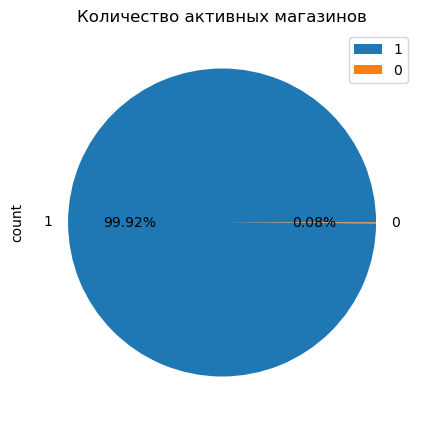

In [25]:
plot_pie(data['is_active'], 'Количество активных магазинов')
#1-активные, 0-неактивные

In [26]:
# список магазинов
list_store = data['store'].unique().tolist()

In [27]:
#Определим неактивные магазины
no_active_st_id = data[data['is_active'] != 1].groupby('store')['is_active'].sum()
no_active_st_id

store
1aa057313c28fa4a40c5bc084b11d276    0
62f91ce9b820a491ee78c108636db089    0
Name: is_active, dtype: int64

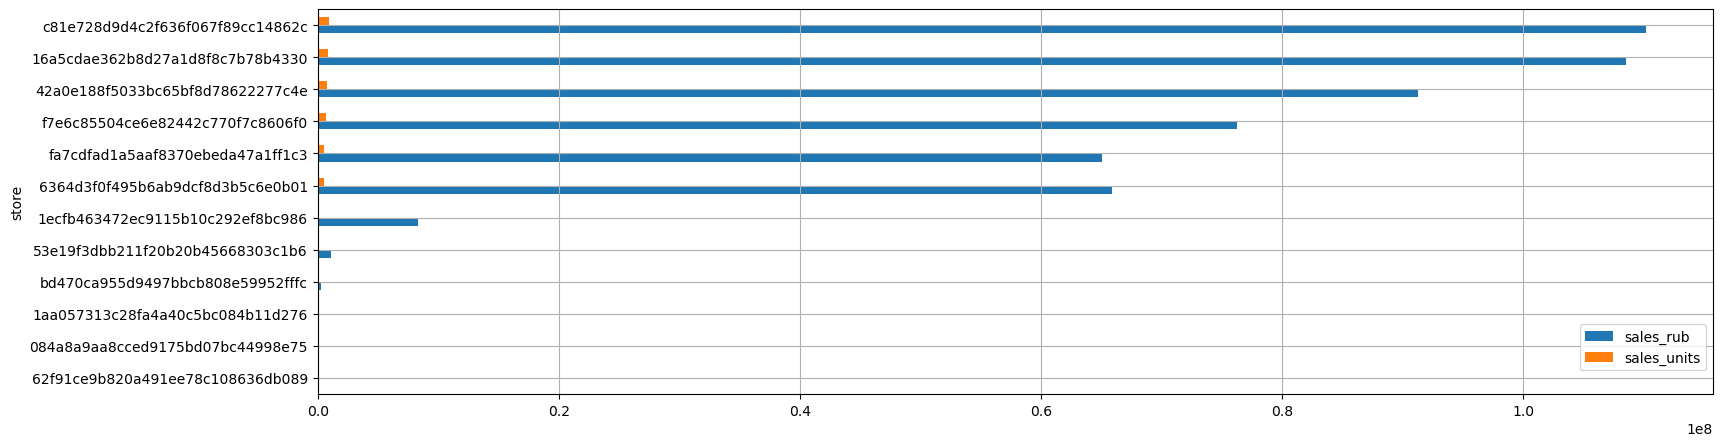

In [28]:
# оценим продажи в магазинах
df_pivot = data.pivot_table(
    index=['store'], values=['sales_units', 'sales_rub'],
    aggfunc=sum).sort_values(by='sales_units', ascending=True)
# визуализируем продажи в магазинах
ax = df_pivot.plot(kind='barh', grid=True, figsize=(18, 5))
ax.legend(loc='best', bbox_to_anchor=(1, 0.2));

In [29]:
# список для хранения данных о магазинах и их количестве дней работы
activ_store_data = []
store_data = []

for st in list_store:
    min_date = data.loc[data['store'] == st].index.min().date()
    max_date = data.loc[data['store'] == st].index.max().date()
    delta = max_date - min_date
    days = delta.days
    if days > 180:
        activ_store_data.append({'stores': st, 'days_worked': days})
    else:
        store_data.append({'stores': st, 'days_worked': days})

# сотируем магазины по количеству дней работы
a_sorted_stores= sorted(activ_store_data, key=lambda x: x['days_worked'], reverse=True)
sorted_stores = sorted(store_data, key=lambda x: x['days_worked'], reverse=True)

# сортируем магазины по дням работы
for store_info in sorted_stores:
    store = store_info['stores']
    days = store_info['days_worked']
    print("Магазин:", store, 'работал', days, 'дней')
    print("-" * 60)
print("=" * 60)
for store_info in a_sorted_stores:
    store = store_info['stores']
    days = store_info['days_worked']
    print("Магазин:", store, 'работал', days, 'дней')
    print("-" * 60)

Магазин: 084a8a9aa8cced9175bd07bc44998e75 работал 95 дней
------------------------------------------------------------
Магазин: 1aa057313c28fa4a40c5bc084b11d276 работал 30 дней
------------------------------------------------------------
Магазин: 62f91ce9b820a491ee78c108636db089 работал 15 дней
------------------------------------------------------------
Магазин: c81e728d9d4c2f636f067f89cc14862c работал 351 дней
------------------------------------------------------------
Магазин: 42a0e188f5033bc65bf8d78622277c4e работал 351 дней
------------------------------------------------------------
Магазин: f7e6c85504ce6e82442c770f7c8606f0 работал 351 дней
------------------------------------------------------------
Магазин: 6364d3f0f495b6ab9dcf8d3b5c6e0b01 работал 351 дней
------------------------------------------------------------
Магазин: 16a5cdae362b8d27a1d8f8c7b78b4330 работал 351 дней
------------------------------------------------------------
Магазин: fa7cdfad1a5aaf8370ebeda47a1ff1c3 р

## Удалим магазины с малой активностью

In [30]:
# получим список идентификаторов магазинов из списка store_data
store_ids = [entry['stores'] for entry in store_data]

# cоздаем маску для строк на удаления
mask = data['store'].isin(store_ids)

In [31]:
activ_store = data[~data['store'].isin(store_ids)]

In [32]:
# удалим столбцец 'is_active'
activ_store = activ_store.drop('is_active', axis=1)

In [33]:
print('Исходные данные:' , len(data))
print('Очищенные данные:', len(activ_store))
print(f'Удалено {((len(data) - len(activ_store))/(len(data))):.2%} от исходных данных')

Исходные данные: 883015
Очищенные данные: 882248
Удалено 0.09% от исходных данных


## Вывод
1. Не все магазины были активны в течение периода исследований.
2. Магазин с наибольшими продажами в рублях и штуках `'c81e728d9d4c2f636f067f89cc14862c'` работал весь период, отберем для теста.
3. Малоактивные магазины, которые работали менее 100 дней - удалены (3 магазина).
4. Удален столбец 'st_is_active', так как теперь он неинформанивнен.

## Исследуем признаки
> Функция исследования признаков

In [34]:
# функцию для изучения данных в столбцах
def feed_size(data, state, name_state): #x_lim0,,  x_lim
    print(f'Статистические данные о распределении значений {name_state} ({state}):')
    display(data[f'{state}'].describe())

    plt.subplots(figsize=(18, 5))
    #plt.xlim([0,x_lim])#x_lim0,
    plt.title(f'Диаграмма рассеяния {name_state} ({state})')
    sns.boxplot(x=data[f'{state}'], palette='pastel', data=data[f'{state}'])
    plt.show()

    plt.figure(figsize=(18, 5))
    #sns.kdeplot(data[f'{state}'], fill=True, label=f'{state} {name_state}', alpha=0.6, shade=True)
    sns.histplot(data[f'{state}'], bins=50, color="seagreen", label=f'{name_state}', alpha=0.7, kde=True)
    #sns.distplot(data[f'{state}'], color="seagreen", label=f'{name_state}', fit=norm);
    #plt.xlim([0,x_lim]) #x_lim0,
    plt.xlabel(f'{state}')
    plt.ylabel(f'Распределение вероятности \n-непрерывной величины', fontsize=10)
    plt.legend(loc='upper right')
    plt.title(f'Гистограмма распределения {name_state} ({state})', fontsize=12)
    #fig = plt.figure()
    #res = stats.probplot(data[f'{state}'], plot=plt)
    plt.show()

#Функцияпо по построению гистограммы и функции нормального распределения
def graph(data, name):
    sns.distplot(data[name], fit=norm);
    #plt.xlim([0,55000])
    fig = plt.figure()
    plt.show()
    #проверим на нормальность
    res = stats.probplot(data[name], plot=plt)
    #Посчитаем Ассиметрию и Эксцесс
    print("Ассиметрия:%f" % data[name].skew())
    print("Эксцесс: %f" % data[name].kurt())
    print("Среднее : %f" % data[name].mean())
    print("Отклонение  %f" % data[name].var())

### Целевой признак - `pr_sales_in_units`

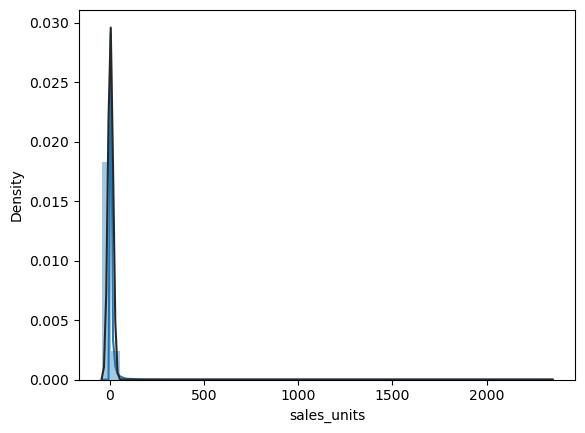

<Figure size 640x480 with 0 Axes>

Ассиметрия:31.566278
Эксцесс: 2882.753565
Среднее : 5.039692
Отклонение  179.788712


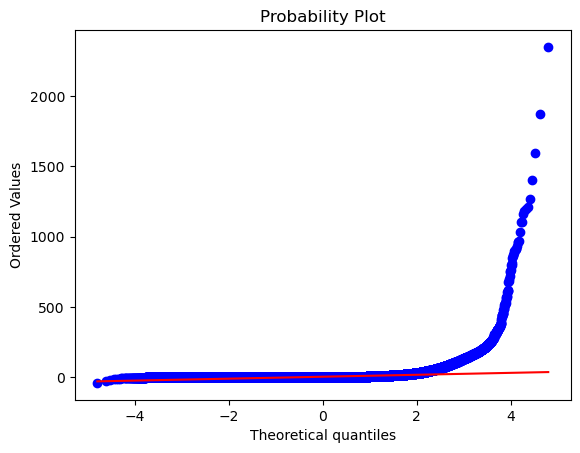

In [35]:
#graph(data)
graph(activ_store, 'sales_units')

Статистические данные о распределении значений общие продажи (sales_units):


count    882248.000000
mean          5.039692
std          13.408531
min         -39.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        2348.000000
Name: sales_units, dtype: float64

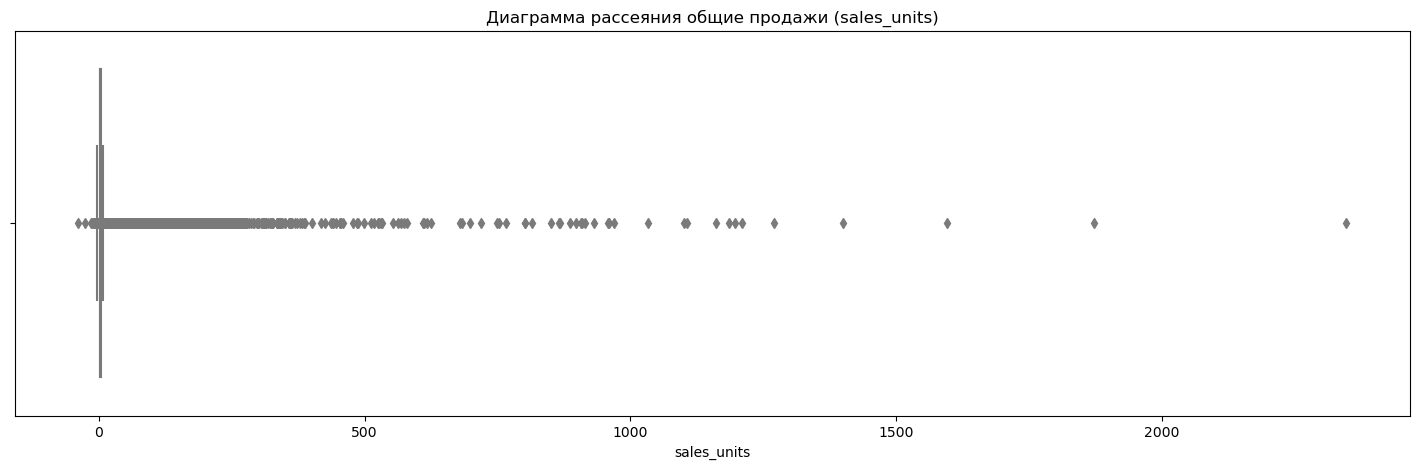

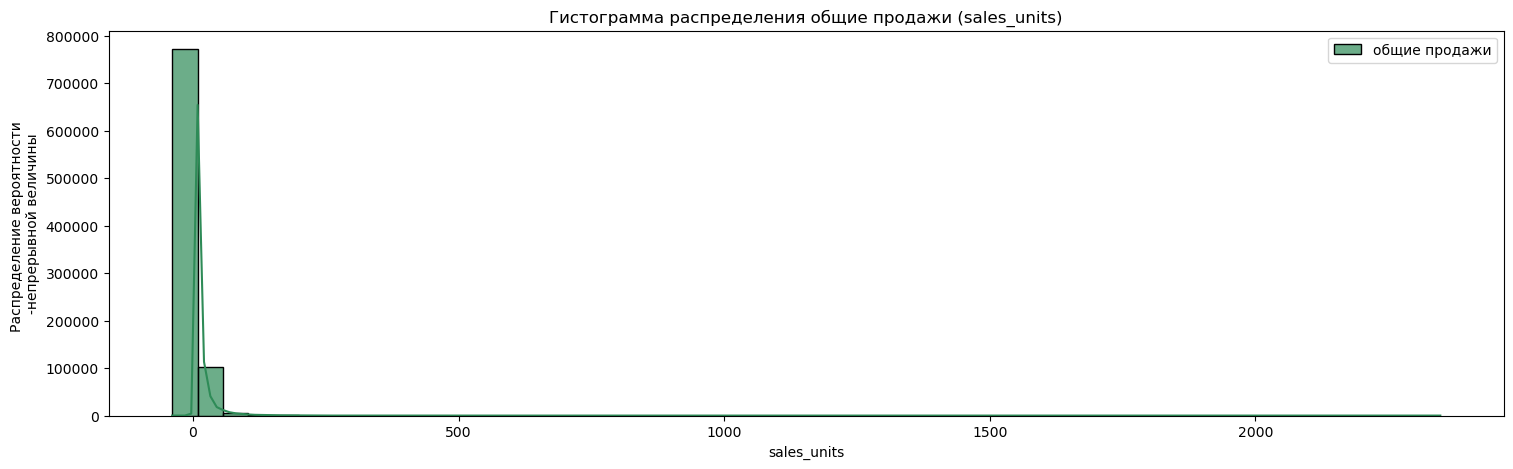

In [36]:
feed_size(activ_store, 'sales_units', 'общие продажи')#, 2000

### Удалим отрицательные значения

In [37]:
#activ_store[activ_store['sales_in_units'] < 0] #.value_counts('pr_sales_in_units').sum() #count()

In [38]:
mask_negativ = ((activ_store['sales_units'] < 0) | (activ_store['sales_units_promo'] < 0) | (activ_store['sales_rub'] < 0)\
                | (activ_store['sales_rub_promo'] < 0))
# удаляем строки, соответствующие маске, из activ_store
activ_store = activ_store[~mask_negativ]

In [39]:
print('Исходные данные:' , len(data))
print('Очищенные данные:', len(activ_store))
print(f'Удалено {((len(data) - len(activ_store))/(len(data))):.2%} от исходных данных')

Исходные данные: 883015
Очищенные данные: 882169
Удалено 0.10% от исходных данных


### Нулевые значения в целевом признаке

In [40]:
# строки с нулевым значением в столбце число проданных товаров
null_pr_sales_in_units = activ_store[activ_store['sales_units'] == 0]
null_pr_sales_in_units

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
...                                      ...   
2023-07-18  f7e6c85504ce6e82442c770f7c8606f0   
2023-07-18  42a0e188f5033bc65bf8d78622277c4e   
2023-07-18  f7e6c85504ce6e82442c770f7c8606f0   
2023-07-18  42a0e188f5033bc65bf8d78622277c4e   
2023-07-18  c81e728d9d4c2f636f067f89cc14862c   

                                         sku  sales_type  sales_units  \
date                                                                    
2022-08-01  4ce0eb956648ab3ff6bb0afa3158cc42           1          0.0   
2022-08-01  a08abd96f9e056ad8cf9db4ae5f5754a           0          0.0   
2022-08-01  f5a455e5fea834c85429331d934c40fa           0          0.0   
2022-08-01  0f6ef309087f70a6f933eb0ec50745b4           1          0.0   
2022-08-01  fd123209467a1e417afbf89f3b7525a5           0          0.0   
...                                      ...         ...          ...   
2023-07-18  a4680e47cdf0ef37aeb19717a9d1968c           0          0.0   
2023-07-18  6bebdb943dc661b7af1e9469a8caeb3f           0          0.0   
2023-07-18  f26a7266746690b16a77b3073651d75d           1          0.0   
2023-07-18  4cae0c39b837072ea25f1c1545de0018           0          0.0   
2023-07-18  dce1f234d6424aa61f8e7ce0baffd9af           1          0.0   

            sales_units_promo  sales_rub  sales_rub_promo  \
date                                                        
2022-08-01                0.0       79.0             79.0   
2022-08-01                0.0       29.0              0.0   
2022-08-01                0.0       68.0              0.0   
2022-08-01                0.0       84.0             84.0   
2022-08-01                0.0       84.0              0.0   
...                       ...        ...              ...   
2023-07-18                0.0      112.0              0.0   
2023-07-18                0.0       40.0              0.0   
2023-07-18                0.0      106.0            106.0   
2023-07-18                0.0       28.0              0.0   
2023-07-18                0.0       43.0             43.0   

                                       group  \
date                                           
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  6512bd43d9caa6e02c990b0a82652dca   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  6512bd43d9caa6e02c990b0a82652dca   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
...                                      ...   
2023-07-18  aab3238922bcc25a6f606eb525ffdc56   
2023-07-18  c74d97b01eae257e44aa9d5bade97baf   
2023-07-18  aab3238922bcc25a6f606eb525ffdc56   
2023-07-18  c74d97b01eae257e44aa9d5bade97baf   
2023-07-18  aab3238922bcc25a6f606eb525ffdc56   

                                    category  \
date                                           
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  b59c67bf196a4758191e42f76670ceba   
2022-08-01  46771d1f432b42343f56f791422a4991   
2022-08-01  e58cc5ca94270acaceed13bc82dfedf7   
2022-08-01  f3173935ed8ac4bf073c1bcd63171f8a   
...                                      ...   
2023-07-18  9701a1c165dd9420816bfec5edd6c2b1   
2023-07-18  a368b0de8b91cfb3f91892fbf1ebd4b2   
2023-07-18  28fc2782ea7ef51c1104ccf7b9bea13d   
2023-07-18  1bc0249a6412ef49b07fe6f62e6dc8de   
2023-07-18  9701a1c165dd9420816bfec5edd6c2b1   

                                 subcategory  ...  \
date                                          ...   
2022-08-01  8afe22eeb3f3f68de994a3c60388858c  ...   
2022-08-01  11fb95ff05cc28bb107e4a920c60b6cf  ...   
2022-08-01  38cc804f2e8d4b18785b84c68517eadf  ...   
2022-08-01  c0a667df8f0d6ee98dda972b0870fabf  ...   
2022-08-01  271bfd185d8c11ed902a1c87e43f2eb7  ...   
...                                      ...  ...

In [41]:
# строки с нулевым значением в столбце число проданных товаров
null_pr_sales_in_rub = activ_store[activ_store['sales_rub'] == 0]
null_pr_sales_in_rub

store  \
date                                           
2022-08-01  f7e6c85504ce6e82442c770f7c8606f0   
2022-08-02  6364d3f0f495b6ab9dcf8d3b5c6e0b01   
2022-08-03  f7e6c85504ce6e82442c770f7c8606f0   
2022-08-03  c81e728d9d4c2f636f067f89cc14862c   
2022-08-05  1ecfb463472ec9115b10c292ef8bc986   
...                                      ...   
2023-07-16  1ecfb463472ec9115b10c292ef8bc986   
2023-07-16  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
2023-07-16  1ecfb463472ec9115b10c292ef8bc986   
2023-07-18  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
2023-07-18  1ecfb463472ec9115b10c292ef8bc986   

                                         sku  sales_type  sales_units  \
date                                                                    
2022-08-01  568221292bd68ebdd821521ce60a8110           0          0.0   
2022-08-02  a70a600d7c593ca50cc6639cd64ed71a           0          0.0   
2022-08-03  93deb104b43143bfe41a3e74e303f6de           1          1.0   
2022-08-03  b5f95dc9fce7c3181497a01d26836700           0          0.0   
2022-08-05  a5ca6d3e4b6bae0610473f4383fc8881           1          2.0   
...                                      ...         ...          ...   
2023-07-16  a8523ad41b5e8d48531cd6aeef1a9edd           0          0.0   
2023-07-16  22988026fe85fde60d8bf777ab6bc3b4           1          1.0   
2023-07-16  d1be4d17aa2698e849ee276a30ed1ad1           0          0.0   
2023-07-18  01e4734745e97e52d3213449e1a05dd7           1          1.0   
2023-07-18  1cfd4c9cd7289a63dc2492f2b0200868           1          1.0   

            sales_units_promo  sales_rub  sales_rub_promo  \
date                                                        
2022-08-01                0.0        0.0              0.0   
2022-08-02                0.0        0.0              0.0   
2022-08-03                1.0        0.0              0.0   
2022-08-03                0.0        0.0              0.0   
2022-08-05                2.0        0.0              0.0   
...                       ...        ...              ...   
2023-07-16                0.0        0.0              0.0   
2023-07-16                1.0        0.0              0.0   
2023-07-16                0.0        0.0              0.0   
2023-07-18                1.0        0.0              0.0   
2023-07-18                1.0        0.0              0.0   

                                       group  \
date                                           
2022-08-01  6512bd43d9caa6e02c990b0a82652dca   
2022-08-02  c51ce410c124a10e0db5e4b97fc2af39   
2022-08-03  c74d97b01eae257e44aa9d5bade97baf   
2022-08-03  c74d97b01eae257e44aa9d5bade97baf   
2022-08-05  aab3238922bcc25a6f606eb525ffdc56   
...                                      ...   
2023-07-16  aab3238922bcc25a6f606eb525ffdc56   
2023-07-16  c74d97b01eae257e44aa9d5bade97baf   
2023-07-16  aab3238922bcc25a6f606eb525ffdc56   
2023-07-18  aab3238922bcc25a6f606eb525ffdc56   
2023-07-18  c74d97b01eae257e44aa9d5bade97baf   

                                    category  \
date                                           
2022-08-01  c9f95a0a5af052bffce5c89917335f67   
2022-08-02  2df45244f09369e16ea3f9117ca45157   
2022-08-03  1bc0249a6412ef49b07fe6f62e6dc8de   
2022-08-03  f3173935ed8ac4bf073c1bcd63171f8a   
2022-08-05  28fc2782ea7ef51c1104ccf7b9bea13d   
...                                      ...   
2023-07-16  46771d1f432b42343f56f791422a4991   
2023-07-16  f3173935ed8ac4bf073c1bcd63171f8a   
2023-07-16  46771d1f432b42343f56f791422a4991   
2023-07-18  3de2334a314a7a72721f1f74a6cb4cee   
2023-07-18  1bc0249a6412ef49b07fe6f62e6dc8de   

                                 subcategory  ...  \
date                                          ...   
2022-08-01  ae67c7640ebb8ead39d9f7a7594ca8f9  ...   
2022-08-02  a6b626d2738e74999cc3fdbdddfdb49f  ...   
2022-08-03  d407a3ebb4ab9b0d68b224486f8b8dad  ...   
2022-08-03  bf7098fa7a7f267d4cd5a90f4b2cd8fa  ...   
2022-08-05  a13b7a6b8e80d44d044c257a08ecccca  ...   
...                                      ...  ...

### Заполним нули в столбце sales_units

In [42]:
# меням 0 на пропуски
activ_store['sales_units'] = activ_store['sales_units'].replace(0, np.nan)
# заменим пропуски на значение
activ_store['sales_units'] = activ_store['sales_units'].fillna(method='ffill')

In [43]:
# первую стороку заполним средним значением
activ_store['sales_units'] = activ_store['sales_units'].fillna(activ_store['sales_units'].mean())

# приведем к целым значениям
activ_store['sales_units'] = activ_store['sales_units'].astype(int)
activ_store['sales_units_promo'] = activ_store['sales_units_promo'].astype(int)

### Заполним нули в столбце pr_sales_in_rub

In [44]:
# меням 0 на пропуски
activ_store['sales_rub'] = activ_store['sales_rub'].replace(0, np.nan)
# заменим пропуски на значение
activ_store['sales_rub'] = activ_store['sales_rub'].fillna(method='ffill')

In [45]:
# первую стороку заполним средним значением
activ_store['sales_rub'] = activ_store['sales_rub'].fillna(activ_store['sales_rub'].mean())

In [46]:
# Проверим количество нулей в целевом признаке
activ_store[activ_store['sales_units'] == 0].value_counts('sales_units').sum()

0

In [47]:
activ_store.reset_index()

date                             store  \
0      2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
1      2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2      2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
3      2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
4      2022-08-01  f7e6c85504ce6e82442c770f7c8606f0   
...           ...                               ...   
882164 2023-07-18  1ecfb463472ec9115b10c292ef8bc986   
882165 2023-07-18  6364d3f0f495b6ab9dcf8d3b5c6e0b01   
882166 2023-07-18  42a0e188f5033bc65bf8d78622277c4e   
882167 2023-07-18  c81e728d9d4c2f636f067f89cc14862c   
882168 2023-07-18  6364d3f0f495b6ab9dcf8d3b5c6e0b01   

                                     sku  sales_type  sales_units  \
0       4ce0eb956648ab3ff6bb0afa3158cc42           1            5   
1       a26de72f8ea9889b7332ed5f940d8b62           0           21   
2       eb341a778d385ad6ebe16e90efb48c08           1            1   
3       dce1f234d6424aa61f8e7ce0baffd9af           0            6   
4       79122a5063b8a1261b8b1f03509ef957           1            1   
...                                  ...         ...          ...   
882164  382fcb7b0b5750896a5bef348f19bddc           1            7   
882165  b6871caaf03565202e4c3bafef2af7c6           1            1   
882166  a7a9eb3ffb9634e37c50995c34da34d0           0            2   
882167  ced0c1a84924c982a6403870c54b99ca           0           11   
882168  083e7f594409e946662187b13b13868a           0            1   

        sales_units_promo  sales_rub  sales_rub_promo  \
0                       0       79.0             79.0   
1                       0      462.0              0.0   
2                       1      154.0            154.0   
3                       0      860.0              0.0   
4                       1       57.0             57.0   
...                   ...        ...              ...   
882164                  7      198.0            198.0   
882165                  1      100.0            100.0   
882166                  0       83.0              0.0   
882167                  0      401.0              0.0   
882168                  0       29.0              0.0   

                                   group                          category  \
0       aab3238922bcc25a6f606eb525ffdc56  9701a1c165dd9420816bfec5edd6c2b1   
1       c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
2       aab3238922bcc25a6f606eb525ffdc56  28fc2782ea7ef51c1104ccf7b9bea13d   
3       aab3238922bcc25a6f606eb525ffdc56  9701a1c165dd9420816bfec5edd6c2b1   
4       c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
...                                  ...                               ...   
882164  c74d97b01eae257e44aa9d5bade97baf  1bc0249a6412ef49b07fe6f62e6dc8de   
882165  c74d97b01eae257e44aa9d5bade97baf  f3173935ed8ac4bf073c1bcd63171f8a   
882166  c74d97b01eae257e44aa9d5bade97baf  1bc0249a6412ef49b07fe6f62e6dc8de   
882167  c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   
882168  c74d97b01eae257e44aa9d5bade97baf  c559da2ba967eb820766939a658022c8   

        ...                          division  \
0       ...  429a86ff6336c144ddaf6144f52ab52c   
1       ...  429a86ff6336c144ddaf6144f52ab52c   
2       ...  da742b3cfca5388aaf9af28a726a3c30   
3       ...  da742b3cfca5388aaf9af28a726a3c30   
4       ...  32586311f16876abf92901085bd87b99   
...     ...                               ...   
882164  ...  429a86ff6336c144ddaf6144f52ab52c   
882165  ...  da742b3cfca5388aaf9af28a726a3c30   
882166  ...  da742b3cfca5388aaf9af28a726a3c30   
882167  ...  429a86ff6336c144ddaf6144f52ab52c   
882168  ...  da742b3cfca5388aaf9af28a726a3c30   

                                    city type_format loc  size  year  month  \
0       908c9a564a86426585b29f5335b619bc           1   1     8  2022      1   
1       908c9a564a86426585b29f5335b619bc           1   1     8  2022      1   
2       b8b4b727d6f5d1b61fff7be687f7970f           1   1    12  2022      1

## Вывод
1. Распределение целевого признака отличается от нормального.
2. Распределение имеет заметную положительную асимметрию и является остроконечным.
3. Обнаружены отрицательные значения, так как мы не можем определить причину и их немного, поэтому удалим их.
4. Нулевые значения в столбце целевого признака заполнили нули значениями из строк ниже.

## Исследуем дополнительные признаки

Исследуем признаки `sales_units_promo`, `sales_type`, `date` и `sales_rub_promo`.
- `date` – дата;
- `sales_type` – флаг наличия промо;
- `sales_rub` – общие продажи товаров в руб;
- ``sales_units_promo`` – число проданных товаров с признаком промо;
- `sales_rub_promo` – продажи с признаком промо в руб;

### Отношения с непрерывными признаками

In [48]:
# функцию scatter plot
#var=[]
def scatter_plot(data, var_target, var):
    data = pd.concat([data[var_target], data[var]], axis=1)
    data.plot.scatter(x=var, y=var_target); #, xlim=(0,25000), ylim=(0,175000)

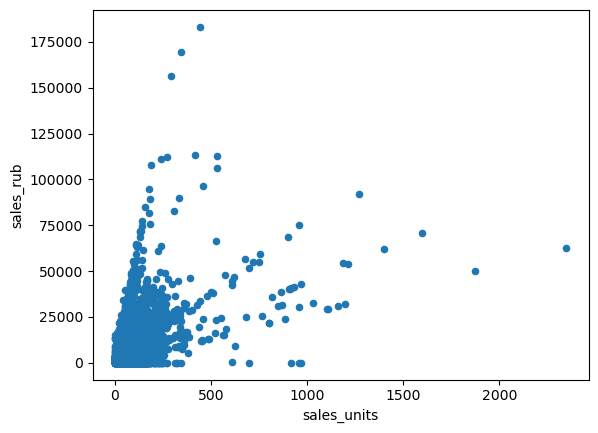

In [49]:
#scatter plot 'sales_units'/'sales_rub'
scatter_plot(activ_store, 'sales_rub', 'sales_units')

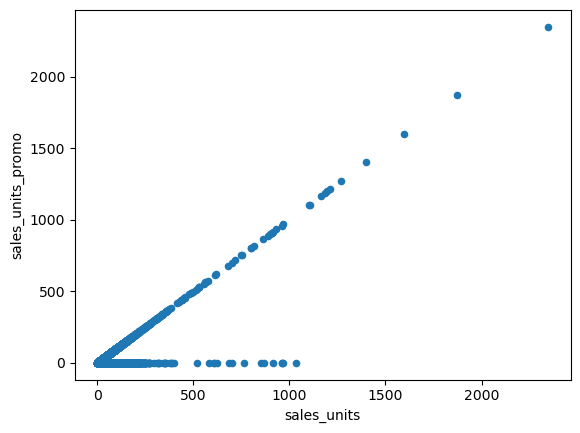

In [50]:
#scatter plot sales_units_promo/'sales_units'
scatter_plot(activ_store, 'sales_units_promo', 'sales_units')

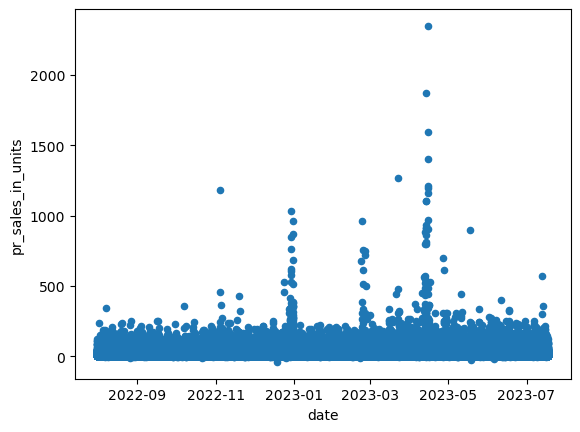

In [51]:
#scatter pr_sales_in_units/date
scatter_plot(data_train, 'pr_sales_in_units', 'date')

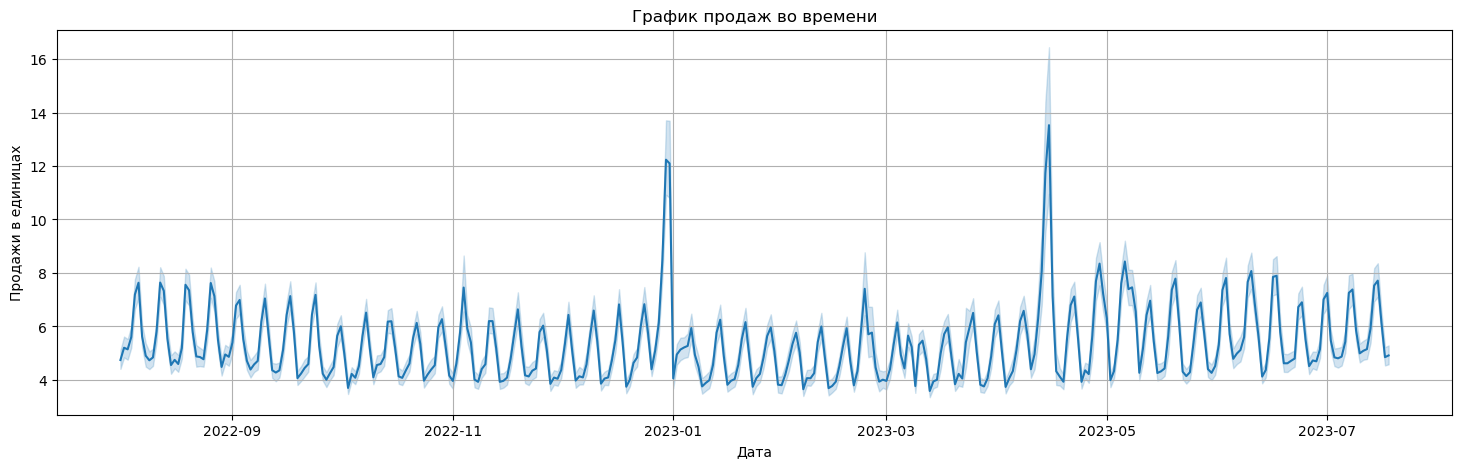

In [52]:
plt.figure(figsize=(18, 5))
sns.lineplot(data=activ_store, x=activ_store.index, y="sales_units")
#sns.lineplot(data=activ_store, x=activ_store.index, y="pr_sales_in_units_log")
plt.xlabel("Дата")
plt.ylabel("Продажи в единицах")
plt.title("График продаж во времени")
plt.grid(True)
plt.show()

### **Анализ временных рядов**

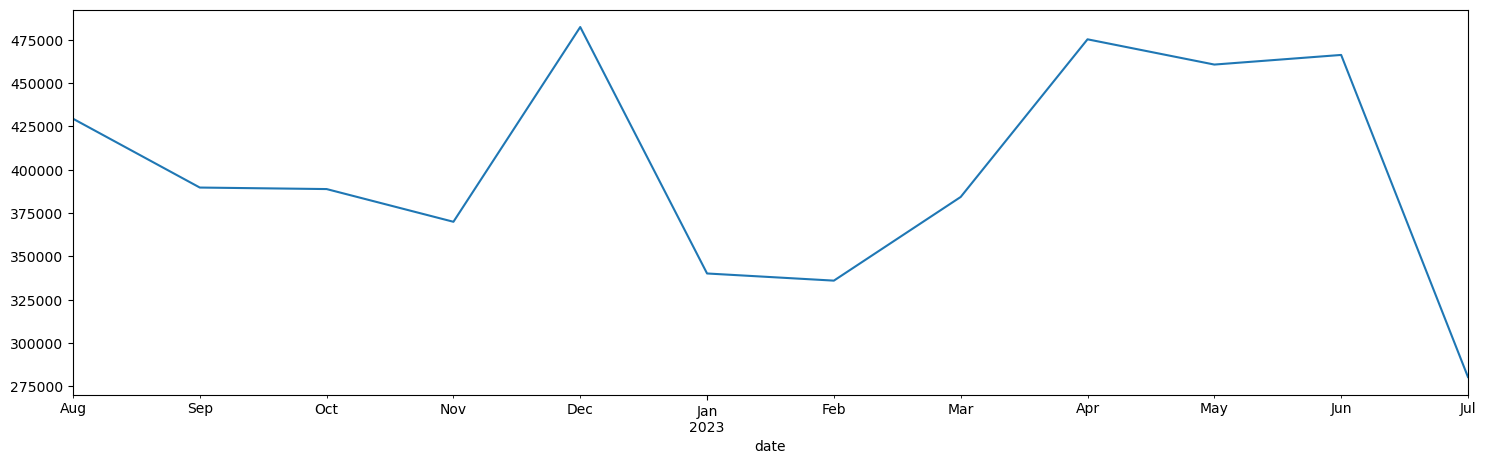

In [53]:
plt.figure(figsize=(18, 5))
activ_store_m = activ_store['sales_units'].resample('1M').sum()
#activ_store_ml = activ_store['pr_sales_in_units_log'].resample('1M').sum() #.mean()
#activ_store_ml.plot()
activ_store_m.plot();

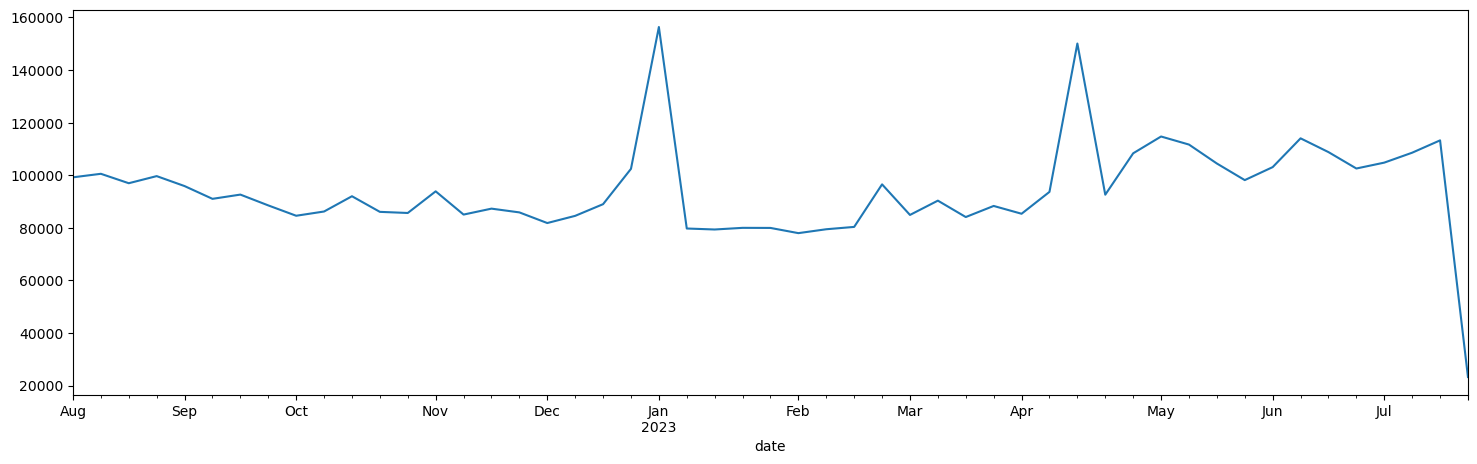

In [54]:
plt.figure(figsize=(18, 5))
data_w = activ_store['sales_units'].resample('1W').sum()
#data_wl = activ_store['pr_sales_in_units_log'].resample('1W').sum()
#data_w1.plot()
data_w.plot();

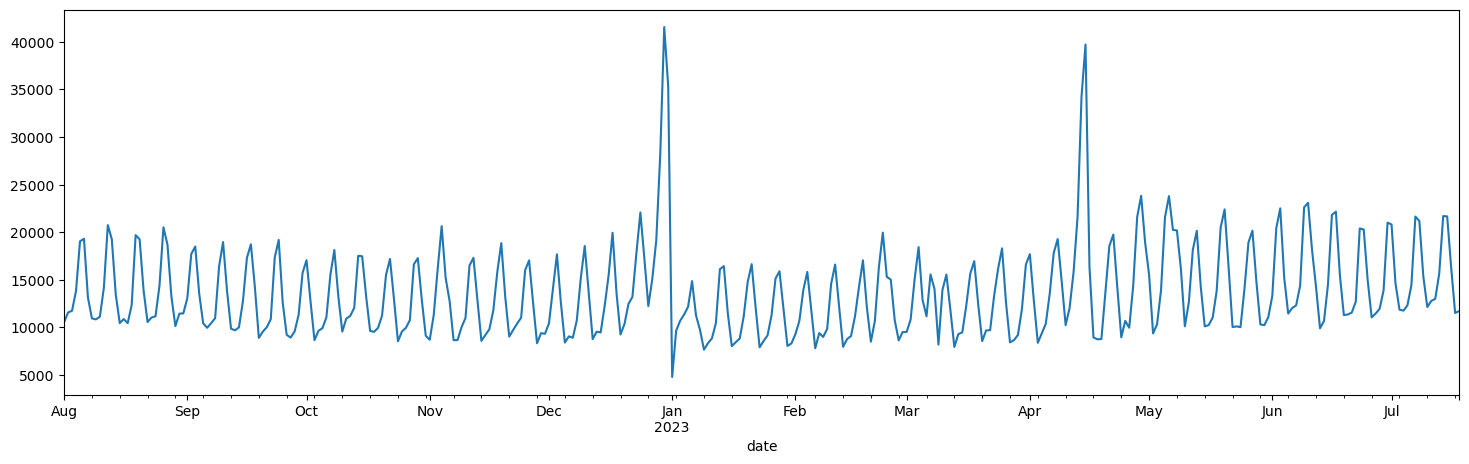

In [55]:
plt.figure(figsize=(18, 5))
#activ_store['pr_sales_in_units_res'] = activ_store['pr_sales_in_units'].resample('1D').sum()
#activ_store['pr_sales_in_units_lres'] = activ_store['pr_sales_in_units_log'].resample('1D').sum()
#activ_store['pr_sales_in_units_lres'].plot()
data_d = activ_store['sales_units'].resample('1D').sum()
data_d.plot();

### Изучим поведение ресемплированных данных за разные пероды времени

In [56]:
def res_graph (data, name, period):
    figsize = (18,5)
    data.plot(figsize=figsize)
    plt.title(f'{name} за {period}')
    plt.xlabel(f'{period}')
    plt.ylabel('Кол-во заказов')
    plt.show()

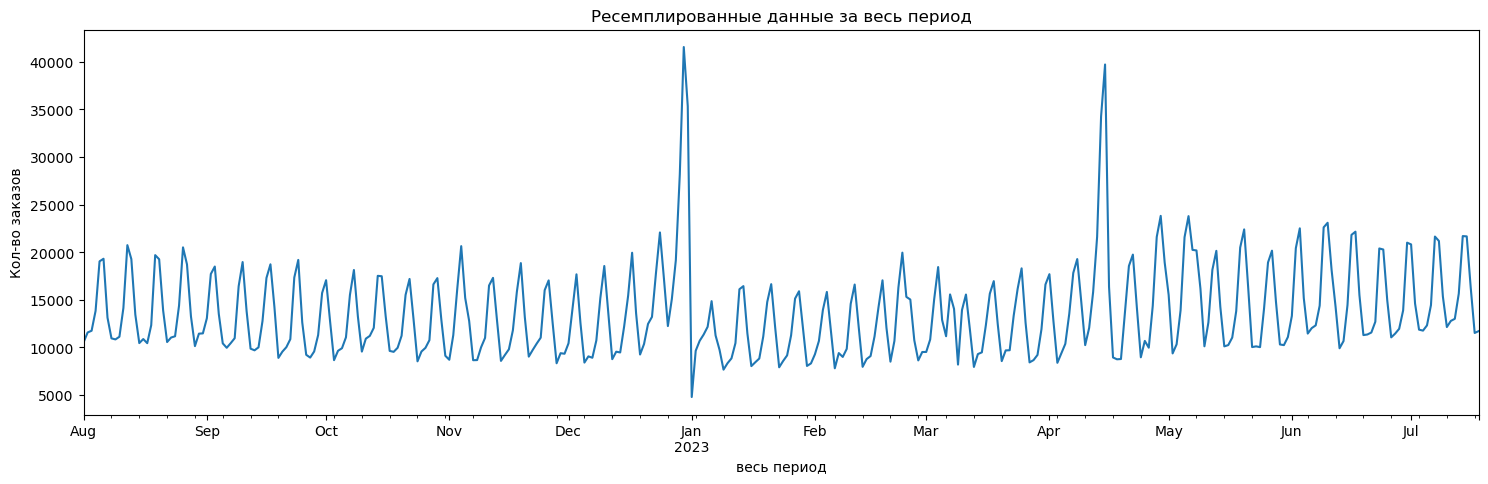

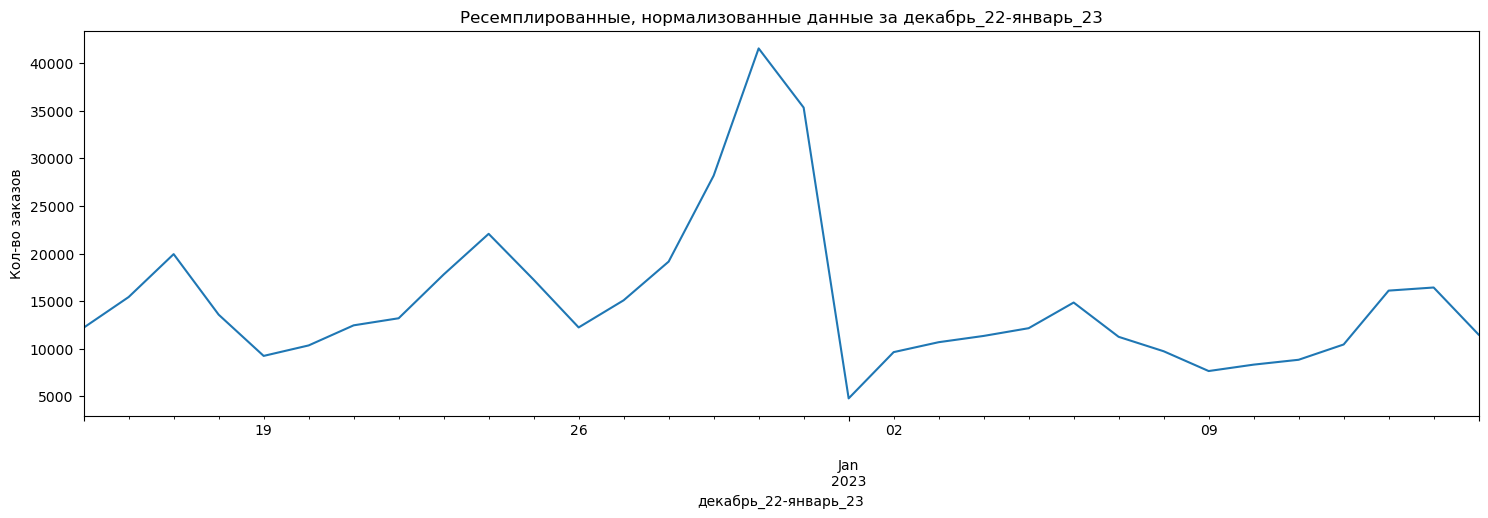

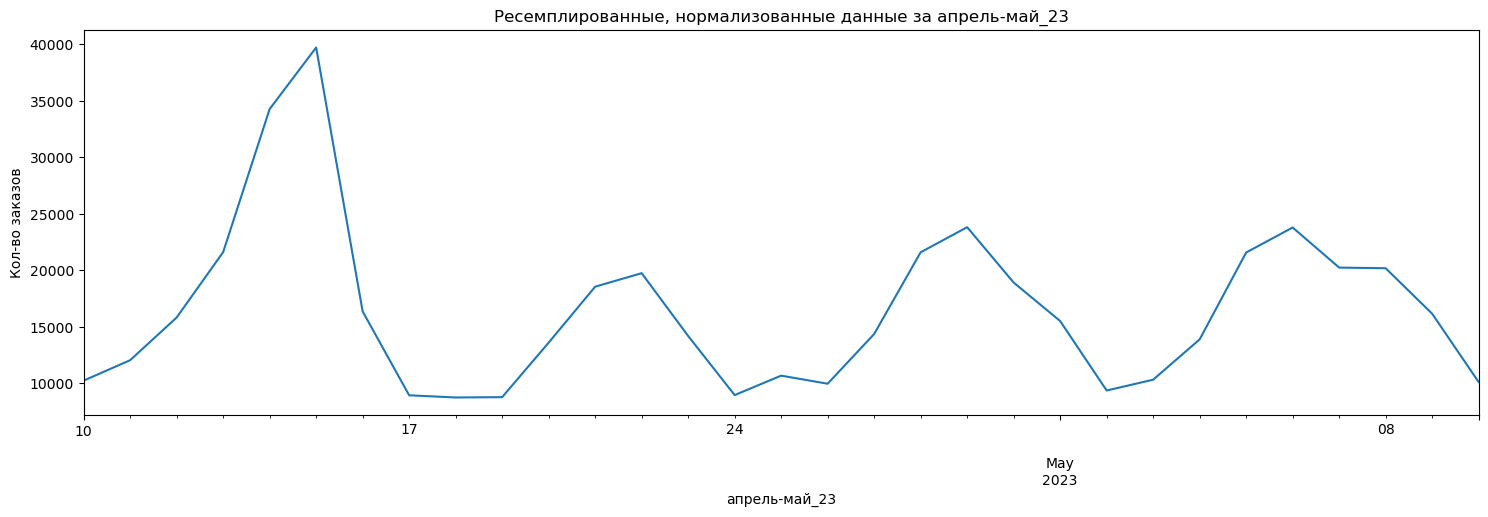

In [57]:
res_graph (data_d , 'Ресемплированные данные', 'весь период')
res_graph (data_d['2022-12-15':'2023-01-15'], 'Ресемплированные, нормализованные данные', 'декабрь_22-январь_23')
res_graph (data_d['2023-04-10':'2023-05-10'], 'Ресемплированные, нормализованные данные', 'апрель-май_23')

### Вывод
- после ресемплировании дат по количеству продаж, наблюдается явная сезонность, самый большой всплеск продаж - в декабре, а также май, июнь, что явно совпадает с государственными праздниками.
>  отмечены рост продаж (выбросы) в районе НГ (c 29 по 31 декабря), в апреле, видимо Пасха (13-15 апреля) и майских праздников (7-9 мая)
- обнаружена линейная зависимость общих продаж и продаж с промо
- для более точного прогноаз ресемплируем по дням

### Исследуем сезонность
- decomposed.trend — тренд
- decomposed.seasonal — сезонная составляющая
- decomposed.weights — веса, используются для уменьшения влияния выбросов

Text(0.5, 1.0, 'Weights')

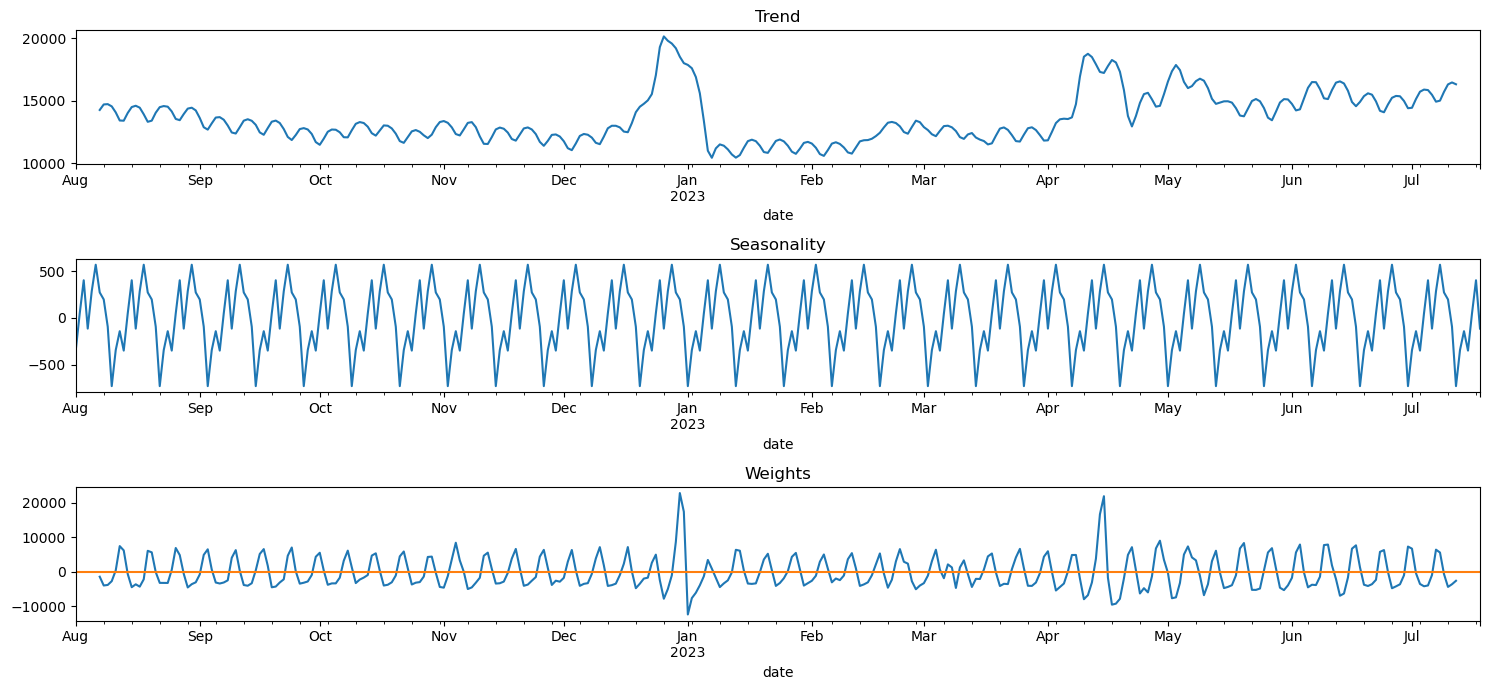

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(data_d, period=12) #activ_store['pr_sales_in_units']

plt.figure(figsize=(15, 7))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
decomposed.weights.plot(ax=plt.gca())
plt.title('Weights')

In [59]:
def seasonal_graph(data, date1, date2):
    #data_time = data.interpolate()
    decomposed = seasonal_decompose(data, period=12)
    plt.figure(figsize=(18, 5))
    plt.subplot(411)
    decomposed.seasonal[f'{date1}':f'{date2}'].plot(ax=plt.gca()) #2018-07-02
    plt.title('Seasonality')

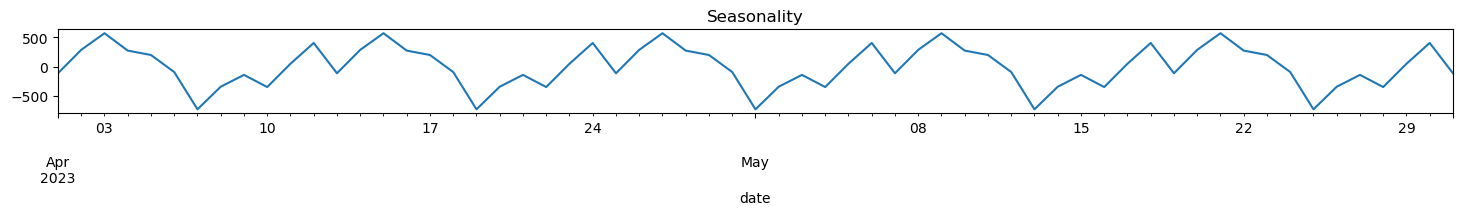

In [60]:
seasonal_graph(data_d, '2023-04-01', '2023-05-31')
#seasonal_graph(data_dl, '2023-04-01', '2023-05-10')

### Вывод
1. Тренд ровный, совсем немного растущий вверх, с явными выбросами.
2. При детальном рассмотрении графика сезонности наблюдается цикличность продаж в **12 дней**.

### Скользящее среднее и стандартное отклонение
**Стационарность ряда**\
Проверим на стационарность ряда.
Найдём скользящее **среднее** и  скользящее **стандартное отклонение** (англ. rolling standard deviation, rolling std) — стандартное отклонение по скользящему окну, размер окна возьмем равное 12:

In [61]:
def res_graph1 (data, name, name1, name2, name3, period, period1, period2):
    figsize = (18, 5)
    data[name1][period1:period2].plot(figsize=figsize, label=name1)
    data[name2][period1:period2].plot(figsize=figsize, label=name2)
    data[name3][period1:period2].plot(figsize=figsize, label=name3)
    plt.title(f'{name} за {period}')
    plt.xlabel(f'{period}')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [62]:
activ_store1 = activ_store.copy()
activ_store1['sales_units_res'] = activ_store1['sales_units'].resample('1D').sum()
activ_store1['mean'] = activ_store1['sales_units_res'].rolling(12).mean()
activ_store1['std'] = activ_store1['sales_units_res'].rolling(12).std()

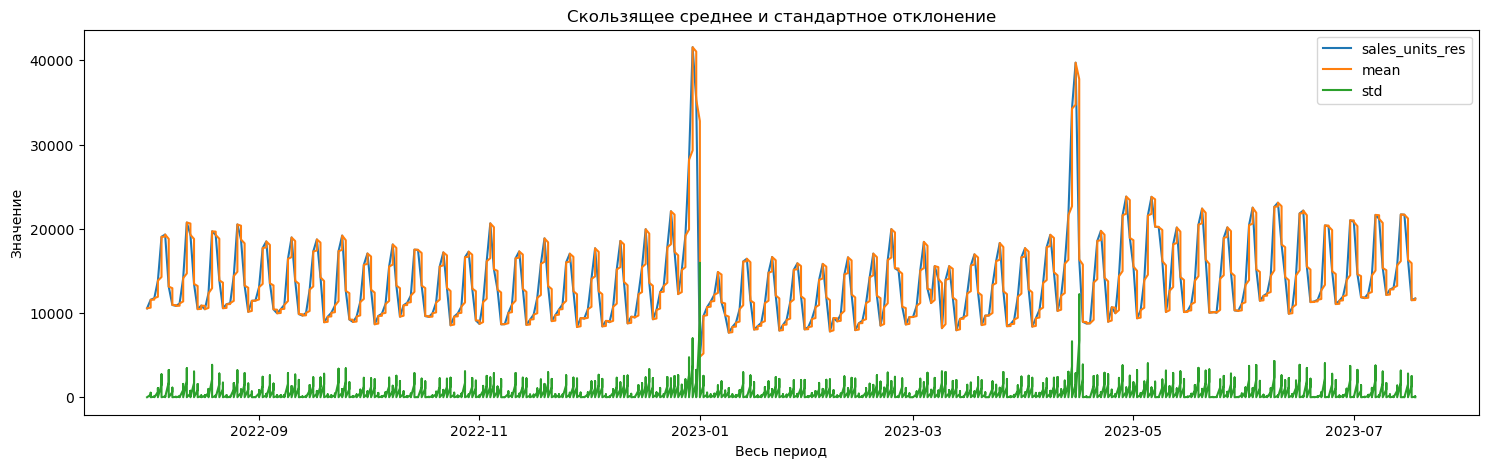

In [63]:
plt.figure(figsize=(18, 5))
plt.plot(activ_store1.index, activ_store1['sales_units_res'], label='sales_units_res')
plt.plot(activ_store1.index, activ_store1['mean'], label='mean')
plt.plot(activ_store1.index, activ_store1['std'], label='std')
plt.title('Скользящее среднее и стандартное отклонение')
plt.xlabel('Весь период')
plt.ylabel('Значение')
plt.legend()
plt.show()

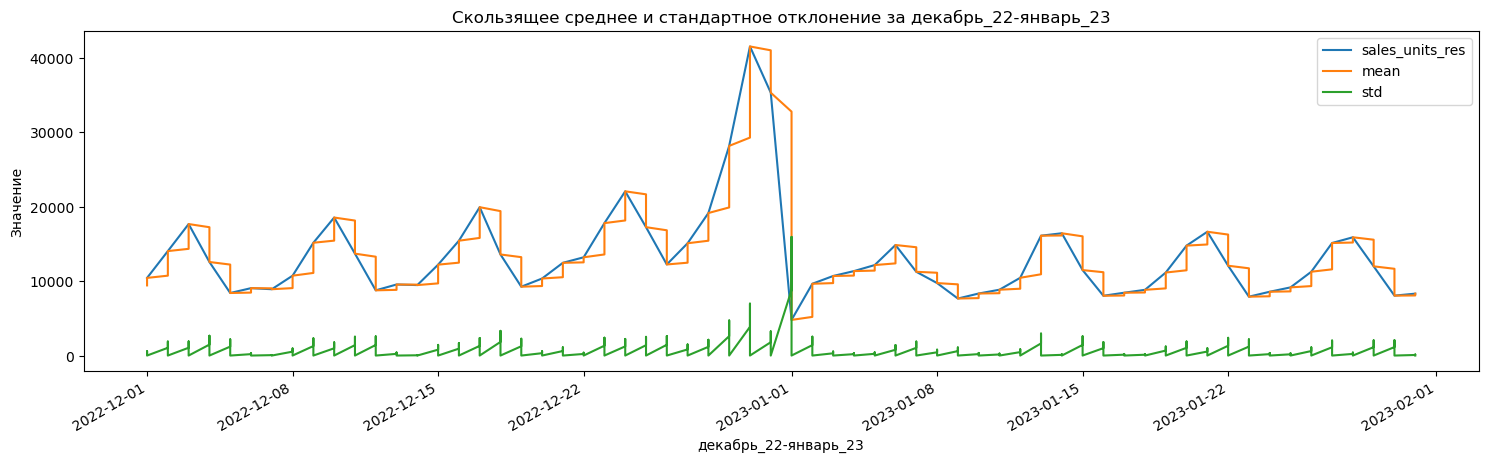

In [64]:
res_graph1 (activ_store1, 'Скользящее среднее и стандартное отклонение', \
            'sales_units_res', 'mean', 'std','декабрь_22-январь_23', '2022-12-01','2023-01-31')

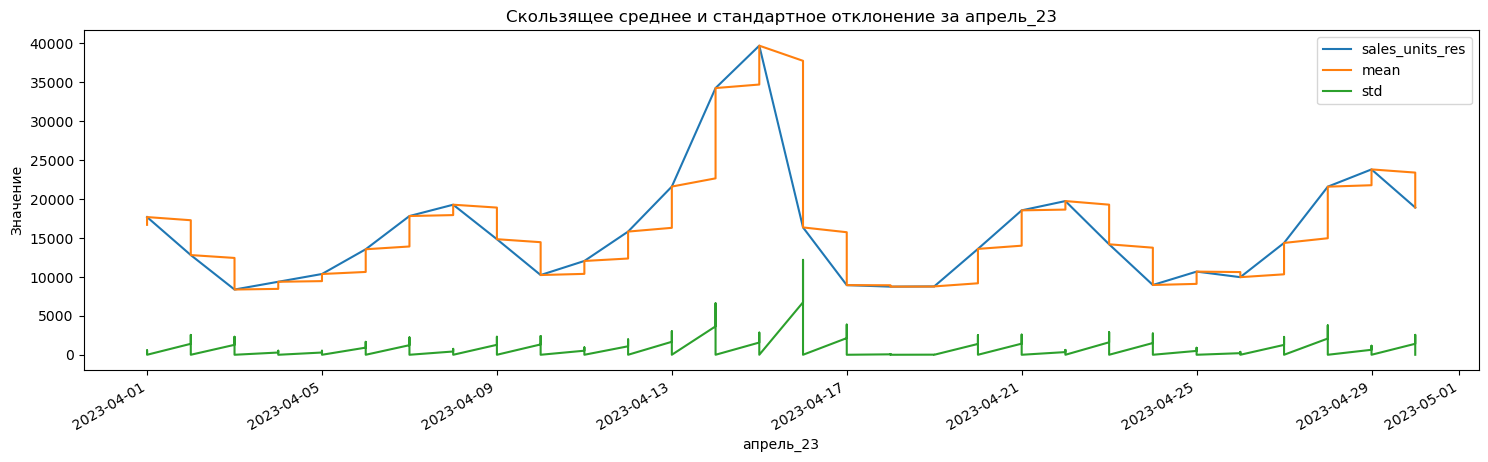

In [65]:
res_graph1 (activ_store1, 'Скользящее среднее и стандартное отклонение', \
            'sales_units_res', 'mean', 'std','апрель_23', '2023-04-01','2023-04-30')

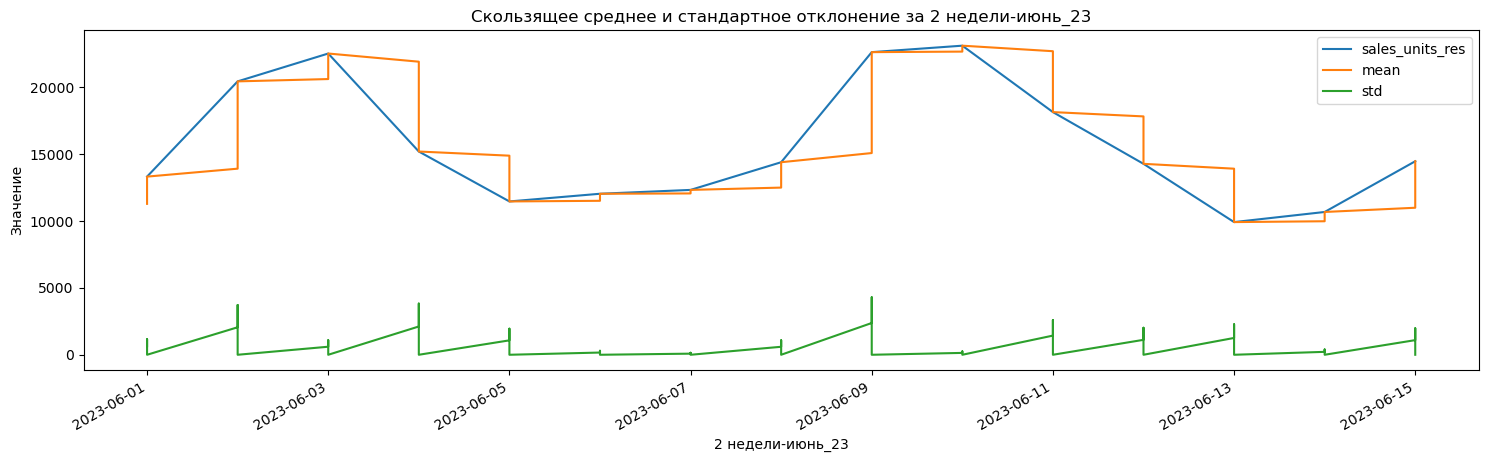

In [66]:
res_graph1 (activ_store1, 'Скользящее среднее и стандартное отклонение', \
            'sales_units_res', 'mean', 'std','2 недели-июнь_23', '2023-06-01','2023-06-15')

# Анализ данных, формирование признаков 
1. Удалим неинформативных признаков
2. Создадим дополнительные для обучения модели
3. Рузделим датасет на выборки для обучения и проверки модели
4. Проведм кодирование и масштабирование признаков, стандартизацию данных

## Анализ магазинов и товаров

In [67]:
# маркер товаров продающихся по штучно = 1, на вес = 0
activ_store['uom'] = activ_store['uom'].apply(lambda x: 0 if x != 1 else x)
express_info(activ_store, 'данных по объедененному датасету')

Информация о данных по объедененному датасету:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 882169 entries, 2022-08-01 to 2023-07-18
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   store              882169 non-null  object 
 1   sku                882169 non-null  object 
 2   sales_type         882169 non-null  int64  
 3   sales_units        882169 non-null  int32  
 4   sales_units_promo  882169 non-null  int32  
 5   sales_rub          882169 non-null  float64
 6   sales_rub_promo    882169 non-null  float64
 7   group              882169 non-null  object 
 8   category           882169 non-null  object 
 9   subcategory        882169 non-null  object 
 10  uom                882169 non-null  int64  
 11  division           882169 non-null  object 
 12  city               882169 non-null  object 
 13  type_format        882169 non-null  int64  
 14  loc                882169 non-null  i

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  f7e6c85504ce6e82442c770f7c8606f0   

                                         sku  sales_type  sales_units  \
date                                                                    
2022-08-01  4ce0eb956648ab3ff6bb0afa3158cc42           1            5   
2022-08-01  a26de72f8ea9889b7332ed5f940d8b62           0           21   
2022-08-01  eb341a778d385ad6ebe16e90efb48c08           1            1   
2022-08-01  dce1f234d6424aa61f8e7ce0baffd9af           0            6   
2022-08-01  79122a5063b8a1261b8b1f03509ef957           1            1   

            sales_units_promo  sales_rub  sales_rub_promo  \
date                                                        
2022-08-01                  0       79.0             79.0   
2022-08-01                  0      462.0              0.0   
2022-08-01                  1      154.0            154.0   
2022-08-01                  0      860.0              0.0   
2022-08-01                  1       57.0             57.0   

                                       group  \
date                                           
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   

                                    category  \
date                                           
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  28fc2782ea7ef51c1104ccf7b9bea13d   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  c559da2ba967eb820766939a658022c8   

                                 subcategory  ...  \
date                                          ...   
2022-08-01  8afe22eeb3f3f68de994a3c60388858c  ...   
2022-08-01  e06f5ed77191826c212c30722f2cc5a2  ...   
2022-08-01  b3e70d072fc648f6934c288e44f5c35e  ...   
2022-08-01  c01c475ac8d447730ece97d846cc4f25  ...   
2022-08-01  89b0107c6d0aca5f15fa7a715f9e06e5  ...   

                                    division  \
date                                           
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-01  da742b3cfca5388aaf9af28a726a3c30   
2022-08-01  da742b3cfca5388aaf9af28a726a3c30   
2022-08-01  32586311f16876abf92901085bd87b99   

                                        city type_format  loc  size  year  \
date                                                                        
2022-08-01  908c9a564a86426585b29f5335b619bc           1    1     8  2022   
2022-08-01  908c9a564a86426585b29f5335b619bc           1    1     8  2022   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f           1    1    12  2022   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f           1    1    12  2022   
2022-08-01  3202111cf90e7c816a472aaceb72b0df           1    1    12  2022   

            month  day  weekday  holiday  
date                                      
2022-08-01      1    1        1        0  
2022-08-01      1    1        1        0  
2022-08-01      1    1        1        0  
2022-08-01      1    1        1        0  
2022-08-01      1    1        1        0  

[5 rows x 21 columns]

### Тип продаж

In [68]:
# сделаем группировку и агрегацию по товарам
#grouped = activ_store.groupby('sku')
sales_type_sorted = activ_store.groupby('sku')[['sales_units', 'sales_units_promo']]\
                    .agg(['sum']).sort_values(by=('sales_units', 'sum'), ascending=False)
# добавим столбец с долей товаров с промо в процентах
sales_type_sorted['promo_part'] = ((sales_type_sorted[('sales_units_promo', 'sum')] / sales_type_sorted[('sales_units', 'sum')])).round(3)
sales_type_sorted.head()

sales_units sales_units_promo promo_part
                                         sum               sum           
sku                                                                      
62d4af457ba2540ce0898a211c0cd17a      125034             20982      0.168
ced0c1a84924c982a6403870c54b99ca      121620             40695      0.335
c0e3f3bd815a862433bc3399c487926b      117922             21899      0.186
4b083e10f6cd2f4360c5425d05be6386       91237             75979      0.833
d5bfeecaaa47887a4b92d17fa55c2e18       81877             10913      0.133

In [69]:
# сортируем по столбцу 'promo_part' в порядке убывания
promo_part_type_sorted = sales_type_sorted.sort_values(by='promo_part', ascending=False)
promo_part_type_sorted.head()

sales_units sales_units_promo promo_part
                                         sum               sum           
sku                                                                      
541748288e850fe30b1f42b558221fec           6                 6        1.0
40f8a2d253c36e0c0a6bacd8804d1e0c           2                 2        1.0
8a83012840a59f8e2edf61d9f7a38982          55                55        1.0
236f43797d8ff0ac7bacb3a6caeb7cd5           2                 2        1.0
4b720d804b03d973b2888fdb874c5670          11                11        1.0

### Добавим долю продаж промо в таблицу activ_store

In [70]:
activ_store['promo_part'] = activ_store['sku'].map(
    activ_store.groupby('sku')[['sales_units', 'sales_units_promo']]
    .agg({'sales_units': 'sum', 'sales_units_promo': 'sum'})
    .eval('sales_units_promo / sales_units').round(3))
activ_store.head()

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  f7e6c85504ce6e82442c770f7c8606f0   

                                         sku  sales_type  sales_units  \
date                                                                    
2022-08-01  4ce0eb956648ab3ff6bb0afa3158cc42           1            5   
2022-08-01  a26de72f8ea9889b7332ed5f940d8b62           0           21   
2022-08-01  eb341a778d385ad6ebe16e90efb48c08           1            1   
2022-08-01  dce1f234d6424aa61f8e7ce0baffd9af           0            6   
2022-08-01  79122a5063b8a1261b8b1f03509ef957           1            1   

            sales_units_promo  sales_rub  sales_rub_promo  \
date                                                        
2022-08-01                  0       79.0             79.0   
2022-08-01                  0      462.0              0.0   
2022-08-01                  1      154.0            154.0   
2022-08-01                  0      860.0              0.0   
2022-08-01                  1       57.0             57.0   

                                       group  \
date                                           
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   

                                    category  \
date                                           
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  28fc2782ea7ef51c1104ccf7b9bea13d   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  c559da2ba967eb820766939a658022c8   

                                 subcategory  ...  \
date                                          ...   
2022-08-01  8afe22eeb3f3f68de994a3c60388858c  ...   
2022-08-01  e06f5ed77191826c212c30722f2cc5a2  ...   
2022-08-01  b3e70d072fc648f6934c288e44f5c35e  ...   
2022-08-01  c01c475ac8d447730ece97d846cc4f25  ...   
2022-08-01  89b0107c6d0aca5f15fa7a715f9e06e5  ...   

                                        city type_format loc  size  year  \
date                                                                       
2022-08-01  908c9a564a86426585b29f5335b619bc           1   1     8  2022   
2022-08-01  908c9a564a86426585b29f5335b619bc           1   1     8  2022   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f           1   1    12  2022   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f           1   1    12  2022   
2022-08-01  3202111cf90e7c816a472aaceb72b0df           1   1    12  2022   

            month  day  weekday  holiday  promo_part  
date                                                  
2022-08-01      1    1        1        0       0.063  
2022-08-01      1    1        1        0       0.204  
2022-08-01      1    1        1        0       0.364  
2022-08-01      1    1        1        0       0.414  
2022-08-01      1    1        1        0       0.122  

[5 rows x 22 columns]

In [71]:
# общие продажи без выделения промо
pr_sales_type_id = activ_store[activ_store['sales_type'] != 1]
pr_sales_type_id.head()

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
2022-08-01  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   

                                         sku  sales_type  sales_units  \
date                                                                    
2022-08-01  a26de72f8ea9889b7332ed5f940d8b62           0           21   
2022-08-01  dce1f234d6424aa61f8e7ce0baffd9af           0            6   
2022-08-01  3f33017a9ce4fbff701facaeae7a7549           0            1   
2022-08-01  6d8bf88f6daf3b37de081afcf75ec6cf           0           17   
2022-08-01  517b5edeb76505d48bb945abce481959           0            1   

            sales_units_promo  sales_rub  sales_rub_promo  \
date                                                        
2022-08-01                  0      462.0              0.0   
2022-08-01                  0      860.0              0.0   
2022-08-01                  0       65.0              0.0   
2022-08-01                  0     1012.0              0.0   
2022-08-01                  0      214.0              0.0   

                                       group  \
date                                           
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   

                                    category  \
date                                           
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  1bc0249a6412ef49b07fe6f62e6dc8de   
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  186a157b2992e7daed3677ce8e9fe40f   

                                 subcategory  ...  \
date                                          ...   
2022-08-01  e06f5ed77191826c212c30722f2cc5a2  ...   
2022-08-01  c01c475ac8d447730ece97d846cc4f25  ...   
2022-08-01  ca34f669ae367c87f0e75dcae0f61ee5  ...   
2022-08-01  e06f5ed77191826c212c30722f2cc5a2  ...   
2022-08-01  aa36dc1d45661519a5bf923429776a83  ...   

                                        city type_format loc  size  year  \
date                                                                       
2022-08-01  908c9a564a86426585b29f5335b619bc           1   1     8  2022   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f           1   1    12  2022   
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586           1   2     8  2022   
2022-08-01  885fe656777008c335ac96072a45be15           1   1    12  2022   
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586           1   2     8  2022   

            month  day  weekday  holiday  promo_part  
date                                                  
2022-08-01      1    1        1        0       0.204  
2022-08-01      1    1        1        0       0.414  
2022-08-01      1    1        1        0       0.211  
2022-08-01      1    1        1        0       0.425  
2022-08-01      1    1        1        0       0.335  

[5 rows x 22 columns]

###  Оставим товары, которые продавались без промо

In [72]:
# удалим строки с промо, но только те, у которых есть продажи без промо
activ_store = activ_store[~(activ_store['sales_type'] == 1) & (activ_store['sku']\
             .isin(activ_store.loc[activ_store['sales_type'] == 0, 'sku']))]

# удалим столбцы
activ_store = activ_store.drop(['sales_type', 'sales_units_promo', 'sales_rub_promo'], axis=1)
activ_store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523495 entries, 2022-08-01 to 2023-07-18
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   store        523495 non-null  object 
 1   sku          523495 non-null  object 
 2   sales_units  523495 non-null  int32  
 3   sales_rub    523495 non-null  float64
 4   group        523495 non-null  object 
 5   category     523495 non-null  object 
 6   subcategory  523495 non-null  object 
 7   uom          523495 non-null  int64  
 8   division     523495 non-null  object 
 9   city         523495 non-null  object 
 10  type_format  523495 non-null  int64  
 11  loc          523495 non-null  int64  
 12  size         523495 non-null  int64  
 13  year         523495 non-null  int64  
 14  month        523495 non-null  int32  
 15  day          523495 non-null  int64  
 16  weekday      523495 non-null  int64  
 17  holiday      523495 non-null  int64  
 18  promo_pa

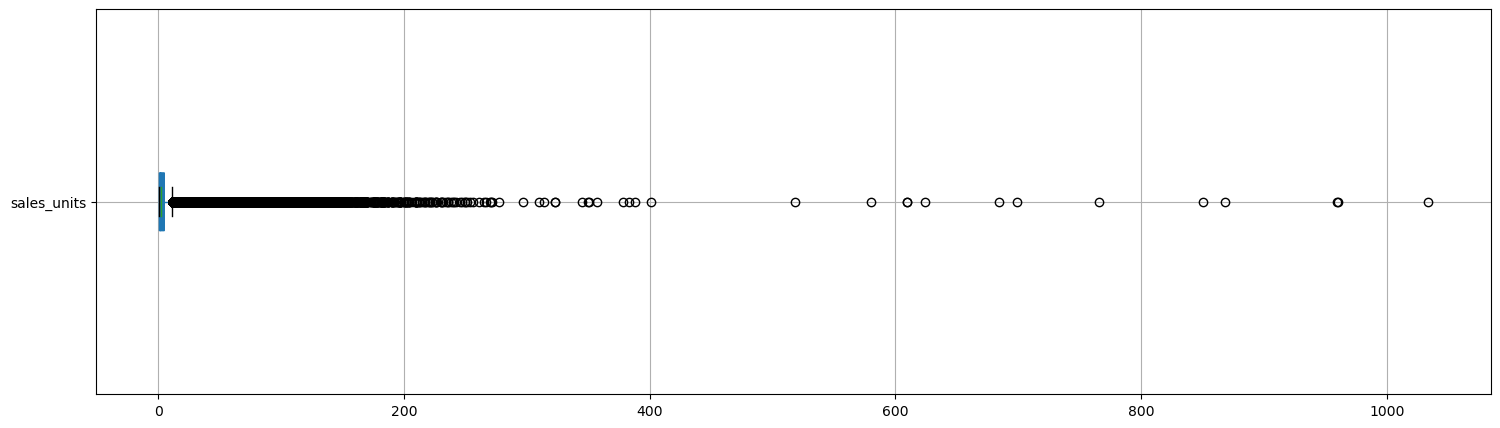

In [73]:
# общий боксплот
activ_store[['sales_units']].boxplot(figsize = (18, 5), vert=False, patch_artist=True, notch=True);

In [74]:
Q1 = activ_store.sales_units.quantile(0.25)
Q3 = activ_store.sales_units.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR

print('Верхняя граница:', upper)
print('Нижняя граница:', lower)

Верхняя граница: 11.0
Нижняя граница: -5.0


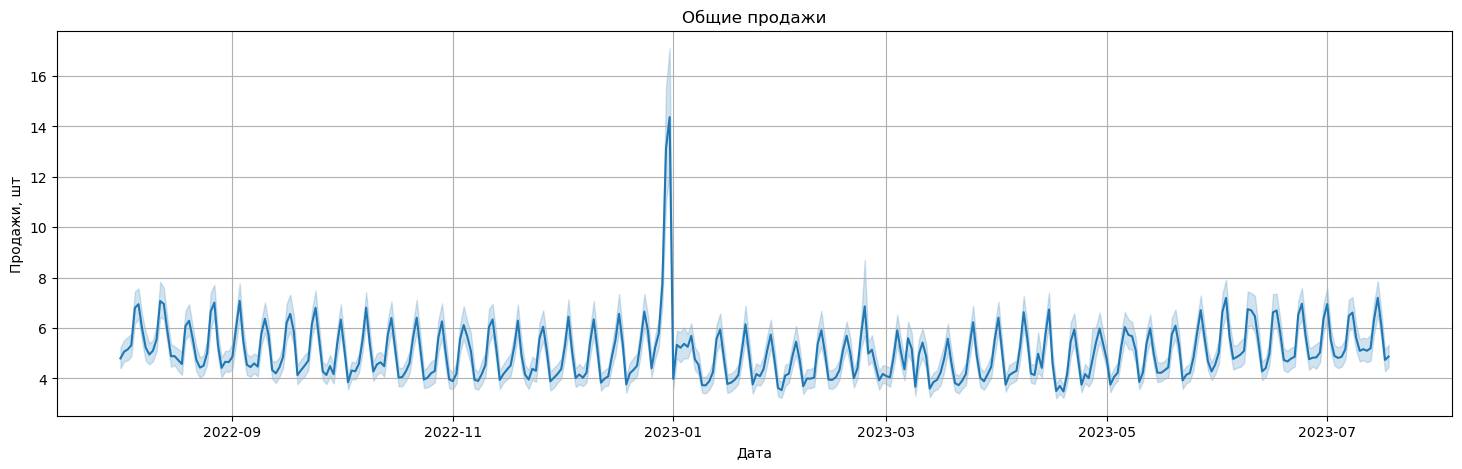

In [75]:
# общие продажи
plt.figure(figsize=(18, 5))
sns.lineplot(data=activ_store, x=activ_store.index, y="sales_units")
plt.xlabel("Дата")
plt.ylabel("Продажи, шт")
plt.title("Общие продажи")
plt.grid(True)
plt.show()

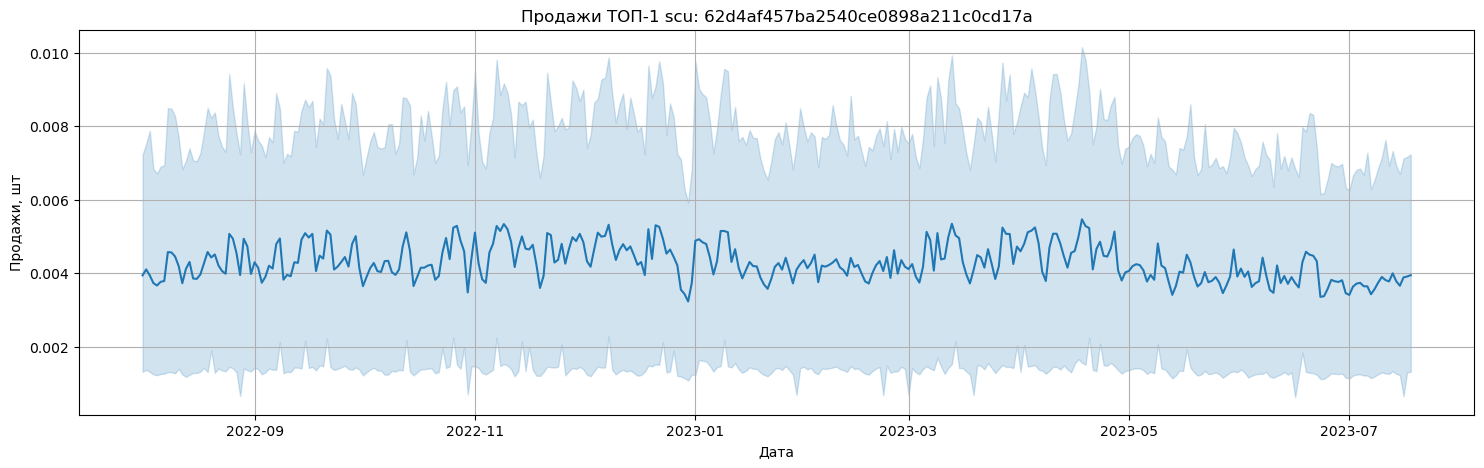

In [76]:
# самый популярный товар
plt.figure(figsize=(18, 5))
sns.lineplot(data=activ_store, x=activ_store.index, y=(activ_store['sku'] == '62d4af457ba2540ce0898a211c0cd17a'))
plt.xlabel("Дата")
plt.ylabel("Продажи, шт")
plt.title("Продажи ТОП-1 scu: 62d4af457ba2540ce0898a211c0cd17a")
plt.grid(True)
plt.show()

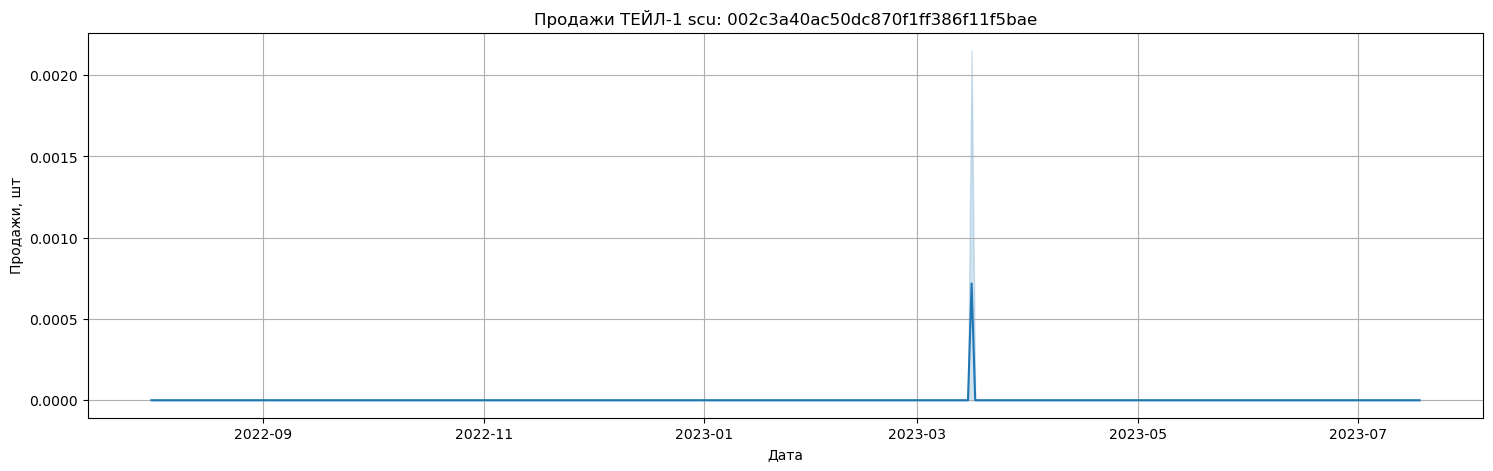

In [77]:
# самый не популярный товар
plt.figure(figsize=(18, 5))
sns.lineplot(data=activ_store, x=activ_store.index, y=(activ_store['sku'] == '002c3a40ac50dc870f1ff386f11f5bae'))
plt.xlabel("Дата")
plt.ylabel("Продажи, шт")
plt.title("Продажи ТЕЙЛ-1 scu: 002c3a40ac50dc870f1ff386f11f5bae")
plt.grid(True)
plt.show()

### Вывод
1. Продажи товаров `sales_in_units` включают в себя `_sales_units_promo`.
2. Создали новый признак доля продаж с промо `promo_part`.
3. Товары отмеченные, как "продажи с промо" удалили, т.к. это неявные дубли.
4. Признак `pr_uom_id` изменили маркеры товаров продающихся поштучно = 1, на вес = 0.
5. Оценили продажи популярных и непопулярных товаров.
6. Вероятно, имеет смысл строить отдельную модель для прогноза продаж товаров в праздники, так как некоторые товары продаются только в праздники.

## Создадим признак цена за единицу товара - 'price_units'

In [78]:
# цена за единицу товара
activ_store['price_units'] = (activ_store['sales_rub'] / activ_store['sales_units']).round(2)

### Нормализуем числовые признаки
- `sales_units`, `price_units`, `sales_rub`
- Сформируем целевой признак `'sales_units_stand'`

In [79]:
# нормализация продажи в штуках
sales_units_mean = activ_store.sales_units.mean()
sales_units_sd = activ_store.sales_units.std()

activ_store['sales_units_stand'] = (activ_store.sales_units - sales_units_mean) / sales_units_sd

In [80]:
# нормализация продажи в рублях
sales_rub_mean = activ_store.sales_rub.mean()
sales_rub_sd = activ_store.sales_rub.std()

activ_store['sales_rub_stand'] = (activ_store.sales_rub - sales_rub_mean) / sales_rub_sd

In [81]:
# нормализация доли промо продажи в рублях за штуку
price_units_mean = activ_store.price_units.mean()
price_units_sd = activ_store.price_units.std()

activ_store['price_units_stand'] = (activ_store.price_units - price_units_mean) / price_units_sd

In [82]:
activ_store.head()

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
2022-08-01  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   

                                         sku  sales_units  sales_rub  \
date                                                                   
2022-08-01  a26de72f8ea9889b7332ed5f940d8b62           21      462.0   
2022-08-01  dce1f234d6424aa61f8e7ce0baffd9af            6      860.0   
2022-08-01  3f33017a9ce4fbff701facaeae7a7549            1       65.0   
2022-08-01  6d8bf88f6daf3b37de081afcf75ec6cf           17     1012.0   
2022-08-01  517b5edeb76505d48bb945abce481959            1      214.0   

                                       group  \
date                                           
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   

                                    category  \
date                                           
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  1bc0249a6412ef49b07fe6f62e6dc8de   
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  186a157b2992e7daed3677ce8e9fe40f   

                                 subcategory  uom  \
date                                                
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-01  c01c475ac8d447730ece97d846cc4f25    1   
2022-08-01  ca34f669ae367c87f0e75dcae0f61ee5    0   
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-01  aa36dc1d45661519a5bf923429776a83    1   

                                    division  \
date                                           
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-01  da742b3cfca5388aaf9af28a726a3c30   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130   

                                        city  ...  year  month  day  weekday  \
date                                          ...                              
2022-08-01  908c9a564a86426585b29f5335b619bc  ...  2022      1    1        1   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f  ...  2022      1    1        1   
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...  2022      1    1        1   
2022-08-01  885fe656777008c335ac96072a45be15  ...  2022      1    1        1   
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...  2022      1    1        1   

            holiday  promo_part  price_units  sales_units_stand  \
date                                                              
2022-08-01        0       0.204        22.00           1.458935   
2022-08-01        0       0.414       143.33           0.083276   
2022-08-01        0       0.211        65.00          -0.375277   
2022-08-01        0       0.425        59.53           1.092093   
2022-08-01        0       0.335       214.00          -0.375277   

            sales_rub_stand  price_units_stand  
date                                            
2022-08-01        -0.045953          -0.895639  
2022-08-01         0.338182           0.062514  
2022-08-01        -0.429122          -0.556065  
2022-08-01         0.484887          -0.599262  
2022-08-01        -0.285313           0.620601  

[5 rows x 23 columns]

### Вывод
- создали новый признак - цена за единицу товара`'price_units'`.
- нормализовали признаки `sales_units`, `price_units`, `sales_rub`, в том числе `'sales_units_stand' - целевой`, `'price_units_stand'`, `'sales_rub_stand'`

## Исследуем числовые и категориальные признаки

* Выделим числовые признаки и сохраним их в отдельную таблицу numeric
* Выделим категориальные признаки и сохраним их в отдельную таблицу categorical

In [83]:
numeric = activ_store[activ_store.select_dtypes(include='number').columns]
numeric.head(2)

sales_units  sales_rub  uom  type_format  loc  size  year  month  \
date                                                                           
2022-08-01           21      462.0    0            1    1     8  2022      1   
2022-08-01            6      860.0    1            1    1    12  2022      1   

            day  weekday  holiday  promo_part  price_units  sales_units_stand  \
date                                                                            
2022-08-01    1        1        0       0.204        22.00           1.458935   
2022-08-01    1        1        0       0.414       143.33           0.083276   

            sales_rub_stand  price_units_stand  
date                                            
2022-08-01        -0.045953          -0.895639  
2022-08-01         0.338182           0.062514

In [84]:
categorical = activ_store[activ_store.select_dtypes(include='object').columns]
categorical.head(2)

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   

                                         sku  \
date                                           
2022-08-01  a26de72f8ea9889b7332ed5f940d8b62   
2022-08-01  dce1f234d6424aa61f8e7ce0baffd9af   

                                       group  \
date                                           
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   

                                    category  \
date                                           
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   

                                 subcategory  \
date                                           
2022-08-01  e06f5ed77191826c212c30722f2cc5a2   
2022-08-01  c01c475ac8d447730ece97d846cc4f25   

                                    division                              city  
date                                                                            
2022-08-01  429a86ff6336c144ddaf6144f52ab52c  908c9a564a86426585b29f5335b619bc  
2022-08-01  da742b3cfca5388aaf9af28a726a3c30  b8b4b727d6f5d1b61fff7be687f7970f

In [85]:
categorical.columns.tolist()

['store', 'sku', 'group', 'category', 'subcategory', 'division', 'city']

In [86]:
categorical_columns = categorical.columns.tolist()

for column in categorical_columns:
    unique_count = activ_store[column].sort_values().nunique()
    print(f'Количество уникальных значений в столбце {column}',':', unique_count)

Количество уникальных значений в столбце store : 9
Количество уникальных значений в столбце sku : 1946
Количество уникальных значений в столбце group : 9
Количество уникальных значений в столбце category : 43
Количество уникальных значений в столбце subcategory : 167
Количество уникальных значений в столбце division : 5
Количество уникальных значений в столбце city : 6


In [87]:
numeric_columns = numeric.columns.tolist()

for column in numeric_columns:
    unique_count = activ_store[column].sort_values().nunique()
    print(f'Количество уникальных значений в столбце {column}',':', unique_count)

Количество уникальных значений в столбце sales_units : 261
Количество уникальных значений в столбце sales_rub : 8059
Количество уникальных значений в столбце uom : 2
Количество уникальных значений в столбце type_format : 3
Количество уникальных значений в столбце loc : 3
Количество уникальных значений в столбце size : 5
Количество уникальных значений в столбце year : 2
Количество уникальных значений в столбце month : 12
Количество уникальных значений в столбце day : 31
Количество уникальных значений в столбце weekday : 7
Количество уникальных значений в столбце holiday : 2
Количество уникальных значений в столбце promo_part : 702
Количество уникальных значений в столбце price_units : 23634
Количество уникальных значений в столбце sales_units_stand : 261
Количество уникальных значений в столбце sales_rub_stand : 8059
Количество уникальных значений в столбце price_units_stand : 23634


### Продажи по дням в шт и рублях

In [88]:
# список для построения графиков
sales_graph_list = ['sales_units','price_units','sales_rub']

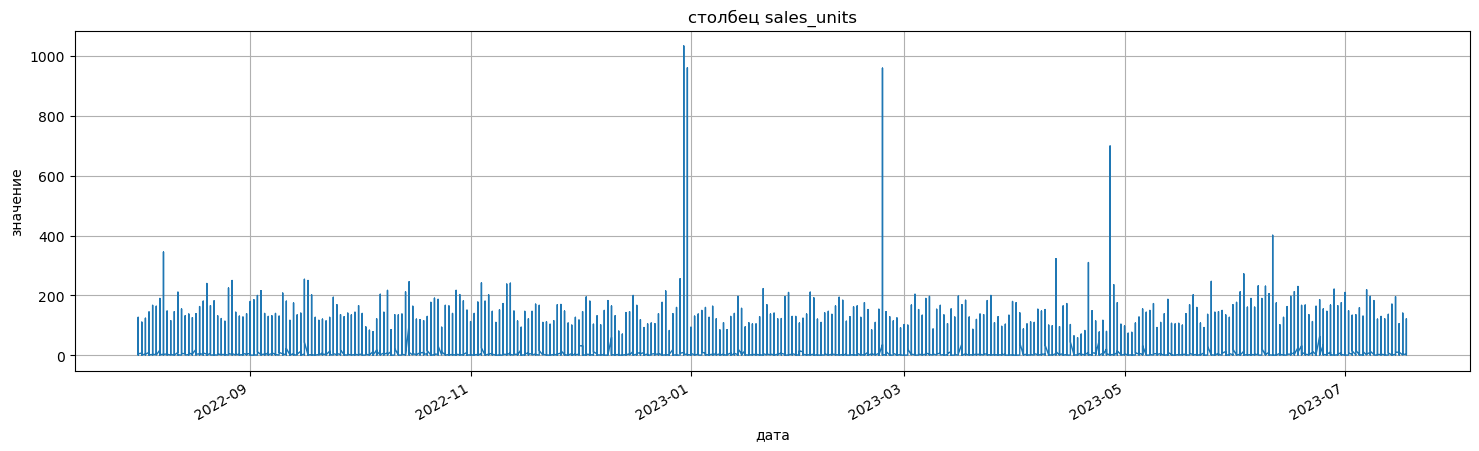

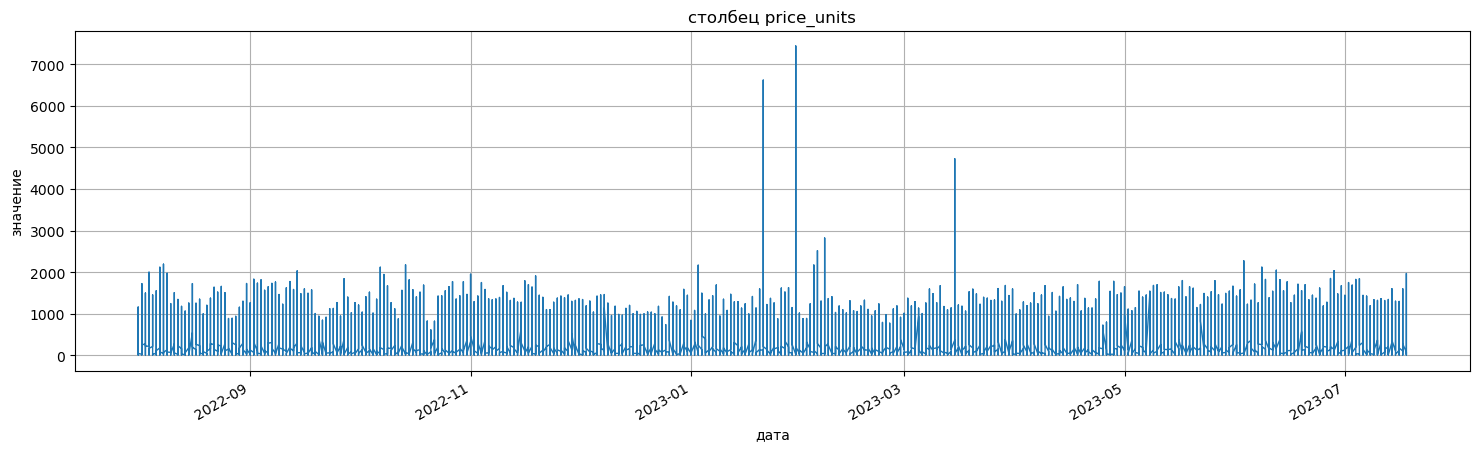

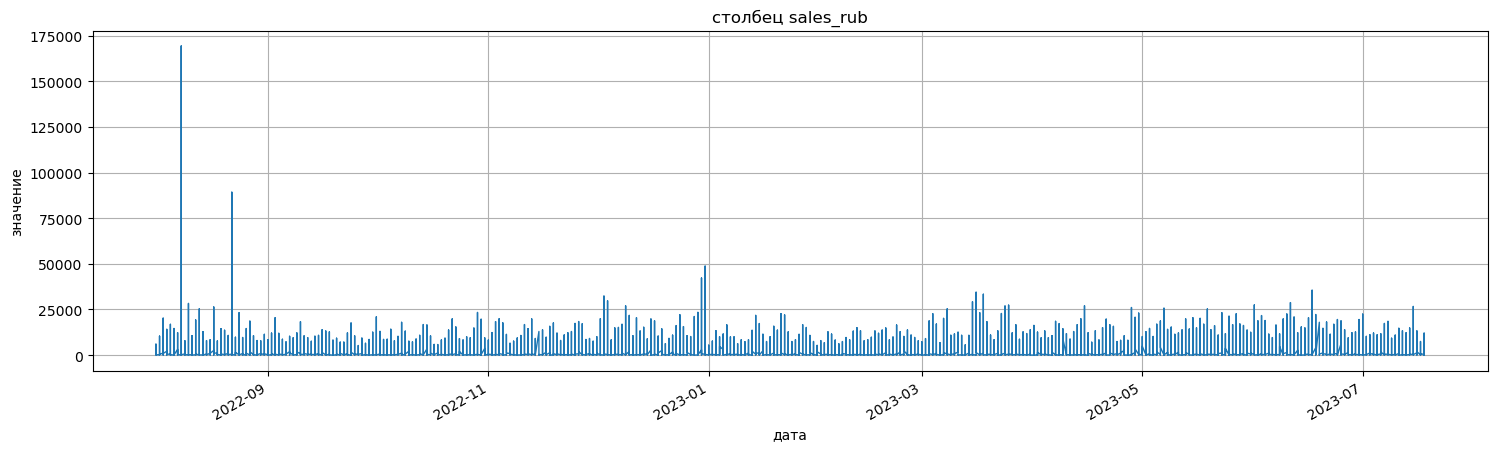

In [89]:
# цикл для построения графиков
for column in sales_graph_list:
    plt.figure(figsize=(18, 5))
    activ_store[column].plot(label=column, figsize=(18, 5), linewidth=1)
    #sns.lineplot(x=df.index, y=df[column])
    plt.title((f'столбец {column}'))
    plt.xlabel('дата')
    plt.ylabel('значение')
    plt.grid(True)
    plt.show()

In [90]:
activ_store[['price_units', 'sales_units', 'sales_rub']].describe().style.format("{:,.2f}")

### Построим корреляционную матрицу для смешанного набора признаков

In [91]:
numeric.columns

Index(['sales_units', 'sales_rub', 'uom', 'type_format', 'loc', 'size', 'year',
       'month', 'day', 'weekday', 'holiday', 'promo_part', 'price_units',
       'sales_units_stand', 'sales_rub_stand', 'price_units_stand'],
      dtype='object')

In [92]:
categorical.columns

Index(['store', 'sku', 'group', 'category', 'subcategory', 'division', 'city'], dtype='object')

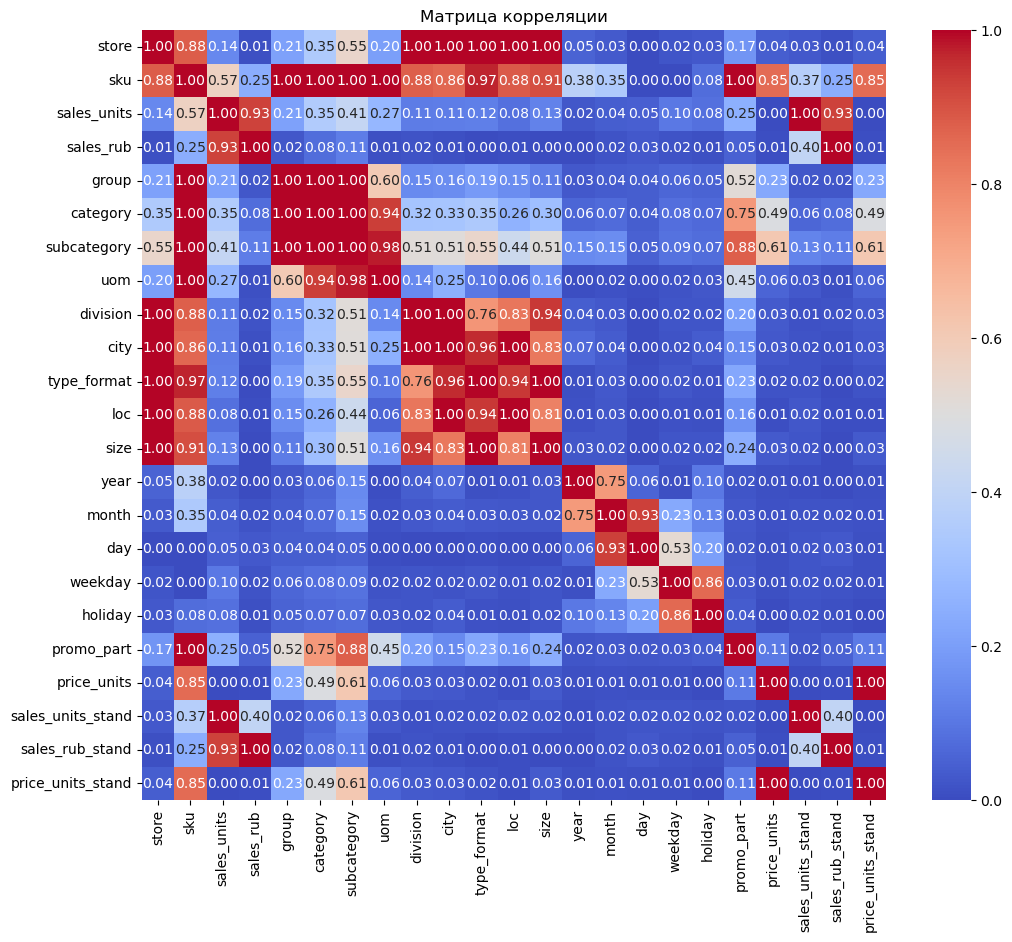

CPU times: total: 19.4 s
Wall time: 39.3 s


In [93]:
%%time
interval_cols = ['promo_part', 'price_units', 'sales_units_stand',
                 'sales_rub', 'sales_rub_stand', 'price_units_stand']
phik_matrix = activ_store.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

## Добавим новые признаки:
- по типам товаров
- по типам магазинов
- доли продаж товаров по категориям в шт и руб

### Продажи товаров по категориям

### Группы товаров

In [94]:
# сделаем группировку и агрегацию по группам
grouped = activ_store.groupby('group')
pr_group_id = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
pr_group_id_sorted = pr_group_id.sort_values(by=('sales_rub', 'sum'), ascending=False)
pr_group_id_sorted

sales_units    sales_rub
                                         sum          sum
group                                                    
aab3238922bcc25a6f606eb525ffdc56      784443  116420699.0
c74d97b01eae257e44aa9d5bade97baf     1429696   68732479.0
6512bd43d9caa6e02c990b0a82652dca      251265   42369796.0
c51ce410c124a10e0db5e4b97fc2af39       67576   20630412.0
c20ad4d76fe97759aa27a0c99bff6710      114730   14681318.0
32bb90e8976aab5298d5da10fe66f21d        7900    2084682.0
1ff1de774005f8da13f42943881c655f        9549    1808134.0
98f13708210194c475687be6106a3b84         432      49854.0
3c59dc048e8850243be8079a5c74d079          28       1607.0

### Категории товаров

In [95]:
# сделаем группировку и агрегацию по подкатегориям
grouped = activ_store.groupby('category')
pr_cat_id = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
pr_cat_id_sorted = pr_cat_id.sort_values(by=('sales_rub', 'sum'), ascending=False)
pr_cat_id_sorted.head()

sales_units   sales_rub
                                         sum         sum
category                                                
28fc2782ea7ef51c1104ccf7b9bea13d      264803  47632120.0
c559da2ba967eb820766939a658022c8      896770  34467161.0
9701a1c165dd9420816bfec5edd6c2b1      199439  29745727.0
e58cc5ca94270acaceed13bc82dfedf7      146346  22770289.0
186a157b2992e7daed3677ce8e9fe40f      152587  21213278.0

### Подкатегории товаров

In [96]:
# сделаем группировку и агрегацию по подкатегориям
grouped = activ_store.groupby('subcategory')
pr_subcat_id = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
pr_subcat_id_sorted = pr_subcat_id.sort_values(by=('sales_rub', 'sum'), ascending=False)
pr_subcat_id_sorted.head()

sales_units   sales_rub
                                         sum         sum
subcategory                                             
aa36dc1d45661519a5bf923429776a83      145260  20155924.0
c93c26cd49ea08e6b8984351d4164575       82805  16039692.0
7a8aebb07d6e8ba9da453ec0f3f359a4       54720  12285820.0
d29b5ce9c2883f0b7e90f79071a2ca82       58444  11153125.0
e06f5ed77191826c212c30722f2cc5a2      327731  10998687.0

### Добавим доли продаж товаров по категориям в шт и руб

In [97]:
#напишем функцию по формированию признаков долей
def sales_share(data, name_col, name, columns_to_process):
    for column in columns_to_process:
        unique_counts = data.groupby(column)['sku'].nunique()# количество уникальных товаров в каждой категории/типа магазина
        sales_sum = data.groupby(column)[name_col].sum() # сумма продаж для каждой категории/типа магазина
        sku_sales = unique_counts / sales_sum # доля продаж уникальных товаров в каждой категории/типа магазина
        # доля продаж уникальных товаров в таблицу
        data[f'sales_share_{column}_{name}'] = data[column].map(sku_sales)
    return data

In [98]:
# перебор по категориям
columns_to_process = ['group', 'category', 'subcategory']
#Добавим доли продаж товаров по категориям в шт
activ_store = sales_share(activ_store, 'sales_units', 'unit', columns_to_process)
#Добавим доли продаж товаров по категориям в rub
activ_store = sales_share(activ_store, 'sales_rub', 'rub', columns_to_process)
activ_store.head(3)

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   

                                         sku  sales_units  sales_rub  \
date                                                                   
2022-08-01  a26de72f8ea9889b7332ed5f940d8b62           21      462.0   
2022-08-01  dce1f234d6424aa61f8e7ce0baffd9af            6      860.0   
2022-08-01  3f33017a9ce4fbff701facaeae7a7549            1       65.0   

                                       group  \
date                                           
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   

                                    category  \
date                                           
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  1bc0249a6412ef49b07fe6f62e6dc8de   

                                 subcategory  uom  \
date                                                
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-01  c01c475ac8d447730ece97d846cc4f25    1   
2022-08-01  ca34f669ae367c87f0e75dcae0f61ee5    0   

                                    division  \
date                                           
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-01  da742b3cfca5388aaf9af28a726a3c30   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130   

                                        city  ...  price_units  \
date                                          ...                
2022-08-01  908c9a564a86426585b29f5335b619bc  ...        22.00   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f  ...       143.33   
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...        65.00   

            sales_units_stand  sales_rub_stand  price_units_stand  \
date                                                                
2022-08-01           1.458935        -0.045953          -0.895639   
2022-08-01           0.083276         0.338182           0.062514   
2022-08-01          -0.375277        -0.429122          -0.556065   

            sales_share_group_unit  sales_share_category_unit  \
date                                                            
2022-08-01                0.000516                   0.000270   
2022-08-01                0.000885                   0.001078   
2022-08-01                0.000516                   0.000665   

            sales_share_subcategory_unit  sales_share_group_rub  \
date                                                              
2022-08-01                      0.000101               0.000011   
2022-08-01                      0.001175               0.000006   
2022-08-01                      0.000724               0.000011   

            sales_share_category_rub  sales_share_subcategory_rub  
date                                                               
2022-08-01                  0.000007                     0.000003  
2022-08-01                  0.000007                     0.000010  
2022-08-01                  0.000016                     0.000019  

[3 rows x 29 columns]

In [99]:
# оценим доли продаж scu в группах товаров и сортируем в порядке убывания долей
activ_store.groupby('group')[['sku', 'sales_share_group_unit']].apply(lambda x: x.sort_values(ascending=False, by='sales_share_group_unit'))

sku  \
group                            date                                           
1ff1de774005f8da13f42943881c655f 2022-08-01  a97a38f8bcdf16c8d11f2010bb409da5   
                                 2023-03-13  70f6f2543cdaf69fb2f89317e23a0929   
                                 2023-03-12  70f6f2543cdaf69fb2f89317e23a0929   
                                 2023-03-12  45bd6ffd65dc1b68ea59c9ec5f4590f9   
                                 2023-03-12  09b6f670e4f5648aef001e34f7945990   
...                                                                       ...   
c74d97b01eae257e44aa9d5bade97baf 2022-11-25  d5bfeecaaa47887a4b92d17fa55c2e18   
                                 2022-11-25  cff633e270708ced01bc585eb1421667   
                                 2022-11-25  1edb148e94ceddc5abaa91ad4814a737   
                                 2022-11-25  22988026fe85fde60d8bf777ab6bc3b4   
                                 2023-07-18  083e7f594409e946662187b13b13868a   

                                             sales_share_group_unit  
group                            date                                
1ff1de774005f8da13f42943881c655f 2022-08-01                0.003665  
                                 2023-03-13                0.003665  
                                 2023-03-12                0.003665  
                                 2023-03-12                0.003665  
                                 2023-03-12                0.003665  
...                                                             ...  
c74d97b01eae257e44aa9d5bade97baf 2022-11-25                0.000516  
                                 2022-11-25                0.000516  
                                 2022-11-25                0.000516  
                                 2022-11-25                0.000516  
                                 2023-07-18                0.000516  

[523495 rows x 2 columns]

In [100]:
# оценим доли продаж scu в группах товаров и сортируем в порядке убывания долей
activ_store.groupby('group')[['sku', 'sales_share_group_rub']].apply(lambda x: x.sort_values(ascending=False, by='sales_share_group_rub'))

sku  \
group                            date                                           
1ff1de774005f8da13f42943881c655f 2022-08-01  a97a38f8bcdf16c8d11f2010bb409da5   
                                 2023-03-13  70f6f2543cdaf69fb2f89317e23a0929   
                                 2023-03-12  70f6f2543cdaf69fb2f89317e23a0929   
                                 2023-03-12  45bd6ffd65dc1b68ea59c9ec5f4590f9   
                                 2023-03-12  09b6f670e4f5648aef001e34f7945990   
...                                                                       ...   
c74d97b01eae257e44aa9d5bade97baf 2022-11-25  d5bfeecaaa47887a4b92d17fa55c2e18   
                                 2022-11-25  cff633e270708ced01bc585eb1421667   
                                 2022-11-25  1edb148e94ceddc5abaa91ad4814a737   
                                 2022-11-25  22988026fe85fde60d8bf777ab6bc3b4   
                                 2023-07-18  083e7f594409e946662187b13b13868a   

                                             sales_share_group_rub  
group                            date                               
1ff1de774005f8da13f42943881c655f 2022-08-01               0.000019  
                                 2023-03-13               0.000019  
                                 2023-03-12               0.000019  
                                 2023-03-12               0.000019  
                                 2023-03-12               0.000019  
...                                                            ...  
c74d97b01eae257e44aa9d5bade97baf 2022-11-25               0.000011  
                                 2022-11-25               0.000011  
                                 2022-11-25               0.000011  
                                 2022-11-25               0.000011  
                                 2023-07-18               0.000011  

[523495 rows x 2 columns]

In [101]:
# группы товара
activ_store.pivot_table(index=['group'],
               values=['sales_rub'],
               aggfunc=[np.mean, len, sum]
              ).sort_values(by=('sum', 'sales_rub'), ascending=False)

mean       len          sum
                                   sales_rub sales_rub    sales_rub
group                                                              
aab3238922bcc25a6f606eb525ffdc56  602.457522    193243  116420699.0
c74d97b01eae257e44aa9d5bade97baf  284.318100    241745   68732479.0
6512bd43d9caa6e02c990b0a82652dca  990.457618     42778   42369796.0
c51ce410c124a10e0db5e4b97fc2af39  943.881228     21857   20630412.0
c20ad4d76fe97759aa27a0c99bff6710  868.768448     16899   14681318.0
32bb90e8976aab5298d5da10fe66f21d  750.966138      2776    2084682.0
1ff1de774005f8da13f42943881c655f  450.008462      4018    1808134.0
98f13708210194c475687be6106a3b84  294.994083       169      49854.0
3c59dc048e8850243be8079a5c74d079  160.700000        10       1607.0

### Проанализируем общие продажи по группам, по категориям и по подкатегориям в штуках

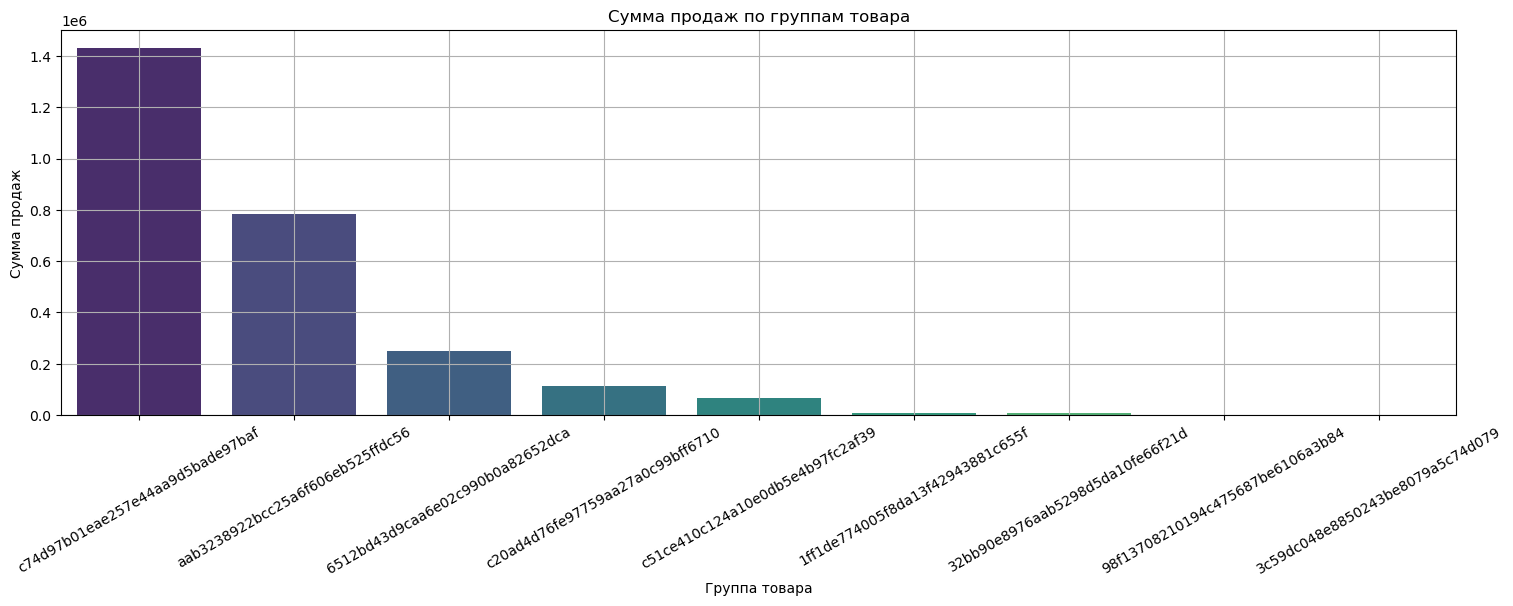

In [102]:
# группы
pivot_table = activ_store.pivot_table(index=['group'],
                                      values=['sales_units'],
                                      aggfunc=[np.mean, len, sum]
                                      ).sort_values(by=('sum', 'sales_units'), ascending=False)
plt.figure(figsize=(18, 5))
sns.barplot(x=pivot_table.index, y=('sum', 'sales_units'), data=pivot_table, palette="viridis")

plt.title('Сумма продаж по группам товара')
plt.xlabel('Группа товара')
plt.ylabel('Сумма продаж')
plt.xticks(rotation=30)
plt.grid(True)

plt.show()

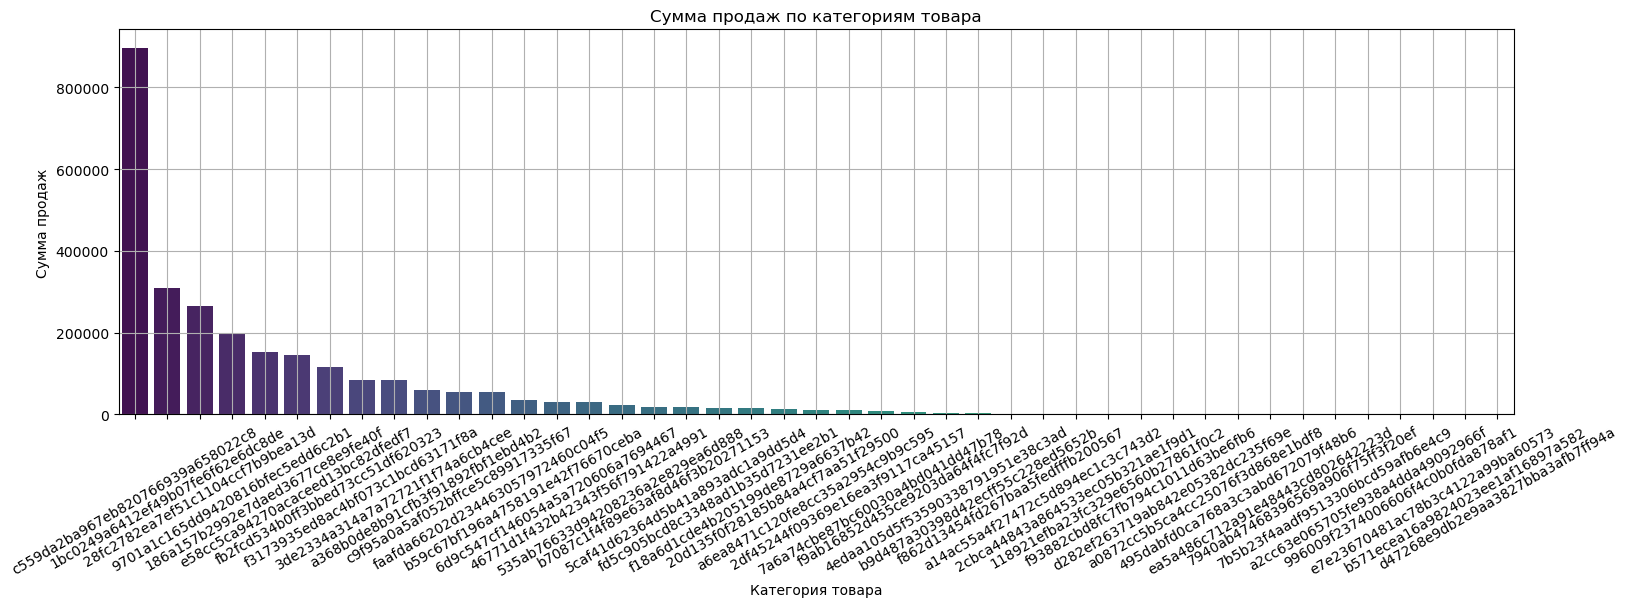

In [103]:
# категории
pivot_table = activ_store.pivot_table(index=['category'],
                                      values=['sales_units'],
                                      aggfunc=[np.mean, len, sum]
                                      ).sort_values(by=('sum', 'sales_units'), ascending=False)
plt.figure(figsize=(18, 5))
sns.barplot(x=pivot_table.index, y=('sum', 'sales_units'), data=pivot_table, palette="viridis")

plt.title('Сумма продаж по категориям товара')
plt.xlabel('Категория товара')
plt.ylabel('Сумма продаж')
plt.xticks(rotation=30)
plt.grid(True)

plt.show()

In [104]:
# подкатегории
activ_store.pivot_table(index=['subcategory'],
               values=['sales_units'],
               aggfunc=[np.mean, len, sum]
              ).sort_values(by=('len', 'sales_units'), ascending=False).round()

mean         len         sum
                                 sales_units sales_units sales_units
subcategory                                                         
e06f5ed77191826c212c30722f2cc5a2        15.0       22428      327731
c01c475ac8d447730ece97d846cc4f25         3.0       16697       50206
ca34f669ae367c87f0e75dcae0f61ee5         4.0       16074       59411
8afe22eeb3f3f68de994a3c60388858c         3.0       15637       41027
7a8aebb07d6e8ba9da453ec0f3f359a4         4.0       15230       54720
...                                      ...         ...         ...
16d222a5fac9d8d7a3ee790f9ee46af5        19.0           2          38
c6e0511febe73b0911198c2b79d27ec0         1.0           2           2
ce08fca7bb075a8acc942e3f575346b0         2.0           2           5
f586ff8517e916e591bc2afd108b732b         3.0           1           3
a4244e0fd6c2493b1393823d1abaec5b         2.0           1           2

[167 rows x 3 columns]

### Продажи по типам магазинов

In [105]:
type_graph_list = ['type_format','loc','size','uom']

type_format              proportion
type_format            
1              0.939216
2              0.051097
4              0.009687


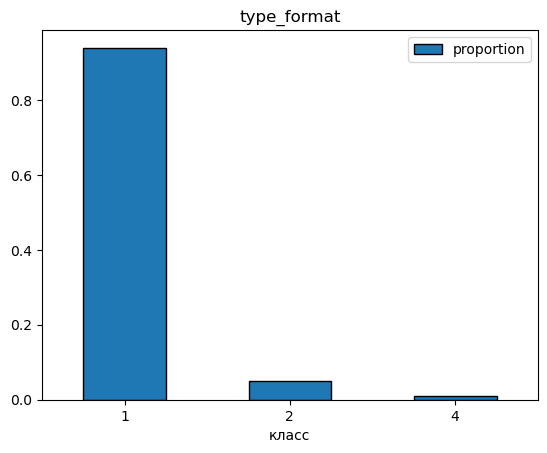

loc      proportion
loc            
1      0.803798
2      0.186516
3      0.009687


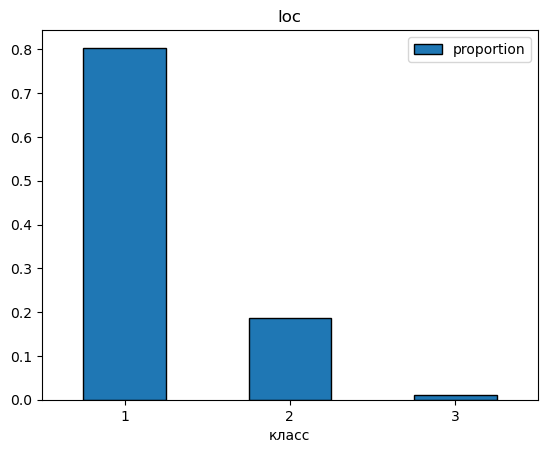

size       proportion
size            
12      0.565579
8       0.373637
28      0.051097
20      0.007958
19      0.001729


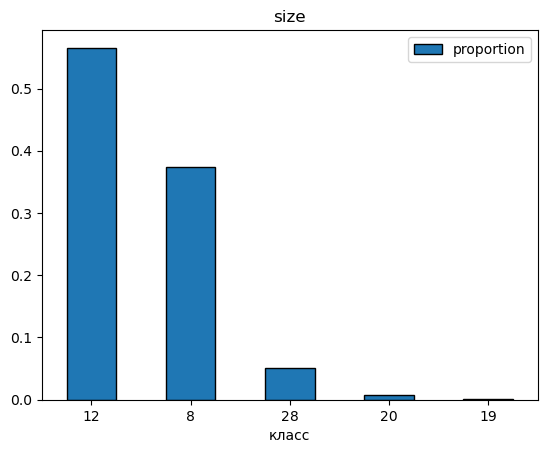

uom      proportion
uom            
1      0.619303
0      0.380697


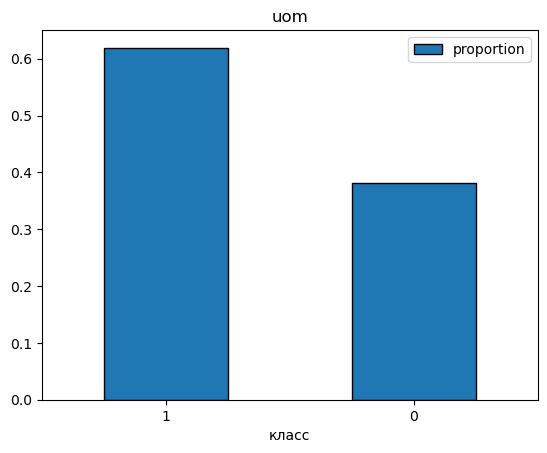

In [106]:
for column in type_graph_list:
    class_frequency = activ_store[column].value_counts(normalize= True).to_frame()
    print(f'{column}',class_frequency)
    ax = class_frequency.plot(kind='bar', rot=0, edgecolor='black', linewidth=1)
    ax.set_xlabel('класс')
    ax.set_title(f'{column}')
    plt.show()

### Суммы продаж магазинов в рублях

In [107]:
activ_store.pivot_table(index=['sku'],
               values=['sales_rub'],
               aggfunc=[np.mean, len, sum]
              ).sort_values(by=('len', 'sales_rub'), ascending=False).sort_values(by=('sum', 'sales_rub'), ascending=False).round()

mean       len         sum
                                 sales_rub sales_rub   sales_rub
sku                                                             
c0e3f3bd815a862433bc3399c487926b    7560.0      1639  12390585.0
c7b711619071c92bef604c7ad68380dd    2609.0      1843   4807865.0
67797f1f0f02ec5ccd5e3abd2d4e5b81    2603.0      1691   4401548.0
ced0c1a84924c982a6403870c54b99ca    1318.0      2061   2716498.0
4695acecbef4734453cf9bc0be67ffe4    3830.0       684   2620036.0
...                                    ...       ...         ...
ac3a9c95767b01bdb4bdfdbec835b24b      33.0         1        33.0
9859c09401e6a000fb502c507afa866c      30.0         1        30.0
48bb4fc3b178d1131f477296faebf138      30.0         1        30.0
672981bfc413b6063b1dcbb8c1a39e61      27.0         1        27.0
ed13e9303dfe637db6d4a327534f72b4      16.0         1        16.0

[1946 rows x 3 columns]

### Продажи по локациям

In [108]:
# сделаем группировку и агрегацию по локациям магазинов
grouped = activ_store.groupby('loc')
st_type_loc = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
st_type_loc_sorted = st_type_loc.sort_values(by=('sales_units', 'sum'), ascending=False)
st_type_loc_sorted

sales_units    sales_rub
            sum          sum
loc                         
1       2103264  211728824.0
2        551323   54449786.0
3         11032     600371.0

### Продажи по размерам

In [109]:
# сделаем группировку и агрегацию по размерам магазинов
grouped = activ_store.groupby('size')
st_type_size = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
st_type_size_sorted = st_type_size.sort_values(by=('sales_units', 'sum'), ascending=False)
st_type_size_sorted

sales_units    sales_rub
             sum          sum
size                         
12       1452064  148260566.0
8        1121617  112459747.0
28         80906    5458297.0
20          9298     520370.0
19          1734      80001.0

### Продажи по форматам

In [110]:
# сделаем группировку и агрегацию по локациям магазинов
grouped = activ_store.groupby('type_format')
st_type_format = grouped[['sales_units', 'sales_rub']].agg(['sum'])
# сорртировака по сумме
st_type_format_sorted = st_type_format.sort_values(by=('sales_units', 'sum'), ascending=False)
st_type_format_sorted

sales_units    sales_rub
                    sum          sum
type_format                         
1               2573681  260720313.0
2                 80906    5458297.0
4                 11032     600371.0

### Добавим признаки - **доли продаж** в штуках и в рублях для каждого **sku**

In [111]:
# перебор по магазинам
columns_to_process_sku = ['store', 'sku','year', 'weekday', 'month', 'holiday',
                              'division', 'city', 'type_format', 'loc','size']
#Добавим доли продаж товаров по магазинам в шт
activ_store = sales_share(activ_store, 'sales_units', 'sku_unit', columns_to_process_sku)
#Добавим доли продаж товаров по магазинам в rub
activ_store = sales_share(activ_store, 'sales_rub', 'sku_rub', columns_to_process_sku)

In [112]:
activ_store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523495 entries, 2022-08-01 to 2023-07-18
Data columns (total 51 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   store                             523495 non-null  object 
 1   sku                               523495 non-null  object 
 2   sales_units                       523495 non-null  int32  
 3   sales_rub                         523495 non-null  float64
 4   group                             523495 non-null  object 
 5   category                          523495 non-null  object 
 6   subcategory                       523495 non-null  object 
 7   uom                               523495 non-null  int64  
 8   division                          523495 non-null  object 
 9   city                              523495 non-null  object 
 10  type_format                       523495 non-null  int64  
 11  loc                               52

### Магазины
Сформируем списки:
- магазинов с самыми большими продажами
- всех магазинов
- словарь для уникальных sku товаров для каждого магазина
- словарь для уникальных sku для каждой категории


In [113]:
# scu и магазин с самими высокими продажами в шт
#sku_st = activ_store[(activ_store['st_id'] == 'c81e728d9d4c2f636f067f89cc14862c') & (activ_store['pr_sku_id'] == '62d4af457ba2540ce0898a211c0cd17a')]
#sku_st.reset_index()

In [114]:
unique_count = activ_store['sku'].nunique()
print(f"Количество уникальных значений в столбце 'sku': {unique_count}")

Количество уникальных значений в столбце 'sku': 1946


In [115]:
top_st_list = activ_store['store'].unique().tolist()
top_st_list

['c81e728d9d4c2f636f067f89cc14862c',
 '42a0e188f5033bc65bf8d78622277c4e',
 '16a5cdae362b8d27a1d8f8c7b78b4330',
 'fa7cdfad1a5aaf8370ebeda47a1ff1c3',
 'f7e6c85504ce6e82442c770f7c8606f0',
 '6364d3f0f495b6ab9dcf8d3b5c6e0b01',
 '1ecfb463472ec9115b10c292ef8bc986',
 'bd470ca955d9497bbcb808e59952fffc',
 '53e19f3dbb211f20b20b45668303c1b6']

In [116]:
# словарь для уникальных sku для каждого магазина
unique_sku_counts = {}
for st in top_st_list:
    filtered_st = activ_store[activ_store['store'] == st]
    unique_count = filtered_st['sku'].nunique()
    unique_sku_counts[st] = unique_count

# сртируем словарь по убыванию
sorted_unique_sku_counts = dict(sorted(unique_sku_counts.items(), key=lambda item: item[1], reverse=True))

for st, unique_count in sorted_unique_sku_counts.items():
    print(f"Количество уникальных sku для магазина {st}: {unique_count}")


Количество уникальных sku для магазина c81e728d9d4c2f636f067f89cc14862c: 1046
Количество уникальных sku для магазина 42a0e188f5033bc65bf8d78622277c4e: 995
Количество уникальных sku для магазина 16a5cdae362b8d27a1d8f8c7b78b4330: 935
Количество уникальных sku для магазина f7e6c85504ce6e82442c770f7c8606f0: 920
Количество уникальных sku для магазина 6364d3f0f495b6ab9dcf8d3b5c6e0b01: 850
Количество уникальных sku для магазина fa7cdfad1a5aaf8370ebeda47a1ff1c3: 788
Количество уникальных sku для магазина 1ecfb463472ec9115b10c292ef8bc986: 248
Количество уникальных sku для магазина 53e19f3dbb211f20b20b45668303c1b6: 100
Количество уникальных sku для магазина bd470ca955d9497bbcb808e59952fffc: 66


In [117]:
list_cat = activ_store['category'].unique().tolist()

In [118]:
# словарь для уникальных sku для каждой категории
unique_sku_counts = {}

for cat in list_cat:
    filtered_cat = activ_store[activ_store['category'] == cat]
    unique_count = filtered_cat['sku'].nunique()
    unique_sku_counts[cat] = unique_count

# сортируем словарь по убыванию
sorted_unique_sku_counts = dict(sorted(unique_sku_counts.items(), key=lambda item: item[1], reverse=True))

for cat, unique_count in sorted_unique_sku_counts.items():
    print(f"Количество уникальных sku для category = {cat}: {unique_count}")

Количество уникальных sku для category = c559da2ba967eb820766939a658022c8: 242
Количество уникальных sku для category = 9701a1c165dd9420816bfec5edd6c2b1: 215
Количество уникальных sku для category = 1bc0249a6412ef49b07fe6f62e6dc8de: 206
Количество уникальных sku для category = 28fc2782ea7ef51c1104ccf7b9bea13d: 165
Количество уникальных sku для category = 46771d1f432b42343f56f791422a4991: 108
Количество уникальных sku для category = f3173935ed8ac4bf073c1bcd63171f8a: 103
Количество уникальных sku для category = e58cc5ca94270acaceed13bc82dfedf7: 95
Количество уникальных sku для category = a368b0de8b91cfb3f91892fbf1ebd4b2: 80
Количество уникальных sku для category = 3de2334a314a7a72721f1f74a6cb4cee: 77
Количество уникальных sku для category = fb2fcd534b0ff3bbed73cc51df620323: 69
Количество уникальных sku для category = 535ab76633d94208236a2e829ea6d888: 60
Количество уникальных sku для category = b7087c1f4f89e63af8d46f3b20271153: 43
Количество уникальных sku для category = b59c67bf196a47581

### Группировка дата - магазин - scu - количество

In [119]:
# пропуски в процентах
def lost(data):
    if data.isna().sum().sum()>0:
        display(
            (round(data.isna().mean()*100,3))
            .to_frame()
            .rename(columns = {0:'Пропуски'})
            .query('Пропуски > 0')
            .sort_values(by = 'Пропуски', ascending = False)
            .style.background_gradient('coolwarm'))
    else:
        print('Пропусков нет')

In [120]:
lost(activ_store)

Пропусков нет


In [121]:
# группировка продаж по датам и магазинам
groop_day_activ_store = activ_store.groupby([pd.Grouper(freq='D'), 'store', 'sku'])['sales_units'].sum().reset_index()
groop_day_activ_store.head()

date                             store  \
0 2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
1 2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
2 2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
3 2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
4 2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   

                                sku  sales_units  
0  00661699f543753ec7e911a64b9fd2f6            1  
1  0094042bfeae507dc7f62acc8e5ed03a            4  
2  033013f94a18c066e8b3d610bed34bee            4  
3  04bbb07b1057b09d04209991f3eadd8f            1  
4  0570ab7d07a4f2587f1ad4c4ed77e333           14

## Кластеризация

In [122]:
# создадим копию данных
clast_activ_store=activ_store.copy()

In [123]:
# переведем столбцы в категориальные признаки
clast_activ_store['type_format'] = clast_activ_store['type_format'].astype('object')
clast_activ_store['loc'] = clast_activ_store['loc'].astype('object')
clast_activ_store['size'] = clast_activ_store['size'].astype('object')

In [124]:
# список числовых столбцов
numeric_columns = clast_activ_store.select_dtypes(include=['number']).columns

# переберем столбцы и преобразуем их в 'category', если они не являются числовыми
for column in clast_activ_store.columns:
    if column not in numeric_columns:
        clast_activ_store[column] = clast_activ_store[column].astype('category')

In [125]:
# категориальные признаки
cat_features = clast_activ_store.select_dtypes(include='category').columns
cat_features

Index(['store', 'sku', 'group', 'category', 'subcategory', 'division', 'city',
       'type_format', 'loc', 'size'],
      dtype='object')

In [126]:
# численные признаки
num_features = clast_activ_store.select_dtypes(exclude='category').columns
num_features

Index(['sales_units', 'sales_rub', 'uom', 'year', 'month', 'day', 'weekday',
       'holiday', 'promo_part', 'price_units', 'sales_units_stand',
       'sales_rub_stand', 'price_units_stand', 'sales_share_group_unit',
       'sales_share_category_unit', 'sales_share_subcategory_unit',
       'sales_share_group_rub', 'sales_share_category_rub',
       'sales_share_subcategory_rub', 'sales_share_store_sku_unit',
       'sales_share_sku_sku_unit', 'sales_share_year_sku_unit',
       'sales_share_weekday_sku_unit', 'sales_share_month_sku_unit',
       'sales_share_holiday_sku_unit', 'sales_share_division_sku_unit',
       'sales_share_city_sku_unit', 'sales_share_type_format_sku_unit',
       'sales_share_loc_sku_unit', 'sales_share_size_sku_unit',
       'sales_share_store_sku_rub', 'sales_share_sku_sku_rub',
       'sales_share_year_sku_rub', 'sales_share_weekday_sku_rub',
       'sales_share_month_sku_rub', 'sales_share_holiday_sku_rub',
       'sales_share_division_sku_rub', 'sales_sha

In [127]:
# объекты для преобразования категориальных и числовых признаков
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# объект ColumnTransformer для комбинирования преобразований
preprocessor = make_column_transformer(
    (num_transformer, num_features),
    (cat_transformer, cat_features),
    remainder='passthrough'  # остальные столбцы без изменений
)

# получим преобразованные данные
kmeans_data = preprocessor.fit_transform(clast_activ_store)

In [128]:
%%time
#диапазон количества кластеров
#k_values = range(1, 21)
#inertias = []

# вычисление инерции для каждого значения количества кластеров
#for k in k_values:
#    kmeans = KMeans(n_clusters=k)
#    kmeans.fit(kmeans_data)  # Здесь замените 'X' на ваш датасет 'activ_store'
#    inertias.append(kmeans.inertia_)

# график инерции
#plt.figure(figsize=(18, 5))
#plt.plot(k_values, inertias, marker='o', linestyle='-')
#plt.xlabel('Количество кластеров')
#plt.ylabel('Инерция')
#plt.title('Определение оптимального количества кластеров')
#plt.show()

CPU times: total: 0 ns
Wall time: 0 ns


### Вывод:
- на основании анализа данных кластеризации будем рассматривать модель на 11 кластерах

### Новые признаки для кластеризации

In [129]:
def clast_futures(data, name_col, name, columns_to_process):
    for column in columns_to_process:
        #new_column_name = f'avg_sales_by_{column}_{name}'
        data[f'avg_sales_by_{column}_{name}'] = data.groupby(column)[name_col].transform('mean')

    # средние продажи по выходным и праздникам в рублях/шт
    data[f'avg_holiday_sales_{name}'] = data[name_col] * data['holiday']
    return data

In [130]:
columns_to_process_cl = ['store', 'sku','year', 'weekday', 'month', 'holiday', 'category', 'subcategory',
                              'division', 'city', 'type_format', 'loc','size']
# средние продажи в рублях
clast_activ_store = clast_futures(clast_activ_store, 'sales_rub', 'rub', columns_to_process_cl)
# средние продажи в шт
clast_activ_store = clast_futures(clast_activ_store, 'sales_units', 'units', columns_to_process_cl)
clast_activ_store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523495 entries, 2022-08-01 to 2023-07-18
Data columns (total 79 columns):
 #   Column                            Non-Null Count   Dtype   
---  ------                            --------------   -----   
 0   store                             523495 non-null  category
 1   sku                               523495 non-null  category
 2   sales_units                       523495 non-null  int32   
 3   sales_rub                         523495 non-null  float64 
 4   group                             523495 non-null  category
 5   category                          523495 non-null  category
 6   subcategory                       523495 non-null  category
 7   uom                               523495 non-null  int64   
 8   division                          523495 non-null  category
 9   city                              523495 non-null  category
 10  type_format                       523495 non-null  category
 11  loc                    

In [131]:
# группируем данные по 'sku' и 'store' и считаем сумму продаж
sku_sales_sum = clast_activ_store.groupby(['sku', 'store'])['sales_units'].sum().reset_index()
n_clusters = 11  # количество кластеров
# таблица с количеством продаж 'pr_sales_in_units'
X = sku_sales_sum[['sales_units']]
# KMeans с количеством кластеров
kmeans = KMeans(n_clusters=n_clusters)
# кластеризация
sku_sales_sum['cluster'] = kmeans.fit_predict(X)
# признаки для кластеризации
cluster_features = ['sales_units', 'avg_sales_by_store_units', 'avg_sales_by_sku_units',
                    'avg_sales_by_weekday_units', 'avg_sales_by_month_units', 'avg_holiday_sales_units']
# масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clast_activ_store[cluster_features])
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clast_activ_store['cluster'] = kmeans.fit_predict(X_scaled)
# соединим с исходной таблицей activ_store
clast_activ_store = clast_activ_store.reset_index().merge(sku_sales_sum[['sku', 'store', 'cluster']],\
                                                          on=['sku', 'store', 'cluster'], how='left').set_index('date')# обновленной таблицы
clast_activ_store.head(5)

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
2022-08-01  fa7cdfad1a5aaf8370ebeda47a1ff1c3   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   

                                         sku  sales_units  sales_rub  \
date                                                                   
2022-08-01  a26de72f8ea9889b7332ed5f940d8b62           21      462.0   
2022-08-01  dce1f234d6424aa61f8e7ce0baffd9af            6      860.0   
2022-08-01  3f33017a9ce4fbff701facaeae7a7549            1       65.0   
2022-08-01  6d8bf88f6daf3b37de081afcf75ec6cf           17     1012.0   
2022-08-01  517b5edeb76505d48bb945abce481959            1      214.0   

                                       group  \
date                                           
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   

                                    category  \
date                                           
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  1bc0249a6412ef49b07fe6f62e6dc8de   
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  186a157b2992e7daed3677ce8e9fe40f   

                                 subcategory  uom  \
date                                                
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-01  c01c475ac8d447730ece97d846cc4f25    1   
2022-08-01  ca34f669ae367c87f0e75dcae0f61ee5    0   
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-01  aa36dc1d45661519a5bf923429776a83    1   

                                    division  \
date                                           
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-01  da742b3cfca5388aaf9af28a726a3c30   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130   

                                        city  ... avg_sales_by_holiday_units  \
date                                          ...                              
2022-08-01  908c9a564a86426585b29f5335b619bc  ...                   4.720167   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f  ...                   4.720167   
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...                   4.720167   
2022-08-01  885fe656777008c335ac96072a45be15  ...                   4.720167   
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...                   4.720167   

           avg_sales_by_category_units avg_sales_by_subcategory_units  \
date                                                                    
2022-08-01                    8.457461                      14.612582   
2022-08-01                    2.857088                       3.006887   
2022-08-01                    4.552009                       3.696093   
2022-08-01                    8.457461                      14.612582   
2022-08-01                   10.375127                      12.313300   

            avg_sales_by_division_units  avg_sales_by_city_units  \
date                                                               
2022-08-01                     5.221882                 5.221882   
2022-08-01                     4.756012                 4.756012   
2022-08-01                     5.275925                 5.646487   
2022-08-01                     5.275925                 4.755349   
2022-08-01                     5.275925                 5.646487   

            avg_sales_by_type_format_units  avg_sales_by_loc_units  \
date                                                                 
2022-08-01                        5.234517                4.998441   
2022-08-01                        5.234517            

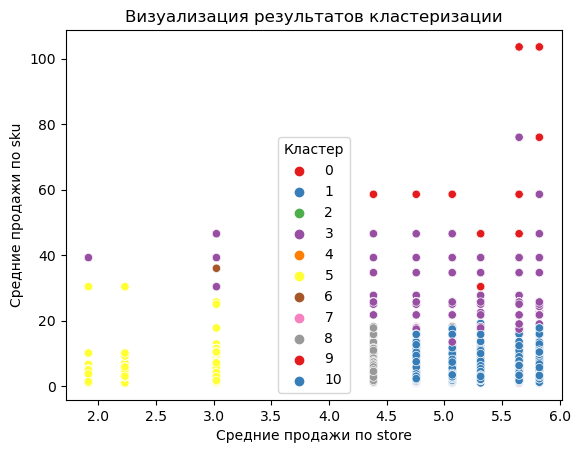

In [132]:
# диаграмма рассеяния для двух признаков
sns.scatterplot(data=clast_activ_store, x='avg_sales_by_store_units', y='avg_sales_by_sku_units', hue='cluster', palette='Set1')
plt.xlabel('Средние продажи по store')
plt.ylabel('Средние продажи по sku')
plt.title('Визуализация результатов кластеризации')
plt.legend(title='Кластер')
plt.show()

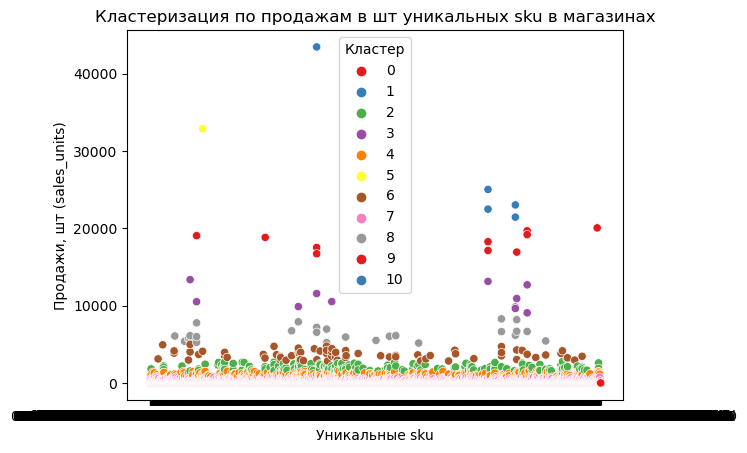

In [133]:
# scatter plot для кластеризации
sns.scatterplot(data=sku_sales_sum, y='sales_units', x='sku', hue='cluster', palette='Set1')
plt.ylabel('Продажи, шт (sales_units)')
plt.xlabel('Уникальные sku')
plt.title('Кластеризация по продажам в шт уникальных sku в магазинах')
plt.legend(title='Кластер')
plt.show()

### Оценим статистики для кластеров

In [134]:
list_clast = np.sort(clast_activ_store['cluster'].unique())
list_clast

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [135]:
cluster_stats = {}

for clast in list_clast:
    cluster_data = clast_activ_store[clast_activ_store['cluster'] == clast]['sales_units'].describe().to_frame()
    cluster_stats[clast] = cluster_data

# Создаем DataFrame для всех статистик
combined_stats = pd.concat(cluster_stats, axis=1)

# Добавляем названия кластеров в качестве индекса
combined_stats.index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
combined_stats

0           1             2             3              4   \
        sales_units sales_units   sales_units   sales_units    sales_units   
count  92276.000000   852.00000  43016.000000  11451.000000  116412.000000   
mean       4.862792   133.45892      4.144249     21.199371       3.611647   
std        5.071210    89.66687      5.036969     14.397658       3.932307   
min        1.000000    76.00000      1.000000      1.000000       1.000000   
25%        1.000000    96.00000      1.000000     11.000000       1.000000   
50%        3.000000   112.00000      2.000000     18.000000       2.000000   
75%        6.000000   141.25000      5.000000     29.000000       4.000000   
max       74.000000  1033.00000     80.000000     88.000000      62.000000   

                 5            6             7             8            9   \
        sales_units  sales_units   sales_units   sales_units  sales_units   
count  31139.000000  5754.000000  65092.000000  89506.000000  2761.000000   
mean       2.786249    40.782760      3.533445      2.933077    75.948569   
std        2.937458    15.750457      3.555420      2.994088    38.291628   
min        1.000000    20.000000      1.000000      1.000000     1.000000   
25%        1.000000    28.000000      1.000000      1.000000    50.000000   
50%        2.000000    35.000000      2.000000      2.000000    67.000000   
75%        4.000000    50.000000      4.000000      4.000000    92.000000   
max       67.000000    91.000000     61.000000     63.000000   351.000000   

                 10  
        sales_units  
count  65236.000000  
mean       3.649595  
std        3.945193  
min        1.000000  
25%        1.000000  
50%        2.000000  
75%        4.000000  
max       64.000000

In [136]:
# пара топ-1 магазин и топ-1 товар
clast_activ_store[(clast_activ_store['store'] == 'c81e728d9d4c2f636f067f89cc14862c') & (clast_activ_store['sku'] == '62d4af457ba2540ce0898a211c0cd17a')].head()

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-02  c81e728d9d4c2f636f067f89cc14862c   
2022-08-03  c81e728d9d4c2f636f067f89cc14862c   
2022-08-04  c81e728d9d4c2f636f067f89cc14862c   
2022-08-05  c81e728d9d4c2f636f067f89cc14862c   

                                         sku  sales_units  sales_rub  \
date                                                                   
2022-08-01  62d4af457ba2540ce0898a211c0cd17a           89     1294.0   
2022-08-02  62d4af457ba2540ce0898a211c0cd17a           77     1118.0   
2022-08-03  62d4af457ba2540ce0898a211c0cd17a           70     1022.0   
2022-08-04  62d4af457ba2540ce0898a211c0cd17a           71     1031.0   
2022-08-05  62d4af457ba2540ce0898a211c0cd17a           86     1255.0   

                                       group  \
date                                           
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-02  c74d97b01eae257e44aa9d5bade97baf   
2022-08-03  c74d97b01eae257e44aa9d5bade97baf   
2022-08-04  c74d97b01eae257e44aa9d5bade97baf   
2022-08-05  c74d97b01eae257e44aa9d5bade97baf   

                                    category  \
date                                           
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-02  c559da2ba967eb820766939a658022c8   
2022-08-03  c559da2ba967eb820766939a658022c8   
2022-08-04  c559da2ba967eb820766939a658022c8   
2022-08-05  c559da2ba967eb820766939a658022c8   

                                 subcategory  uom  \
date                                                
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-02  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-03  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-04  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-05  e06f5ed77191826c212c30722f2cc5a2    0   

                                    division  \
date                                           
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-02  429a86ff6336c144ddaf6144f52ab52c   
2022-08-03  429a86ff6336c144ddaf6144f52ab52c   
2022-08-04  429a86ff6336c144ddaf6144f52ab52c   
2022-08-05  429a86ff6336c144ddaf6144f52ab52c   

                                        city  ... avg_sales_by_holiday_units  \
date                                          ...                              
2022-08-01  908c9a564a86426585b29f5335b619bc  ...                   4.720167   
2022-08-02  908c9a564a86426585b29f5335b619bc  ...                   4.720167   
2022-08-03  908c9a564a86426585b29f5335b619bc  ...                   4.720167   
2022-08-04  908c9a564a86426585b29f5335b619bc  ...                   4.720167   
2022-08-05  908c9a564a86426585b29f5335b619bc  ...                   4.720167   

           avg_sales_by_category_units avg_sales_by_subcategory_units  \
date                                                                    
2022-08-01                    8.457461                      14.612582   
2022-08-02                    8.457461                      14.612582   
2022-08-03                    8.457461                      14.612582   
2022-08-04                    8.457461                      14.612582   
2022-08-05                    8.457461                      14.612582   

            avg_sales_by_division_units  avg_sales_by_city_units  \
date                                                               
2022-08-01                     5.221882                 5.221882   
2022-08-02                     5.221882                 5.221882   
2022-08-03                     5.221882                 5.221882   
2022-08-04                     5.221882                 5.221882   
2022-08-05                     5.221882                 5.221882   

            avg_sales_by_type_format_units  avg_sales_by_loc_units  \
date                                                                 
2022-08-01                        5.234517                4.998441   
2022-08-02                        5.234517            

In [137]:
# кластер 9
clast_activ_store[(clast_activ_store['sku'] == '62d4af457ba2540ce0898a211c0cd17a') & (clast_activ_store['cluster'] == 9)].head()

store  \
date                                           
2022-08-01  f7e6c85504ce6e82442c770f7c8606f0   
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   
2022-08-02  f7e6c85504ce6e82442c770f7c8606f0   
2022-08-02  c81e728d9d4c2f636f067f89cc14862c   

                                         sku  sales_units  sales_rub  \
date                                                                   
2022-08-01  62d4af457ba2540ce0898a211c0cd17a           49      698.0   
2022-08-01  62d4af457ba2540ce0898a211c0cd17a           89     1294.0   
2022-08-01  62d4af457ba2540ce0898a211c0cd17a          107     1553.0   
2022-08-02  62d4af457ba2540ce0898a211c0cd17a           54      767.0   
2022-08-02  62d4af457ba2540ce0898a211c0cd17a           77     1118.0   

                                       group  \
date                                           
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-02  c74d97b01eae257e44aa9d5bade97baf   
2022-08-02  c74d97b01eae257e44aa9d5bade97baf   

                                    category  \
date                                           
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-02  c559da2ba967eb820766939a658022c8   
2022-08-02  c559da2ba967eb820766939a658022c8   

                                 subcategory  uom  \
date                                                
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-02  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-02  e06f5ed77191826c212c30722f2cc5a2    0   

                                    division  \
date                                           
2022-08-01  32586311f16876abf92901085bd87b99   
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130   
2022-08-02  32586311f16876abf92901085bd87b99   
2022-08-02  429a86ff6336c144ddaf6144f52ab52c   

                                        city  ... avg_sales_by_holiday_units  \
date                                          ...                              
2022-08-01  3202111cf90e7c816a472aaceb72b0df  ...                   4.720167   
2022-08-01  908c9a564a86426585b29f5335b619bc  ...                   4.720167   
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...                   4.720167   
2022-08-02  3202111cf90e7c816a472aaceb72b0df  ...                   4.720167   
2022-08-02  908c9a564a86426585b29f5335b619bc  ...                   4.720167   

           avg_sales_by_category_units avg_sales_by_subcategory_units  \
date                                                                    
2022-08-01                    8.457461                      14.612582   
2022-08-01                    8.457461                      14.612582   
2022-08-01                    8.457461                      14.612582   
2022-08-02                    8.457461                      14.612582   
2022-08-02                    8.457461                      14.612582   

            avg_sales_by_division_units  avg_sales_by_city_units  \
date                                                               
2022-08-01                     5.313372                 5.313372   
2022-08-01                     5.221882                 5.221882   
2022-08-01                     5.275925                 5.646487   
2022-08-02                     5.313372                 5.313372   
2022-08-02                     5.221882                 5.221882   

            avg_sales_by_type_format_units  avg_sales_by_loc_units  \
date                                                                 
2022-08-01                        5.234517                4.998441   
2022-08-01                        5.234517            

## Сравним продажи выбранного scu в магазине с продажами его кластера

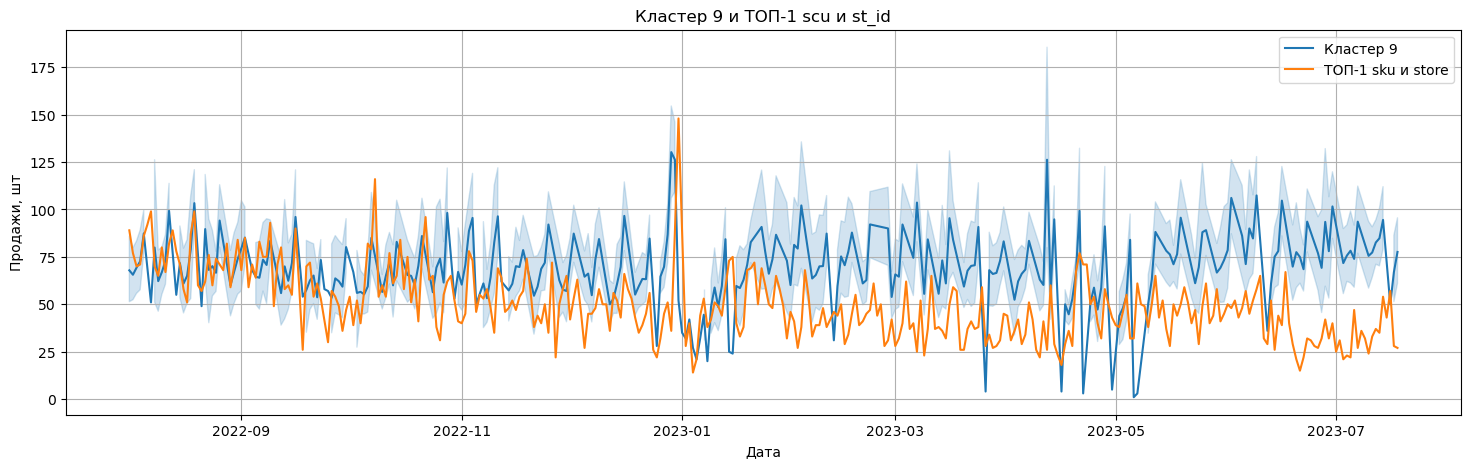

In [138]:
plt.figure(figsize=(18, 5))
# фильтруем данные для выбранного кластера
filtered_data_cl = clast_activ_store[clast_activ_store['cluster'] == 9]
filtered_data_scu = clast_activ_store[(clast_activ_store['sku'] == '62d4af457ba2540ce0898a211c0cd17a') & (clast_activ_store['store'] == 'c81e728d9d4c2f636f067f89cc14862c')]

sns.lineplot(data=filtered_data_cl, x=filtered_data_cl.index, y='sales_units', label='Кластер 9')
sns.lineplot(data=filtered_data_scu, x=filtered_data_scu.index, y='sales_units', label='ТОП-1 sku и store')

plt.xlabel("Дата")
plt.ylabel("Продажи, шт")
plt.title('Кластер 9 и ТОП-1 scu и st_id')
plt.grid(True)

plt.legend()
plt.show()

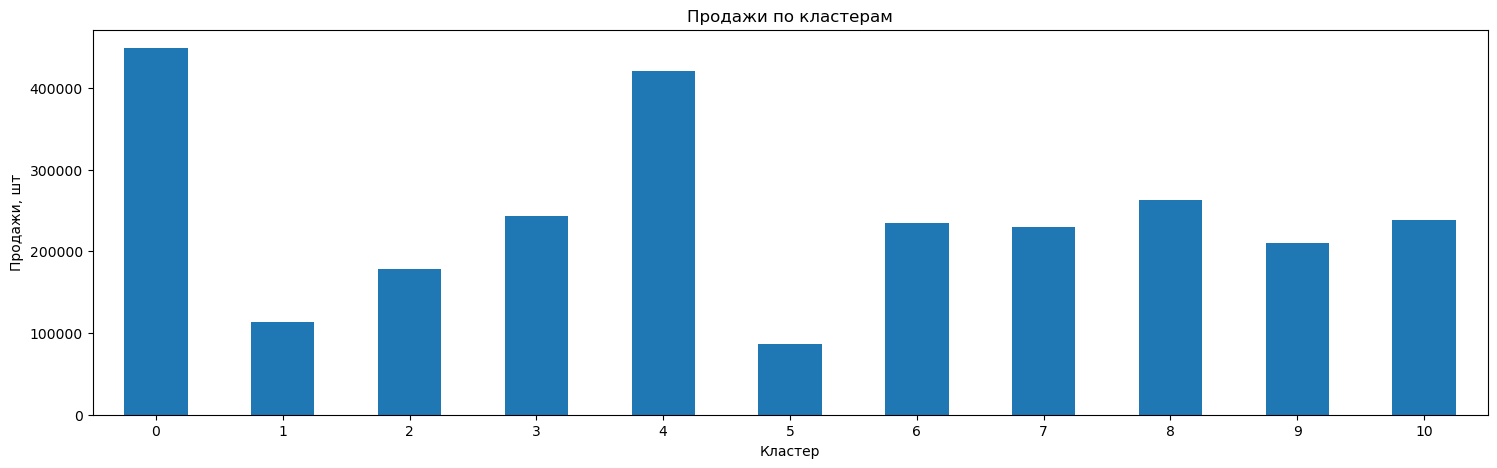

In [139]:
# группируем данные по столбцу 'cluster' и считаем сумму продаж
cluster_sales = clast_activ_store.groupby('cluster')['sales_units'].sum()

# график
plt.figure(figsize=(18, 5))
cluster_sales.plot(kind='bar')
plt.xlabel('Кластер')
plt.ylabel('Продажи, шт')
plt.title('Продажи по кластерам')
plt.xticks(rotation=0)
plt.show()

### Ресемплинг по кластерам

In [140]:
clast_activ_store.head(3)

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-01  42a0e188f5033bc65bf8d78622277c4e   
2022-08-01  16a5cdae362b8d27a1d8f8c7b78b4330   

                                         sku  sales_units  sales_rub  \
date                                                                   
2022-08-01  a26de72f8ea9889b7332ed5f940d8b62           21      462.0   
2022-08-01  dce1f234d6424aa61f8e7ce0baffd9af            6      860.0   
2022-08-01  3f33017a9ce4fbff701facaeae7a7549            1       65.0   

                                       group  \
date                                           
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-01  aab3238922bcc25a6f606eb525ffdc56   
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   

                                    category  \
date                                           
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-01  9701a1c165dd9420816bfec5edd6c2b1   
2022-08-01  1bc0249a6412ef49b07fe6f62e6dc8de   

                                 subcategory  uom  \
date                                                
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-01  c01c475ac8d447730ece97d846cc4f25    1   
2022-08-01  ca34f669ae367c87f0e75dcae0f61ee5    0   

                                    division  \
date                                           
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-01  da742b3cfca5388aaf9af28a726a3c30   
2022-08-01  296bd0cc6e735f9d7488ebc8fbc19130   

                                        city  ... avg_sales_by_holiday_units  \
date                                          ...                              
2022-08-01  908c9a564a86426585b29f5335b619bc  ...                   4.720167   
2022-08-01  b8b4b727d6f5d1b61fff7be687f7970f  ...                   4.720167   
2022-08-01  c1f75cc0f7fe269dd0fd9bd5e24f9586  ...                   4.720167   

           avg_sales_by_category_units avg_sales_by_subcategory_units  \
date                                                                    
2022-08-01                    8.457461                      14.612582   
2022-08-01                    2.857088                       3.006887   
2022-08-01                    4.552009                       3.696093   

            avg_sales_by_division_units  avg_sales_by_city_units  \
date                                                               
2022-08-01                     5.221882                 5.221882   
2022-08-01                     4.756012                 4.756012   
2022-08-01                     5.275925                 5.646487   

            avg_sales_by_type_format_units  avg_sales_by_loc_units  \
date                                                                 
2022-08-01                        5.234517                4.998441   
2022-08-01                        5.234517                4.998441   
2022-08-01                        5.234517                5.646487   

            avg_sales_by_size_units  avg_holiday_sales_units  cluster  
date                                                                   
2022-08-01                 5.734326                        0        4  
2022-08-01                 4.904329                        0        4  
2022-08-01                 5.734326                        0        4  

[3 rows x 80 columns]

In [141]:
claster_df = clast_activ_store.copy()

In [142]:
claster_df = claster_df.drop(['sales_units', 'sales_rub', 'sales_rub_stand',
       'sales_units_stand', 'store', 'sku', 'group',
       'category', 'subcategory', 'uom', 'division', 'city',
        'year','month','day','weekday','holiday', 'type_format','loc','size'], axis=1)

In [143]:
claster_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523495 entries, 2022-08-01 to 2023-07-18
Data columns (total 60 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   promo_part                        523495 non-null  float64
 1   price_units                       523495 non-null  float64
 2   price_units_stand                 523495 non-null  float64
 3   sales_share_group_unit            523495 non-null  float64
 4   sales_share_category_unit         523495 non-null  float64
 5   sales_share_subcategory_unit      523495 non-null  float64
 6   sales_share_group_rub             523495 non-null  float64
 7   sales_share_category_rub          523495 non-null  float64
 8   sales_share_subcategory_rub       523495 non-null  float64
 9   sales_share_store_sku_unit        523495 non-null  float64
 10  sales_share_sku_sku_unit          523495 non-null  float64
 11  sales_share_year_sku_unit         52

In [144]:
claster_df_0 = claster_df[(claster_df['cluster'] == 0)]
claster_df_0.head()

promo_part  price_units  price_units_stand  \
date                                                     
2022-08-05       0.776       209.00           0.581116   
2022-08-05       0.330       324.50           1.493229   
2022-08-05       0.385       142.00           0.052011   
2022-08-05       0.172        17.75          -0.929202   
2022-08-05       0.099       135.00          -0.003268   

            sales_share_group_unit  sales_share_category_unit  \
date                                                            
2022-08-05                0.000792                   0.001125   
2022-08-05                0.000885                   0.000623   
2022-08-05                0.000516                   0.001218   
2022-08-05                0.000516                   0.000270   
2022-08-05                0.000516                   0.001218   

            sales_share_subcategory_unit  sales_share_group_rub  \
date                                                              
2022-08-05                      0.000356               0.000005   
2022-08-05                      0.000512               0.000006   
2022-08-05                      0.001444               0.000011   
2022-08-05                      0.000230               0.000011   
2022-08-05                      0.001333               0.000011   

            sales_share_category_rub  sales_share_subcategory_rub  \
date                                                                
2022-08-05                  0.000006                     0.000002   
2022-08-05                  0.000003                     0.000002   
2022-08-05                  0.000009                     0.000009   
2022-08-05                  0.000007                     0.000007   
2022-08-05                  0.000009                     0.000022   

            sales_share_store_sku_unit  ...  avg_sales_by_holiday_units  \
date                                    ...                               
2022-08-05                    0.001834  ...                    4.720167   
2022-08-05                    0.001696  ...                    4.720167   
2022-08-05                    0.001834  ...                    4.720167   
2022-08-05                    0.002195  ...                    4.720167   
2022-08-05                    0.001696  ...                    4.720167   

            avg_sales_by_category_units  avg_sales_by_subcategory_units  \
date                                                                      
2022-08-05                     3.931586                        5.666499   
2022-08-05                     4.453165                        3.592909   
2022-08-05                     2.943155                        2.038160   
2022-08-05                     8.457461                        9.222567   
2022-08-05                     2.943155                        2.933225   

            avg_sales_by_division_units  avg_sales_by_city_units  \
date                                                               
2022-08-05                     5.221882                 5.221882   
2022-08-05                     5.275925                 5.646487   
2022-08-05                     5.221882                 5.221882   
2022-08-05                     5.313372                 5.313372   
2022-08-05                     5.275925                 5.646487   

            avg_sales_by_type_format_units  avg_sales_by_loc_units  \
date                                                                 
2022-08-05                        5.234517                4.998441   
2022-08-05                        5.234517                5.646487   
2022-08-05                        5.234517                4.998441   
2022-08-05                        5.234517                4.998441   
2022-08-05                        5.234517                5.646487   

            avg_sales_by_size_units  avg_holiday_sales_units  cluster  
date                                                                   
2022-08-05                 5.73

In [145]:
# ресемплинг по дням
claster_df_0.index = pd.to_datetime(claster_df_0.index)
claster_df_0_resampled = claster_df_0.resample('D').sum()

In [146]:
claster_df_0_resampled.reset_index()

date  promo_part  price_units  price_units_stand  \
0   2022-08-05     204.661    106595.70           9.821586   
1   2022-08-06     149.565     71675.69          -7.155964   
2   2022-08-07      24.236      5767.48         -28.240599   
3   2022-08-08       0.000         0.00           0.000000   
4   2022-08-09       0.000         0.00           0.000000   
..         ...         ...          ...                ...   
341 2023-07-12       0.000         0.00           0.000000   
342 2023-07-13       0.000         0.00           0.000000   
343 2023-07-14     193.626    118567.11          93.667097   
344 2023-07-15     158.030     82655.81           2.559982   
345 2023-07-16      21.851      5645.05         -21.721813   

     sales_share_group_unit  sales_share_category_unit  \
0                  0.626130                   0.838179   
1                  0.398302                   0.512448   
2                  0.043268                   0.048244   
3                  0.000000                   0.000000   
4                  0.000000                   0.000000   
..                      ...                        ...   
341                0.000000                   0.000000   
342                0.000000                   0.000000   
343                0.742618                   0.994445   
344                0.464069                   0.613050   
345                0.039103                   0.042987   

     sales_share_subcategory_unit  sales_share_group_rub  \
0                        1.265656               0.006622   
1                        0.596538               0.004430   
2                        0.068586               0.000586   
3                        0.000000               0.000000   
4                        0.000000               0.000000   
..                            ...                    ...   
341                      0.000000               0.000000   
342                      0.000000               0.000000   
343                      1.048758               0.006736   
344                      0.686746               0.004977   
345                      0.033129               0.000523   

     sales_share_category_rub  sales_share_subcategory_rub  ...  \
0                    0.008827                     0.029584  ...   
1                    0.005524                     0.006588  ...   
2                    0.000680                     0.000769  ...   
3                    0.000000                     0.000000  ...   
4                    0.000000                     0.000000  ...   
..                        ...                          ...  ...   
341                  0.000000                     0.000000  ...   
342                  0.000000                     0.000000  ...   
343                  0.009454                     0.010030  ...   
344                  0.006494                     0.007393  ...   
345                  0.000550                     0.000464  ...   

     avg_sales_by_holiday_units  avg_sales_by_category_units  \
0                   3672.289917                  3803.270325   
1                   3135.378548                  2722.128649   
2                    403.621492                   421.403117   
3                      0.000000                     0.000000   
4                      0.000000                     0.000000   
..                          ...                          ...   
341                    0.000000                     0.000000   
342                    0.000000                     0.000000   
343                 3719.491587                  3838.399864   
344                 3556.548801                  3171.638755   
345                  362.674384                   372.591506   

     avg_sales_by_subcategory_units  avg_sales_by_division_units  \
0                       3645.586949                  4097.206225   
1                       2688.244464                  2815.243001   
2                        438.317997                   359.435841   
3

# Построение и обучение моделей

## Обучение и тестирование классических моделей

In [147]:
classic_activ_store = clast_activ_store.copy()

In [148]:
# топ товаров - sku
['62d4af457ba2540ce0898a211c0cd17a',
 'c0e3f3bd815a862433bc3399c487926b',
 'ced0c1a84924c982a6403870c54b99ca',
 'd5bfeecaaa47887a4b92d17fa55c2e18',
 'cf91eca9321c9c272fb4e7cf4bcc6a43',
 '1d2448c22721c94bb0264cf52598522f',
 '20d9b4bfd4b672f61d87f420856aac5d',
 '1a0f36f6e92560bcae205b6c32cc033f',
 '5aa2f6e00873f8c90b00cd15d670daa1',
 'c7b711619071c92bef604c7ad68380dd']

['62d4af457ba2540ce0898a211c0cd17a',
 'c0e3f3bd815a862433bc3399c487926b',
 'ced0c1a84924c982a6403870c54b99ca',
 'd5bfeecaaa47887a4b92d17fa55c2e18',
 'cf91eca9321c9c272fb4e7cf4bcc6a43',
 '1d2448c22721c94bb0264cf52598522f',
 '20d9b4bfd4b672f61d87f420856aac5d',
 '1a0f36f6e92560bcae205b6c32cc033f',
 '5aa2f6e00873f8c90b00cd15d670daa1',
 'c7b711619071c92bef604c7ad68380dd']

In [149]:
#магазины - store
['c81e728d9d4c2f636f067f89cc14862c',
 '16a5cdae362b8d27a1d8f8c7b78b4330',
 'f7e6c85504ce6e82442c770f7c8606f0',
 '42a0e188f5033bc65bf8d78622277c4e',
 'fa7cdfad1a5aaf8370ebeda47a1ff1c3',
 '6364d3f0f495b6ab9dcf8d3b5c6e0b01',
 '1ecfb463472ec9115b10c292ef8bc986',
 '53e19f3dbb211f20b20b45668303c1b6',
 'bd470ca955d9497bbcb808e59952fffc']

['c81e728d9d4c2f636f067f89cc14862c',
 '16a5cdae362b8d27a1d8f8c7b78b4330',
 'f7e6c85504ce6e82442c770f7c8606f0',
 '42a0e188f5033bc65bf8d78622277c4e',
 'fa7cdfad1a5aaf8370ebeda47a1ff1c3',
 '6364d3f0f495b6ab9dcf8d3b5c6e0b01',
 '1ecfb463472ec9115b10c292ef8bc986',
 '53e19f3dbb211f20b20b45668303c1b6',
 'bd470ca955d9497bbcb808e59952fffc']

## Для теста возьмем ТОП-1 store и ТОП-1 scu 

In [150]:
# выбор магазина (st_id) и scu (pr_sku_id)
selected_st_id = 'c81e728d9d4c2f636f067f89cc14862c'
selected_scu = '62d4af457ba2540ce0898a211c0cd17a'
filtered_data = classic_activ_store[(classic_activ_store['store'] == selected_st_id) & (classic_activ_store['sku'] == selected_scu)]

In [151]:
duplicates = filtered_data.index[filtered_data.index.duplicated(keep=False)]
if len(duplicates) > 0:
    print("В DataFrame есть повторяющиеся индексы:")
    print(duplicates)
else:
    print("В DataFrame нет повторяющихся индексов.")

В DataFrame нет повторяющихся индексов.


In [152]:
df = filtered_data.copy()

In [153]:
# рассчет лагов 12 дней
#lag_days = 12
#for lag in range(1, lag_days + 1):
#    df[f'lag_{lag}'] = df['sales_units_stand'].shift(-lag)

# рассчет скользящего среднего за 12 дней
#window_size = 12
#df['rolling_mean'] = df['sales_units_stand'].rolling(window=window_size).mean()

# удаление строк с пропущенными значениями
#df.dropna(inplace=True)

In [154]:
df

store  \
date                                           
2022-08-01  c81e728d9d4c2f636f067f89cc14862c   
2022-08-02  c81e728d9d4c2f636f067f89cc14862c   
2022-08-03  c81e728d9d4c2f636f067f89cc14862c   
2022-08-04  c81e728d9d4c2f636f067f89cc14862c   
2022-08-05  c81e728d9d4c2f636f067f89cc14862c   
...                                      ...   
2023-07-14  c81e728d9d4c2f636f067f89cc14862c   
2023-07-15  c81e728d9d4c2f636f067f89cc14862c   
2023-07-16  c81e728d9d4c2f636f067f89cc14862c   
2023-07-17  c81e728d9d4c2f636f067f89cc14862c   
2023-07-18  c81e728d9d4c2f636f067f89cc14862c   

                                         sku  sales_units  sales_rub  \
date                                                                   
2022-08-01  62d4af457ba2540ce0898a211c0cd17a           89     1294.0   
2022-08-02  62d4af457ba2540ce0898a211c0cd17a           77     1118.0   
2022-08-03  62d4af457ba2540ce0898a211c0cd17a           70     1022.0   
2022-08-04  62d4af457ba2540ce0898a211c0cd17a           71     1031.0   
2022-08-05  62d4af457ba2540ce0898a211c0cd17a           86     1255.0   
...                                      ...          ...        ...   
2023-07-14  62d4af457ba2540ce0898a211c0cd17a           54      925.0   
2023-07-15  62d4af457ba2540ce0898a211c0cd17a           43      745.0   
2023-07-16  62d4af457ba2540ce0898a211c0cd17a           57      979.0   
2023-07-17  62d4af457ba2540ce0898a211c0cd17a           28      482.0   
2023-07-18  62d4af457ba2540ce0898a211c0cd17a           27      466.0   

                                       group  \
date                                           
2022-08-01  c74d97b01eae257e44aa9d5bade97baf   
2022-08-02  c74d97b01eae257e44aa9d5bade97baf   
2022-08-03  c74d97b01eae257e44aa9d5bade97baf   
2022-08-04  c74d97b01eae257e44aa9d5bade97baf   
2022-08-05  c74d97b01eae257e44aa9d5bade97baf   
...                                      ...   
2023-07-14  c74d97b01eae257e44aa9d5bade97baf   
2023-07-15  c74d97b01eae257e44aa9d5bade97baf   
2023-07-16  c74d97b01eae257e44aa9d5bade97baf   
2023-07-17  c74d97b01eae257e44aa9d5bade97baf   
2023-07-18  c74d97b01eae257e44aa9d5bade97baf   

                                    category  \
date                                           
2022-08-01  c559da2ba967eb820766939a658022c8   
2022-08-02  c559da2ba967eb820766939a658022c8   
2022-08-03  c559da2ba967eb820766939a658022c8   
2022-08-04  c559da2ba967eb820766939a658022c8   
2022-08-05  c559da2ba967eb820766939a658022c8   
...                                      ...   
2023-07-14  c559da2ba967eb820766939a658022c8   
2023-07-15  c559da2ba967eb820766939a658022c8   
2023-07-16  c559da2ba967eb820766939a658022c8   
2023-07-17  c559da2ba967eb820766939a658022c8   
2023-07-18  c559da2ba967eb820766939a658022c8   

                                 subcategory  uom  \
date                                                
2022-08-01  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-02  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-03  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-04  e06f5ed77191826c212c30722f2cc5a2    0   
2022-08-05  e06f5ed77191826c212c30722f2cc5a2    0   
...                                      ...  ...   
2023-07-14  e06f5ed77191826c212c30722f2cc5a2    0   
2023-07-15  e06f5ed77191826c212c30722f2cc5a2    0   
2023-07-16  e06f5ed77191826c212c30722f2cc5a2    0   
2023-07-17  e06f5ed77191826c212c30722f2cc5a2    0   
2023-07-18  e06f5ed77191826c212c30722f2cc5a2    0   

                                    division  \
date                                           
2022-08-01  429a86ff6336c144ddaf6144f52ab52c   
2022-08-02  429a86ff6336c144ddaf6144f52ab52c   
2022-08-03  429a86ff6336c144ddaf6144f52ab52c   
2022-08-04  429a86ff6336c144ddaf6144f52ab52c   
2022-08-05  429a86ff6336c144ddaf6144f52ab52c   
...                                      ...   
2023-07-14  429a86ff6336c144ddaf6144f52ab52c   
2023-07-15  429a86ff6336c144ddaf6144f52ab52c   
2023-07-16  429a86ff6336c144ddaf6144f52ab52c   
2023-07-1

In [155]:
# дата начала тестовой выборки (последние 14 дней)
test_end_date = df.index.max()

# делим на трейн и тест
train_df = df[df.index < test_end_date - pd.DateOffset(days=14)]
test_df = df[(df.index >= test_end_date - pd.DateOffset(days=14)) & (df.index < test_end_date)]

# признаки (X) и целевая переменная (y)
X_train = train_df.drop(['sales_units','sales_rub', 'sales_rub_stand', 'sales_units_stand', 'store', 'sku'], axis=1)
y_train = train_df['sales_units_stand']

X_test = test_df.drop(['sales_units','sales_rub', 'sales_rub_stand', 'sales_units_stand', 'store', 'sku'], axis=1)
y_test = test_df['sales_units_stand']

In [156]:
print('\033[1m'+ 'Обучающая выборка'+'\033[0m')
print ('Признаки:',X_train.shape, '\n', 'Целевой признак:', y_train.shape, sep='')
print('='*30)
print('\033[1m'+ 'Тестовая выборка'+'\033[0m')
print ('Признаки:',X_test.shape, '\n', 'Целевой признак:', y_test.shape, sep='')

Обучающая выборка
Признаки:(335, 74)
Целевой признак:(335,)
Тестовая выборка
Признаки:(14, 74)
Целевой признак:(14,)


In [157]:
# проверим последовательность временных данных после разделения на выборки
print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())
print('='*40)
print(X_train.index.is_monotonic_increasing)
print(X_test.index.is_monotonic_increasing)
print(y_train.index.is_monotonic_increasing)
print(y_test.index.is_monotonic_increasing)

2022-08-01 00:00:00 2023-07-03 00:00:00
2023-07-04 00:00:00 2023-07-17 00:00:00
True
True
True
True


## Обучение моделей

* LinearRegression
* RandomForestRegressor
* CatBoostRegressor
* LGBMRegressor

In [158]:
# категориальные признаки
cat_features = X_train.select_dtypes(include='category').columns
cat_features

Index(['group', 'category', 'subcategory', 'division', 'city', 'type_format',
       'loc', 'size'],
      dtype='object')

In [159]:
# численные признаки
num_features = X_train.select_dtypes(exclude='category').columns
num_features

Index(['uom', 'year', 'month', 'day', 'weekday', 'holiday', 'promo_part',
       'price_units', 'price_units_stand', 'sales_share_group_unit',
       'sales_share_category_unit', 'sales_share_subcategory_unit',
       'sales_share_group_rub', 'sales_share_category_rub',
       'sales_share_subcategory_rub', 'sales_share_store_sku_unit',
       'sales_share_sku_sku_unit', 'sales_share_year_sku_unit',
       'sales_share_weekday_sku_unit', 'sales_share_month_sku_unit',
       'sales_share_holiday_sku_unit', 'sales_share_division_sku_unit',
       'sales_share_city_sku_unit', 'sales_share_type_format_sku_unit',
       'sales_share_loc_sku_unit', 'sales_share_size_sku_unit',
       'sales_share_store_sku_rub', 'sales_share_sku_sku_rub',
       'sales_share_year_sku_rub', 'sales_share_weekday_sku_rub',
       'sales_share_month_sku_rub', 'sales_share_holiday_sku_rub',
       'sales_share_division_sku_rub', 'sales_share_city_sku_rub',
       'sales_share_type_format_sku_rub', 'sales_share_lo

In [160]:
# валидатор временных рядов TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=(len(X_train) // 12))

### Модель "Linear Regression"

In [161]:
# признаки для Линейной регрессии
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [162]:
# закодируем категориальные признаки и масштабируем числовые
transformer_lr = make_column_transformer((StandardScaler(), num_features),
                                         (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
                                         remainder = 'passthrough', verbose_feature_names_out=False
                                        )

In [163]:
# создадим модель
model_lr = make_pipeline(transformer_lr, LinearRegression())

In [164]:
# определяем параметры для перебора в GridSearchCV
parametrs_lr  = {}

In [165]:
%%time
# передаем модель, параметры и оценку в GridSearchCV
lr  = GridSearchCV(
    model_lr,
    param_grid=parametrs_lr,
    cv=splits,
    verbose=True,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)
# обучим на тренировочных данных

lr.fit(X_train_lr, y_train)
# найдем лучший RMSE
rmse_lr = lr.best_score_*-1

print('\033[1m'+ 'Модель "Linear Regression"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_lr)
print('='*30)

Fitting 27 folds for each of 1 candidates, totalling 27 fits
Модель "Linear Regression"
RMSE: 38640925.38392821
CPU times: total: 219 ms
Wall time: 712 ms


### Модель "Random Forest Regressor"

In [166]:
# признаки для Регрессии случайного леса
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [167]:
# масштабируем числовые признаки
transformer_rf = make_column_transformer((StandardScaler(), num_features),
                                         (OrdinalEncoder (handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
                                         remainder = 'passthrough', verbose_feature_names_out=False)

In [168]:
# создадим модель
model_rf = make_pipeline(transformer_rf, RandomForestRegressor(random_state=RANDOM_STATE))

In [169]:
# определяем параметры для RandomizedSearchCV
parametrs_rf = {
    'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth': range(2, 15),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
               }

In [170]:
%%time
# обучим модель и найдем лучшие параметры
rf = RandomizedSearchCV(
    model_rf,
    cv=splits,
    param_distributions=parametrs_rf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf.fit(X_train_rf, y_train)
rmse_rf = rf.best_score_*-1

print('\033[1m'+ 'Модель "Random Forest Regressor"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_rf)
print('='*75)
print("Лучшие параметры для Random Forest Regressor: \n", rf.best_params_)
print('='*75)

Модель "Random Forest Regressor"
RMSE: 0.92362606604527
Лучшие параметры для Random Forest Regressor: 
 {'randomforestregressor__n_estimators': 150, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_depth': 10}
CPU times: total: 2.94 s
Wall time: 34.9 s


### Модель "Cat Boost Regressor"

In [171]:
# признаки для Регрессии КэтБуст
X_train_cbr = X_train.copy()
X_test_cbr = X_test.copy()

In [172]:
# создадим модель и передадим ей категориальные признаки
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE,
                              verbose=False,
                              cat_features=['group', 'category', 'subcategory', 'division',
                                            'city', 'type_format', 'loc', 'size'])



In [173]:
# параметры для подбора
parameters_cbr = [{'learning_rate':[0.1, 0.5, 0.8],
               'depth':[6,8,10],
               'iterations':[30, 50, 100],
               'verbose':[False]}]

In [174]:
%%time
# подберем лучшие параметры для модели CatBoostRegressor
grid_cbr = GridSearchCV(
    estimator=model_cbr,
    param_grid = parameters_cbr,
    cv=splits,
    verbose=True,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_cbr.fit(X_train_cbr, y_train)
rmse_cbr = grid_cbr.best_score_* -1

print('\033[1m'+ 'Модель "CatBoost Regressor"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_cbr)
print('='*75)
print("Лучшие параметры для CatBoost Regressor:\n", grid_cbr.best_params_)
print('='*75)

Fitting 27 folds for each of 27 candidates, totalling 729 fits
Модель "CatBoost Regressor"
RMSE: 0.9665232009305668
Лучшие параметры для CatBoost Regressor:
 {'depth': 6, 'iterations': 100, 'learning_rate': 0.1, 'verbose': False}
CPU times: total: 4.56 s
Wall time: 1min 27s


### Модель "LightGBM Regressor"

In [175]:
# признаки для Регресси ЛайтГМБ
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()

In [176]:
# изменим тип категориальных признаков с object на category для LightGBM в обучающей выбрке
for i in X_train_lgb.columns:
    column_type = X_train_lgb[i].dtype
    if column_type == 'category':
        X_train_lgb[i] = X_train_lgb[i].astype('category')

In [177]:
# создадим модель
model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE)

In [178]:
# параметры для подбора
parameters_lgb = {
    'n_estimators': [100, 500, 1000],
    'num_leaves': [31, 100, 200],
    'learning_rate': [0.1, 0.3, 0.5],
    'verbose': [-1]
}

In [179]:
%%time
# подберем лучшие параметры для модели LGBMRegressor
lgb = GridSearchCV(estimator=model_lgb,
                        param_grid=parameters_lgb,
                        scoring='neg_root_mean_squared_error',
                        cv=splits,
                        verbose=True,
                        n_jobs=-1)

lgb.fit(X_train_lgb, y_train)
rmse_lgb = lgb.best_score_* -1

print('\033[1m'+ 'Модель "LightGBM Regressor"'+'\033[0m')
print('\033[1m'+'RMSE:'+'\033[0m', rmse_lgb)
print('='*75)
print("Лучшие параметры для LightGBM Regressor:\n", lgb.best_params_)
print('='*75)

Fitting 27 folds for each of 27 candidates, totalling 729 fits
Модель "LightGBM Regressor"
RMSE: 1.036724190166093
Лучшие параметры для LightGBM Regressor:
 {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31, 'verbose': -1}
CPU times: total: 3.88 s
Wall time: 1min 5s


### RMSE моделей на обучающей выборке

In [180]:
# таблица RMSE моделей на обучающей выборке
index_result =['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LightGBMRegressor']
data_result = {'RMSE на обучающей выборке':[rmse_lr, rmse_rf, rmse_cbr, rmse_lgb]}

result = pd.DataFrame(data=data_result, index=index_result).round(2)
result

RMSE на обучающей выборке
LinearRegression                     38640925.38
RandomForestRegressor                       0.92
CatBoostRegressor                           0.97
LightGBMRegressor                           1.04

### Лучшая модель "CatBoost Regressor"

In [181]:
## 2. Тестирование модели CBR

In [182]:
### 2.1 Модель "CatBoost Regressor"

In [183]:
# создадим модель
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE,
                              verbose=False,
                              cat_features=['group', 'category', 'subcategory', 'division',
                                            'city', 'type_format', 'loc', 'size'])

In [184]:
# лучшие параметры
best_parameters_cbr = [
    {'bagging_temperature': [0.6],
     'depth': [6],
     'iterations': [100],
     #'l2_leaf_reg': [5],
     'learning_rate': [0.1],
     'random_strength': [1.0],
     'verbose': [False]}]

In [185]:
%%time
# обучим лучшую модель CatBoostRegressor
grid_cbr = GridSearchCV(
    estimator=model_cbr,
    param_grid = best_parameters_cbr,
    cv=splits,
    verbose=True,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_cbr.fit(X_train_cbr, y_train)
best_model_cbr = grid_cbr.best_estimator_

Fitting 27 folds for each of 1 candidates, totalling 27 fits
CPU times: total: 1.08 s
Wall time: 2.04 s


In [186]:
%%time
# получим предсказания для CatBoostRegressor на тестовой выборке
predict_test_cbr = best_model_cbr.predict(X_test_cbr)

# найдем RMSE
test_rmse_cbr = mean_squared_error(y_test, predict_test_cbr, squared=False)
print('\033[1m'+ 'Модель "CatBoost Regressor"'+'\033[0m')
print('\033[1m'+'RMSE на тестовой выборке:'+'\033[0m', test_rmse_cbr)
print('='*60)

Модель "CatBoost Regressor"
RMSE на тестовой выборке: 0.4716877235174769
CPU times: total: 62.5 ms
Wall time: 12 ms


In [187]:
index=['CatBoostRegressor']
data = {'RMSE на обучающей выборке':[rmse_cbr],
        'RMSE на тестовой выборке':[test_rmse_cbr]}


final_result = pd.DataFrame(data=data, index=index)
final_result

RMSE на обучающей выборке  RMSE на тестовой выборке
CatBoostRegressor                   0.966523                  0.471688

In [188]:
## 3.1 Визуализируем предсказания модели на тестовой выборке

In [189]:
predict_test_cbr = best_model_cbr.predict(X_test_cbr)

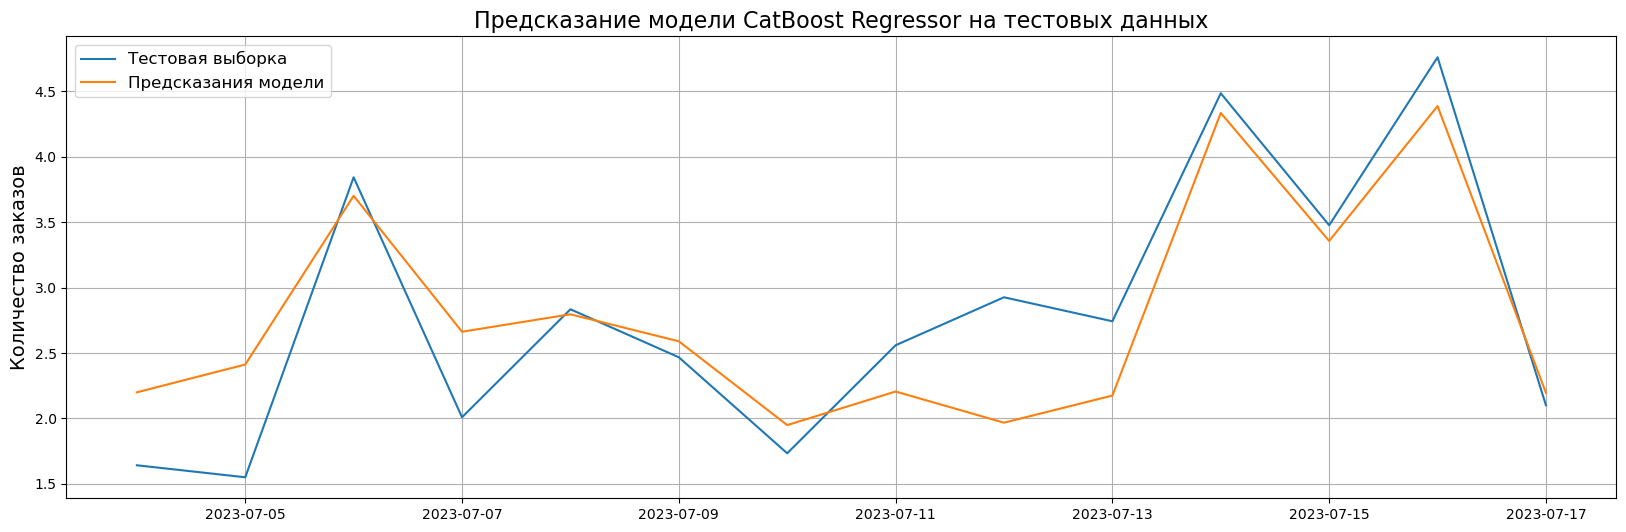

In [190]:
# предсказания модели на тестовой выборке
predict_test = pd.Series(predict_test_cbr, index=y_test.index)

pred_previous = test_df.shift()
pred_previous.iloc[0] = train_df.iloc[-1]

plt.figure(figsize=(20,6))
plt.grid(True)

# легенда
plt.plot(y_test, label='Тестовая выборка')
plt.plot(predict_test, label='Предсказания модели')
#plt.plot(pred_previous['pr_sales_in_units_stand'], label='Предсказания дамми-модели')

plt.legend(title = '', loc = 'upper left', fontsize = 12)

# заголовок и подписи к осям
plt.ylabel('Количество заказов',fontsize=14)
plt.title('Предсказание модели CatBoost Regressor на тестовых данных', fontsize = 16)

plt.show()

In [191]:
test_df = test_df.copy()
test_df.reset_index(inplace=True)

In [192]:
predicted_df = pd.DataFrame({'prediction': predict_test}, index=y_test.index)
predicted_df.reset_index(inplace=True)

# объединение и выбор нужных столбцов
result_df = predicted_df.merge(test_df[['date', 'sales_units_stand']], on='date', how='inner')\
                                          [['date', 'prediction', 'sales_units_stand']]
result_df[['prediction','sales_units']] = (result_df[['prediction', 'sales_units_stand']]\
                         .apply(lambda x: (x * sales_units_sd) + sales_units_mean)).round()
result_df['wape'] = result_df.apply(lambda row: np.sum(np.abs(row['sales_units'] - row['prediction']))\
                                        / np.sum(np.abs(row['sales_units'])), axis=1)
average_wape = result_df['wape'].mean()
print(f"Среднее значение WAPE: {average_wape}")

result_df = result_df.drop(['sales_units_stand'] , axis=1)
pred_df = result_df[['date', 'sales_units', 'prediction', 'wape' ]]
pred_df

Среднее значение WAPE: 0.12967498547160858


date  sales_units  prediction      wape
0  2023-07-04         23.0        29.0  0.260870
1  2023-07-05         22.0        31.0  0.409091
2  2023-07-06         47.0        45.0  0.042553
3  2023-07-07         27.0        34.0  0.259259
4  2023-07-08         36.0        36.0  0.000000
5  2023-07-09         32.0        33.0  0.031250
6  2023-07-10         24.0        26.0  0.083333
7  2023-07-11         33.0        29.0  0.121212
8  2023-07-12         37.0        27.0  0.270270
9  2023-07-13         35.0        29.0  0.171429
10 2023-07-14         54.0        52.0  0.037037
11 2023-07-15         43.0        42.0  0.023256
12 2023-07-16         57.0        53.0  0.070175
13 2023-07-17         28.0        29.0  0.035714

In [193]:
pred_sales_submission = pd.merge(pred_df, test_df, on=['date', 'sales_units'], how='left')
pred_sales_submission = pred_sales_submission[['store', 'sku', 'date', 'prediction', 'sales_units', 'wape']]
average_wape = pred_sales_submission['wape'].mean()
print(f"Среднее значение WAPE: {average_wape}")
pred_sales_submission

Среднее значение WAPE: 0.12967498547160858


store                               sku  \
0   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
1   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
2   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
3   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
4   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
5   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
6   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
7   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
8   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
9   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
10  c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
11  c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
12  c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
13  c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   

         date  prediction  sales_units      wape  
0  2023-07-04        29.0         23.0  0.260870  
1  2023-07-05        31.0         22.0  0.409091  
2  2023-07-06        45.0         47.0  0.042553  
3  2023-07-07        34.0         27.0  0.259259  
4  2023-07-08        36.0         36.0  0.000000  
5  2023-07-09        33.0         32.0  0.031250  
6  2023-07-10        26.0         24.0  0.083333  
7  2023-07-11        29.0         33.0  0.121212  
8  2023-07-12        27.0         37.0  0.270270  
9  2023-07-13        29.0         35.0  0.171429  
10 2023-07-14        52.0         54.0  0.037037  
11 2023-07-15        42.0         43.0  0.023256  
12 2023-07-16        53.0         57.0  0.070175  
13 2023-07-17        29.0         28.0  0.035714

### Функция обучения и тестирования модели CBR

In [194]:
df = clast_activ_store.copy()

In [195]:
# создадим модель
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE,
                              verbose=False,
                              cat_features=['group', 'category', 'subcategory', 'division',
                                            'city', 'type_format', 'loc', 'size'])
# лучшие параметры
best_parameters_cbr = [
    {'bagging_temperature': [0.6],
     'depth': [6],
     'iterations': [100],
     #'l2_leaf_reg': [5],
     'learning_rate': [0.1],
     'random_strength': [1.0],
     'verbose': [False]}]

In [196]:
def train_model(df, store, sku):
    sku_st = df[(df['store'] == store) & (df['sku'] == sku)]

    # дата начала тестовой выборки (последние 14 дней)
    test_end_date = sku_st.index.max()

    # делим на трейн и тест
    train_df = sku_st[sku_st.index < test_end_date - pd.DateOffset(days=14)]
    test_df = sku_st[(sku_st.index >= test_end_date - pd.DateOffset(days=14)) & (sku_st.index <= test_end_date)]

    # признаки (X) и целевая переменная (y)
    X_train = train_df.drop(['sales_units','sales_rub', 'sales_rub_stand', 'sales_units_stand', 'store', 'sku'], axis=1)
    y_train = train_df['sales_units_stand']

    X_test = test_df.drop(['sales_units','sales_rub', 'sales_rub_stand', 'sales_units_stand', 'store', 'sku'], axis=1)
    y_test = test_df['sales_units_stand']
    splits = TimeSeriesSplit(n_splits=(len(X_train) // 12))

    # модель
    grid_cbr = GridSearchCV(estimator=model_cbr, param_grid = best_parameters_cbr, cv=splits,
                            verbose=True, scoring='neg_root_mean_squared_error', n_jobs=-1)

    grid_cbr.fit(X_train, y_train)
    best_model_cbr = grid_cbr.best_estimator_
    feature_importances_cbr = best_model_cbr.feature_importances_
    return best_model_cbr, X_test, feature_importances_cbr

#### Функция CatBoost Regressor (обучение, тестирование, предсказание лучшей модели)

In [197]:
def make_predict_test(df, store, sku):
    sku_st = df[(df['store'] == store) & (df['sku'] == sku)]

    # дата начала тестовой выборки (последние 14 дней)
    test_end_date = sku_st.index.max()

    # делим на трейн и тест
    train_df = sku_st[sku_st.index < test_end_date - pd.DateOffset(days=14)]
    test_df = sku_st[(sku_st.index >= test_end_date - pd.DateOffset(days=14)) & (sku_st.index <= test_end_date)]

    # признаки (X) и целевая переменная (y)
    X_train = train_df.drop(['sales_units','sales_rub', 'sales_rub_stand', 'sales_units_stand', 'store', 'sku'], axis=1)
    y_train = train_df['sales_units_stand']

    X_test = test_df.drop(['sales_units','sales_rub', 'sales_rub_stand', 'sales_units_stand', 'store', 'sku'], axis=1)
    y_test = test_df['sales_units_stand']
    splits = TimeSeriesSplit(n_splits=(len(X_train) // 14))

    # модель
    grid_cbr = GridSearchCV(estimator=model_cbr, param_grid = best_parameters_cbr, cv=splits,
                            verbose=True, scoring='neg_root_mean_squared_error', n_jobs=-1)

    grid_cbr.fit(X_train, y_train)
    best_model_cbr = grid_cbr.best_estimator_

    predict_test_cbr = best_model_cbr.predict(X_test)

    predicted_df = pd.DataFrame({'prediction': predict_test_cbr}, index=y_test.index)
    predicted_df.reset_index(inplace=True)

    test_df = test_df.copy()
    test_df.reset_index(inplace=True)

    result_df = predicted_df.merge(test_df[['date', 'sales_units_stand']], on='date', how='inner')\
                                          [['date', 'prediction', 'sales_units_stand']]
    result_df[['prediction','sales_units']] = (result_df[['prediction', 'sales_units_stand']] \
                         .apply(lambda x: (x * sales_units_sd) + sales_units_mean)).round()
    result_df['wape'] = result_df.apply(lambda row: np.sum(np.abs(row['sales_units'] - row['prediction']))\
                                        / np.sum(np.abs(row['sales_units'])), axis=1)
    average_wape = result_df['wape'].mean()
    print(f"Среднее значение WAPE: {average_wape}")

    result_df = result_df.drop(['sales_units_stand'] , axis=1)
    pred_df = result_df[['date', 'sales_units', 'prediction', 'wape' ]]

    pred_sales_submission = pd.merge(pred_df, test_df, on=['date', 'sales_units'], how='left')
    pred_sales_submission = pred_sales_submission[['store', 'sku', 'date', 'prediction', 'sales_units', 'wape']]
    pred_sales_submission

    return pred_sales_submission

In [198]:
# создаем словарь, где ключ - это магазин, а значения - это все товары, которые имеются в магазине
#store_dict = df.groupby('st_id')['pr_sku_id'].apply(list).to_dict()
# собираем в список все магазины и товары
stores = df['store'].unique().tolist()
skus = df['sku'].unique().tolist()

#### Составим таблицу прогноза по всем магазинам.
> проверим метрику **WAPE** на тестовой выборке: все магазины (9), 1000 scu 

In [199]:
start_time = time.time()
# пустой датафрейм для хранения всех результатов
result_df = pd.DataFrame()

# прогнозы для магазинов и товаров
sku_id_counter = 0  # счетчик проверенных sku
for st_id in stores:
    for pr_sku_id in skus:
        if sku_id_counter >= 1000:
            break  # остановим цикл после проверки 1000 sku
        # проверим есть ли пара st_id и sku в таблице df (продавался ли товар в магазине)
        if ((df['store'] == st_id) & (df['sku'] == pr_sku_id)).any():
            # проверим сроки продаж для данной пары
            sales_data = df[(df['store'] == st_id) & (df['sku'] == pr_sku_id)]
            min_date = sales_data.index.min()  # начало продаж
            max_date = sales_data.index.max()  # конец продаж
            sales_duration = (max_date - min_date).days
            if sales_duration < 180: # осечем продажи менее 6 месяцев
                print(f"В магазине:{st_id} товар:{pr_sku_id} продавался менее 180 дней ({sales_duration} дней). Недостаточно данных для прогноза.")
            else:
                try:
                    df_1 = make_predict_test(df, st_id, pr_sku_id)
                    result_df = pd.concat([result_df, df_1], ignore_index=True)
                except Exception as e:
                    print(f"Ошибка при обработке st_id:{st_id}, pr_sku_id:{pr_sku_id}: {e}")
        else:
            print(f"В магазине:{st_id} товар:{pr_sku_id} не найден. Проверьте данные")
        sku_id_counter += 1  # счетчик

# результаты
display(result_df)
print(f"Время выполнения: {(time.time() - start_time) // 60} минут")

Fitting 21 folds for each of 1 candidates, totalling 21 fits
Среднее значение WAPE: 0.3796943115364168
Fitting 16 folds for each of 1 candidates, totalling 16 fits
Среднее значение WAPE: 0.3263125763125763
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Среднее значение WAPE: 0.1332365003417635
Fitting 19 folds for each of 1 candidates, totalling 19 fits
Среднее значение WAPE: 1.8125
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Среднее значение WAPE: 0.634018759018759
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Среднее значение WAPE: 0.172008547008547
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Среднее значение WAPE: 0.0
Fitting 17 folds for each of 1 candidates, totalling 17 fits
Среднее значение WAPE: 0.30303030303030304
В магазине:c81e728d9d4c2f636f067f89cc14862c товар:f7797c89f0833cc91f84cd1740a4cbe5 не найден. Проверьте данные
В магазине:c81e728d9d4c2f636f067f89cc14862c товар:bd95f7b33a9959928bbacfc59a8b6e66 не найден. Прове

store                               sku  \
0     c81e728d9d4c2f636f067f89cc14862c  a26de72f8ea9889b7332ed5f940d8b62   
1     c81e728d9d4c2f636f067f89cc14862c  a26de72f8ea9889b7332ed5f940d8b62   
2     c81e728d9d4c2f636f067f89cc14862c  a26de72f8ea9889b7332ed5f940d8b62   
3     c81e728d9d4c2f636f067f89cc14862c  a26de72f8ea9889b7332ed5f940d8b62   
4     c81e728d9d4c2f636f067f89cc14862c  a26de72f8ea9889b7332ed5f940d8b62   
...                                ...                               ...   
3933  c81e728d9d4c2f636f067f89cc14862c  e9da9f97fbe39e61f768b34fa06191fa   
3934  c81e728d9d4c2f636f067f89cc14862c  e9da9f97fbe39e61f768b34fa06191fa   
3935  c81e728d9d4c2f636f067f89cc14862c  e9da9f97fbe39e61f768b34fa06191fa   
3936  c81e728d9d4c2f636f067f89cc14862c  e9da9f97fbe39e61f768b34fa06191fa   
3937  c81e728d9d4c2f636f067f89cc14862c  e9da9f97fbe39e61f768b34fa06191fa   

           date  prediction  sales_units      wape  
0    2023-07-04         8.0          7.0  0.142857  
1    2023-07-05         9.0         14.0  0.357143  
2    2023-07-06        15.0          9.0  0.666667  
3    2023-07-07        14.0         14.0  0.000000  
4    2023-07-08         5.0          5.0  0.000000  
...         ...         ...          ...       ...  
3933 2023-07-09         1.0          1.0  0.000000  
3934 2023-07-10        10.0        121.0  0.917355  
3935 2023-07-11         2.0          1.0  1.000000  
3936 2023-07-12         2.0          1.0  1.000000  
3937 2023-07-15         2.0          3.0  0.333333  

[3938 rows x 6 columns]

Время выполнения: 6.0 минут


In [200]:
print(f"Среднее значение WAPE: {result_df.wape.mean()}")

Среднее значение WAPE: 0.42743382914729666


#### Сравним данные прогноза и реальные данные на примере пар ТОП-2 магазина и ТОП-2 товара

In [201]:
%%time
# Создаем пустой датафрейм для хранения всех результатов
result_1s2s = pd.DataFrame()
stores2 = ['c81e728d9d4c2f636f067f89cc14862c','16a5cdae362b8d27a1d8f8c7b78b4330']
skus2 = ['62d4af457ba2540ce0898a211c0cd17a', 'c0e3f3bd815a862433bc3399c487926b',]
# считаем прогнозы для нужных магазинов и товаров
for st in stores2:
    for sku in skus2:
        try:
            df_1 = make_predict_test(df, st, sku)
            result_1s2s = pd.concat([result_1s2s, df_1], ignore_index=True)
        except Exception as e:
            print(f"Ошибка при обработке store:{st}, sku:{sku}: {e}")

display(result_1s2s)

Fitting 23 folds for each of 1 candidates, totalling 23 fits
Среднее значение WAPE: 0.12596825804510628
Fitting 23 folds for each of 1 candidates, totalling 23 fits
Среднее значение WAPE: 0.17821619297546773
Fitting 24 folds for each of 1 candidates, totalling 24 fits
Среднее значение WAPE: 0.11984390740711802
Fitting 21 folds for each of 1 candidates, totalling 21 fits
Среднее значение WAPE: 0.12969626960391328


store                               sku  \
0   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
1   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
2   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
3   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
4   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
5   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
6   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
7   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
8   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
9   c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
10  c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
11  c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
12  c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
13  c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
14  c81e728d9d4c2f636f067f89cc14862c  62d4af457ba2540ce0898a211c0cd17a   
15  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
16  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
17  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
18  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
19  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
20  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
21  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
22  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
23  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
24  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
25  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
26  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
27  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
28  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
29  c81e728d9d4c2f636f067f89cc14862c  c0e3f3bd815a862433bc3399c487926b   
30  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
31  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
32  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
33  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
34  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
35  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
36  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
37  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
38  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
39  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
40  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
41  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
42  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
43  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
44  16a5cdae362b8d27a1d8f8c7b78b4330  62d4af457ba2540ce0898a211c0cd17a   
45  16a5cdae362b8d27a1d8f8c7b78b4330  c0e3f3bd815a862433bc3399c487926b   
46  16a5cdae362b8d27a1d8f8c7b78b4330  c0e3f3bd815a862433bc3399c487926b   
47  16a5cdae362b8d27a1d8f8c7b78b4330  c0e3f3bd815a862433bc3399c487926b   
48  16a5cdae362b8d27a1d8f8c7b78b4330  c0e3f3bd815a862433bc3399c487926b   
49  16a5cdae362b8d27a1d8f8c7b78b4330  c0e3f3bd815a862433bc3399c487926b   
50  16a5cdae362b8d27a1d8f8c7b78b4330  c0e3f3bd815a862433bc3399c487926b   
51  16a5cdae362b8d27a1d8f8c7b78b4330  c0e3f3bd815a862433bc3399c487926b   
52  16a5cdae362b8d27a1d8f8c7b78b4330  c0e3f3bd815a862433bc3399c487926b   
53  16a5cdae362b8d27a1d8f8c7b78b433

CPU times: total: 4.52 s
Wall time: 7.37 s


In [202]:
def graph_pred (data, target, prediction, store, name_store, sku, name_sku, name_model):
    plt.figure(figsize=(18, 5))
    # фильтруем данные для выбранного кластера
    filtered_data_pred = data[(data[store] == name_store) & (data[store] == name_store)]
    filtered_data_fact = data[(data[store] == name_store) & (data[store] == name_store)]
    sns.lineplot(data=data, x='date', y=prediction, label='Прогноз')
    sns.lineplot(data=data, x='date', y=target, label='Факт')
    plt.xlabel("Дата")
    plt.ylabel("Продажи, шт")
    plt.title(f'{name_model}')
    plt.grid(True)
    plt.legend()
    plt.show()

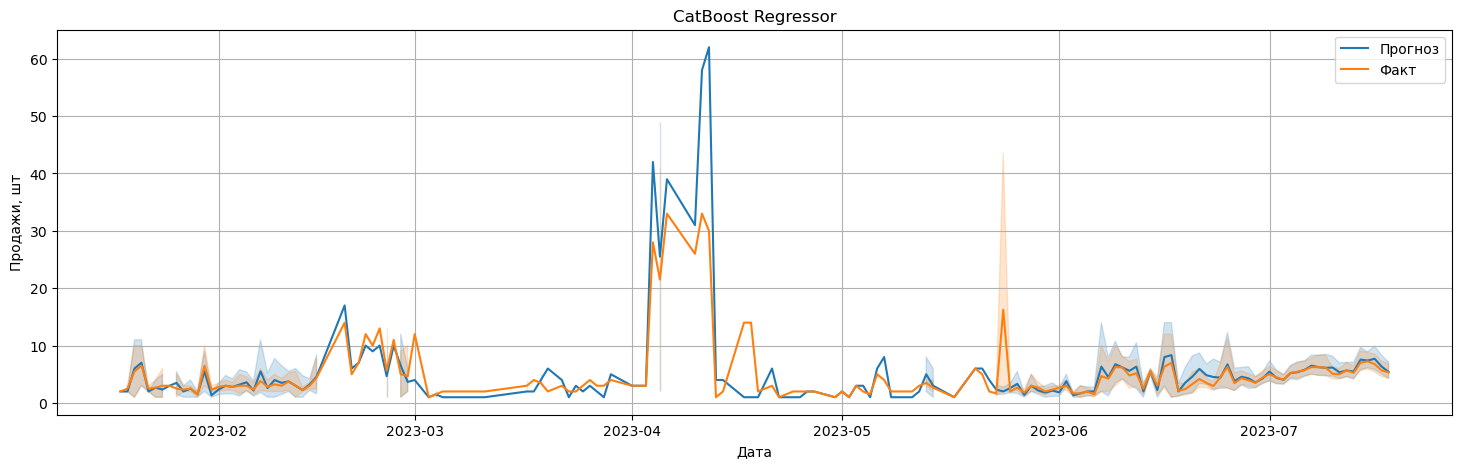

In [203]:
#Сравним данные прогноза и реальные данные на примере магазина с самыми хорошими продажами
store='c81e728d9d4c2f636f067f89cc14862c'
sku = '62d4af457ba2540ce0898a211c0cd17a'
graph_pred (result_df, 'prediction', 'sales_units', 'store', store, 'sku', sku, 'CatBoost Regressor')

In [204]:
print(f"Среднее значение WAPE: {result_1s2s.wape.mean()}")

Среднее значение WAPE: 0.1384311570079013


#### Функция для предсказания временного ряда на 2 недели вперед:

In [205]:
def make_predict(df, st_id, pr_sku_id):
    sku_st = df[(df['store'] == st_id) & (df['sku'] == pr_sku_id)]

# начальная дата для предсказаний (+1 день от последней даты в индексе sku_st)
    end_date = sku_st.index.max()
    pred_start_date = end_date + pd.DateOffset(days=1)
    pred_end_date = end_date + pd.DateOffset(days=14)  # +14 дней вперед

# признаки (X) и целевой признак (y)
    X_train = sku_st.drop(['sales_units','sales_rub', 'sales_rub_stand', 'sales_units_stand', 'store', 'sku'], axis=1)
    y_train = sku_st['sales_units_stand']

    last_two_week = sku_st[(sku_st.index >= end_date - pd.DateOffset(days=14)) & (sku_st.index < end_date)]
    X_last_two_week = last_two_week.drop(['sales_units','sales_rub', 'sales_rub_stand', 'sales_units_stand',  'store', 'sku'], axis=1)
    y_last_two_week = last_two_week['sales_units_stand']

# новые даты для предсказаний
    new_dates = pd.date_range(start=pred_start_date, end=pred_end_date)
    splits = TimeSeriesSplit(n_splits=(len(X_train) // 14))
# модель
    grid_cbr = GridSearchCV(
        estimator=model_cbr,
        param_grid=best_parameters_cbr,
        cv=splits,
        verbose=True,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1)
    grid_cbr.fit(X_train, y_train)
    best_model_cbr = grid_cbr.best_estimator_

# предсказания на 14 дней вперед последней даты
    X_pred = pd.DataFrame(index=new_dates, columns=X_train.columns)  # пустая таблица для предсказаний
    predictions = best_model_cbr.predict(X_last_two_week) # предсказания на последних 14 днях

# восстановление исходных значений (ранее они были стандартизированы для обучения)
    predict_cbr = ((predictions * sales_units_sd) + sales_units_mean).round(0)

# итоговая таблица
    predictions_df = pd.DataFrame({'st_id': st_id,
                                   'pr_sku_id': pr_sku_id,
                                   'date': new_dates,
                                   'target': predict_cbr})
    return predictions_df

#### Сделаем прогноз спроса по всем магазинам и по всем товарам

In [ ]:
%%time
# пустой датафрейм для хранения всех результатов
result_df = pd.DataFrame()

# прогнозы для нужных магазинов и товаров
for st_id in stores:
    for pr_sku_id in skus:
        # данные для текущей пары st_id и pr_sku_id
        filtered_data = df[(df['store'] == st_id) & (df['sku'] == pr_sku_id)]

        # есть ли данные для этой пары
        if not filtered_data.empty:
            # срок продаж
            min_index = filtered_data.index.min()
            max_index = filtered_data.index.max()

            # преабразуем индексы
            if isinstance(min_index, str):
                min_index = pd.to_datetime(min_index)
            if isinstance(max_index, str):
                max_index = pd.to_datetime(max_index)

            date_diff = (max_index - min_index).days

            if date_diff < 180:
                print(f"В магазине:{st_id} товар:{pr_sku_id} продается: {date_diff} дней. Недостаточно данных продаж для прогноза.")
            else:
                try:
                    df_1 = make_predict(df, st_id, pr_sku_id)
                    result_df = pd.concat([result_df, df_1], ignore_index=True)
                except Exception as e:
                    print(f"Ошибка при обработке st_id:{st_id},sku:{pr_sku_id}: {e}")
        else:
            print(f"В магазине:{st_id} товар:{pr_sku_id} не найден")

# Выводим результаты
display(result_df)

### Оценка важности признаков

In [207]:
#по магазину с самым высоким уровнем продаж
store = 'c81e728d9d4c2f636f067f89cc14862c'
sku = '62d4af457ba2540ce0898a211c0cd17a'
best_model_cbr, X_test, feature_importances_cbr = train_model(df, store, sku)
# по магазину с низким уровнем продаж
store2 = 'c81e728d9d4c2f636f067f89cc14862c'
sku2 = 'c7b711619071c92bef604c7ad68380dd'
best_model_cbr2, X_test2, feature_importances_cbr2 = train_model(df, store2, sku2)

Fitting 27 folds for each of 1 candidates, totalling 27 fits
Fitting 23 folds for each of 1 candidates, totalling 23 fits


In [208]:
def graph_features (model_feature_importance, features, name):
    feature_importance = pd.DataFrame((model_feature_importance), list(features.columns),columns=['Значения'])\
                                        .reset_index().rename(columns={'index':'Признаки'})
    plt.figure(figsize=(18, 5))
    sns.barplot(x="Значения", y="Признаки", data=feature_importance.sort_values(by="Значения", ascending=False).head(20), palette = 'tab20')#'Pastel2','rainbow'
    plt.title(f'Оценка важности признаков {name}')
    plt.tight_layout()
    plt.show()

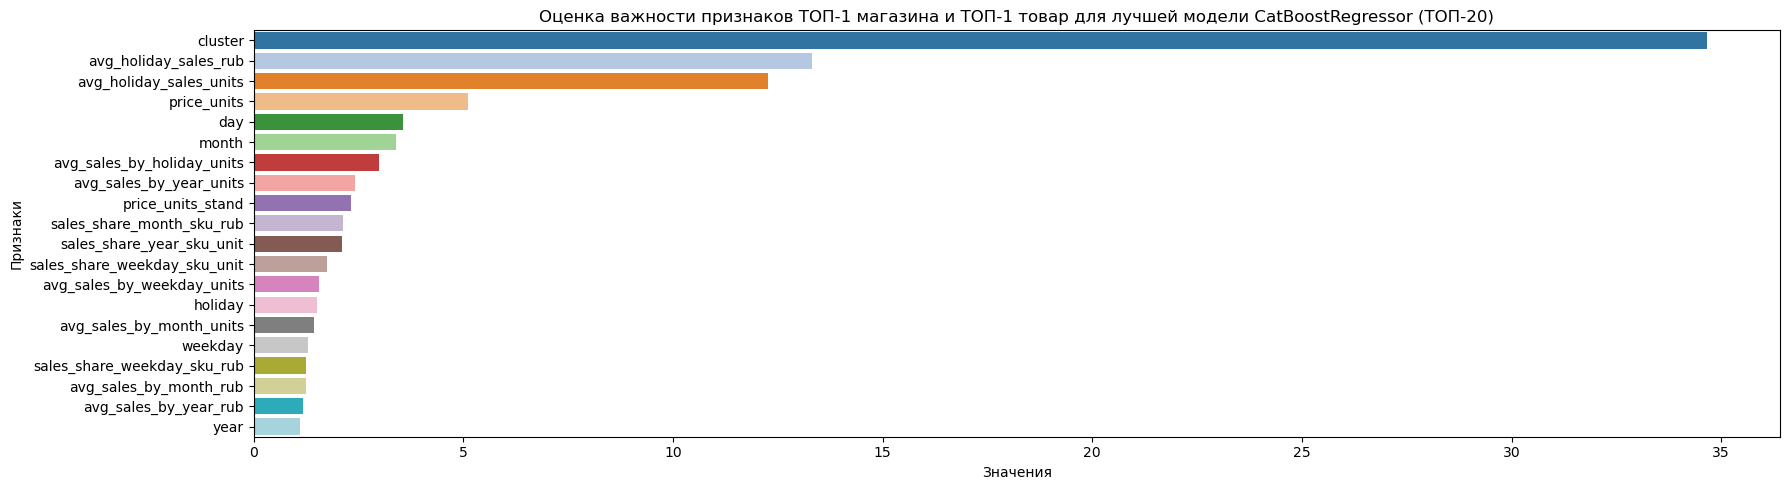

In [209]:
graph_features (feature_importances_cbr, X_test, 'ТОП-1 магазина и ТОП-1 товар для лучшей модели CatBoostRegressor (ТОП-20)')

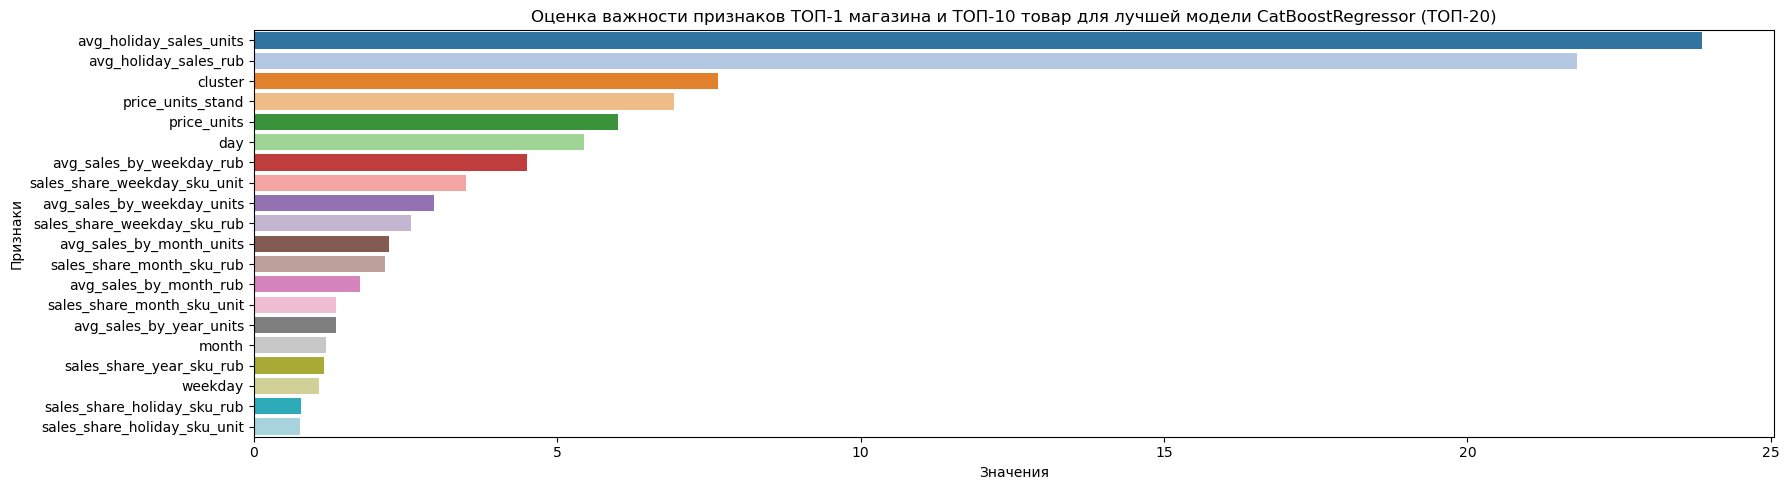

In [210]:
graph_features (feature_importances_cbr2, X_test2, 'ТОП-1 магазина и ТОП-10 товар для лучшей модели CatBoostRegressor (ТОП-20)')

## Вывод
1. Протестированы модели: LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor, CatBoost, Orbit.
2. Лучшая модель по соотношению скорость и точноть прогноза : **CatBoost**
 > лучшие параметры модели:
    ```'bagging_temperature': [0.6], 'depth': [6],
     'iterations': [100],'learning_rate': [0.1],
     'random_strength': [1.0],'verbose': [False]```
     - **Среднее значение WAPE = 42,7%** по всей выборке из 1000 товаров и 9 магазинов
3. Тест модели на ТОП-2 товара и ТОП-2 магазина попродажам дает **Среднее значение WAPE = 13.8%**
4. Оценка признаков ТОП-20 для магазина ТОП-1 по продажам, выявила наиболее важные признаки: кластеры и доля продаж количества товаров в выходной. Можно предположить, что на корректность предсказания оказывает большое влияние продажи в праздники.
5. Для ТОП-1 магазина по продажам и ТОП-10 товара важными признаками являются средние продажи в праздники.
6. Вероятно, имеет смысл сделать отдельные модели для магазинов и модель по прогнозу спроса товаров в праздничные дни.

In [211]:
#Сохраним полученные данные
result_df.to_csv('sales_submission.csv', index=False)

In [212]:
#Выгружаем модель
with open('./model.pkl', 'wb') as model_pkl:
  pickle.dump(best_model_cbr, model_pkl)

# Вывод
1. Введение:
- Основная задача нашего исследования - создать алгоритм прогноза спроса на 14 дней для товаров собственного производства с  гранулярностью Магазин-Scu-День на товары собственного производства заказчика ООО “Лента”.

2. При загрузке данных было выявлено:
- иследуемый временной период:  2022-08-01 - 2023-07-18 (351 день)
- при формировании общего датасета были учтены периоды праздников, допольнительно подключен календарь и созданы временные признаки, такие как неделя, день, месяц, год
- высокая корреляция между рядом признаков, в частности продаж - промо/не промо, что позволило принять решение о создать нового признака - доля продаж промо

3. Результаты анализа данных:
- явных дубликатов не наблюдалось, пропусков нет, временной ряд последовательный
- наблюдались аномалии в виде отрицательных значений в продажах - принято решение удалить, так как непонятна природа их возникновения
- нулевые значения в столбце целевого признака заполнены значениями из строк ниже, на основании гипотезы о схожих продажах товара в соседнии дни
- исследование временных рядов данных показало:
  -  наблюдается явная сезонность, самый большой всплеск продаж - в декабре, а также май, июнь, что явно совпадает с государственными праздниками РФ
   > явные выбросы по продажам в районе НГ (c 29 по 31 декабря), в апреле, видимо Пасха (13-15 апреля) и майских праздников (7-9 мая).
   - обнаружена линейную зависимость общих продаж и продаж с промо
   - при подготовке датасета для обучения модели ресемплировали его по дням для более точного прогноза
   - тренд ровный, совсем немного растущий вверх с явными выбросами
   - в сезонности наблюдается цикличность в промежутке **12 дней**.
- определены активные и неактивные магазины, посленые были удалены из исследования (3 шт)
- проведен детальный анализ по типам продаж, группам товаров, категориям и подкатегориям, на основе анализа было сформировано **более 40 дополнительных признаков**
- выявлены магазины с наибольшим и наименьшим количеством продаж, аналогично проведена выборка по товарам
- принято решение тестирование модели проводить на лучших по продажам магазинах и товарах
- сделан вывод, что некоторые товары продавались только по праздникам, и имеет смысл построить дополнительную модель по прогнозу спроса в праздничные дни (это для будущего, вне рамок нынешнего ТЗ)
- проведена кластеризация, методом "локтя" определено 11 кластеров - их учли при формировании признаков
- также было проведено кодирование и нормализация признаков для подачи данных на обучение.
- ресемплирование проводили по дням с шириной окна = 12.

4. Подбор лучшей модели:
- протестированы модели: LinearRegression, RandomForestRegressor, CatBoostRegressor, LGBMRegressor, CatBoost, Orbit.
- лучшая модель по соотношению скорость и точноть прогноза : **CatBoost**
 > лучшие параметры модели:
    ```'bagging_temperature': [0.6], 'depth': [6],
     'iterations': [100],'learning_rate': [0.1],
     'random_strength': [1.0],'verbose': [False]```
     - **Среднее значение WAPE = 42,7%** по всей выборке из 1000 товаров и 9 магазинов
- тест модели на ТОП-2 товара и ТОП-2 магазина попродажам дает **Среднее значение WAPE = 13.8%**
- оценка признаков ТОП-20 для магазина ТОП-1 по продажам, выявила наиболее важные признаки: кластеры и доля продаж количества товаров в выходной. Можно предположить, что на корректность предсказания оказывает большое влияние продажи в праздники.
- для ТАЙЛ-1 магазина по продажам для этого же scu важными признаками являются цена за scu и день месяца.
- вероятно, имеет смысл сделать отдельные модели для магазинов и модель по прогнозу спроса товаров в праздничные дни.

> Среднее значение на лучшей модели **CatBoost** **WAPE = 42,7%**